#Unión de bases y propagación

In [1]:
!pip install -q openpyxl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_folder = '/content/drive/MyDrive/Prueba de Conocimiento Skandia'

In [4]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

BASE_FOLDER = Path('/content/drive/MyDrive/Prueba de Conocimiento Skandia')

# =========================
# Funciones auxiliares
# =========================

def extract_date_from_filename(fname: str) -> pd.Timestamp:
    """
    Extrae la fecha del nombre del archivo.
    Formato esperado: ...YYYY_MM... o ...YYYY-MM...
    """
    m = re.search(r'(\d{4})[_-](\d{2})', fname)
    if not m:
        return pd.NaT
    return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-01") + MonthEnd(0)


def process_file(path: Path) -> pd.DataFrame:
    """
    Procesa un archivo Excel con estructura jerárquica.
    """
    print(f"📄 Procesando: {path.name}")

    # Leer el archivo Excel
    df = pd.read_excel(
        path,
        header=10,   # fila 11 (0-indexed)
        dtype=object
    )

    # Eliminar filas completamente vacías
    df = df.dropna(how='all').reset_index(drop=True)

    # Renombrar columnas de jerarquía
    cols = df.columns.tolist()
    df = df.rename(columns={
        cols[0]: 'rubro',
        cols[1]: 'subrubro',
        cols[2]: 'detalle'
    })

    # Limpieza básica de texto
    for c in ['rubro', 'subrubro', 'detalle']:
        if c in df.columns:
            df[c] = df[c].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # Crear una copia de las columnas originales para referencia
    df['rubro_original'] = df['rubro'].copy()
    df['subrubro_original'] = df['subrubro'].copy()
    df['detalle_original'] = df['detalle'].copy()

    # Identificar cambios en los rubros (nuevos rubros)
    # Un nuevo rubro es cuando tenemos un valor no vacío en 'rubro' y es diferente del anterior
    df['es_nuevo_rubro'] = False
    for i in range(len(df)):
        if i == 0:
            df.loc[i, 'es_nuevo_rubro'] = pd.notna(df.loc[i, 'rubro']) and str(df.loc[i, 'rubro']).strip() != ''
        else:
            current_rubro = df.loc[i, 'rubro']
            prev_rubro = df.loc[i-1, 'rubro']

            # Es nuevo rubro si:
            # 1. Tiene valor en rubro Y
            # 2. Es diferente del rubro anterior O es el inicio de un nuevo bloque
            if pd.notna(current_rubro) and str(current_rubro).strip() != '':
                if pd.isna(prev_rubro) or str(prev_rubro).strip() == '' or str(current_rubro).strip() != str(prev_rubro).strip():
                    df.loc[i, 'es_nuevo_rubro'] = True

    # PRIMERO: Forward fill del rubro
    df['rubro'] = df['rubro'].ffill()

    # SEGUNDO: Procesar subrubros con lógica mejorada
    # Creamos una columna para identificar el "contexto" de cada rubro
    df['contexto_rubro'] = ''
    current_context = ''

    for i in range(len(df)):
        if df.loc[i, 'es_nuevo_rubro']:
            # Cuando encontramos un nuevo rubro, creamos un nuevo contexto
            current_context = str(df.loc[i, 'rubro'])
            df.loc[i, 'contexto_rubro'] = current_context

            # Si es un nuevo rubro, debemos verificar si tiene subrubro inmediato
            if i + 1 < len(df) and pd.isna(df.loc[i, 'subrubro']):
                # El rubro actual no tiene subrubro en su misma fila
                # Verificar si la siguiente fila tiene subrubro
                if i + 1 < len(df) and pd.notna(df.loc[i + 1, 'subrubro_original']):
                    # La siguiente fila es un subrubro de este rubro
                    # Mantener el subrubro vacío para este rubro
                    df.loc[i, 'contexto_rubro'] = current_context + '_sin_subrubro'
                else:
                    # Este rubro está solo, sin subrubros
                    df.loc[i, 'contexto_rubro'] = current_context + '_solo'
        else:
            df.loc[i, 'contexto_rubro'] = current_context

    # TERCERO: Forward fill de subrubros DENTRO de cada contexto
    # Pero solo si el contexto no es "solo" o "sin_subrubro" para el primer elemento
    df['subrubro_filled'] = pd.NA

    for i in range(len(df)):
        contexto = df.loc[i, 'contexto_rubro']

        if '_solo' in contexto:
            # Rubros solos: no tienen subrubro
            df.loc[i, 'subrubro_filled'] = pd.NA
        elif '_sin_subrubro' in contexto and df.loc[i, 'es_nuevo_rubro']:
            # Primer rubro de un contexto sin subrubro inmediato
            df.loc[i, 'subrubro_filled'] = pd.NA
        else:
            # Para otras filas, hacer forward fill dentro del mismo contexto
            if pd.notna(df.loc[i, 'subrubro_original']) and str(df.loc[i, 'subrubro_original']).strip() != '':
                # Tiene subrubro original, usarlo
                df.loc[i, 'subrubro_filled'] = df.loc[i, 'subrubro_original']
            elif i > 0 and df.loc[i-1, 'contexto_rubro'] == contexto:
                # Mismo contexto que el anterior, heredar subrubro
                df.loc[i, 'subrubro_filled'] = df.loc[i-1, 'subrubro_filled']
            else:
                # Cambio de contexto sin subrubro, dejar vacío
                df.loc[i, 'subrubro_filled'] = pd.NA

    # Reemplazar la columna subrubro original con la procesada
    df['subrubro'] = df['subrubro_filled']

    # CUARTO: Forward fill de detalles (solo si hay subrubro)
    for i in range(len(df)):
        if pd.notna(df.loc[i, 'detalle_original']) and str(df.loc[i, 'detalle_original']).strip() != '':
            # Tiene detalle original, mantenerlo
            pass
        elif pd.notna(df.loc[i, 'subrubro']):
            # Tiene subrubro, verificar si el detalle debe heredarse del anterior
            if i > 0 and pd.notna(df.loc[i-1, 'subrubro']) and df.loc[i-1, 'subrubro'] == df.loc[i, 'subrubro']:
                # Mismo subrubro que el anterior, heredar detalle si aplica
                if pd.notna(df.loc[i-1, 'detalle']):
                    df.loc[i, 'detalle'] = df.loc[i-1, 'detalle']

    # QUINTO: Limpieza final
    # Limpiar valores que no deberían tener propagación

    # Identificar filas donde el rubro original estaba vacío pero ahora tiene un rubro propagado
    for i in range(len(df)):
        if pd.isna(df.loc[i, 'rubro_original']) or str(df.loc[i, 'rubro_original']).strip() == '':
            # Esta fila originalmente no tenía rubro
            # Verificar si debería tener subrubro propagado
            if i > 0 and df.loc[i, 'es_nuevo_rubro']:
                # Si es un nuevo rubro, no debería heredar subrubro del anterior
                df.loc[i, 'subrubro'] = pd.NA

    # SEXTO: Asegurar que los rubros solos no tengan subrubro ni detalle
    for i in range(len(df)):
        if df.loc[i, 'es_nuevo_rubro']:
            # Verificar si es un rubro solo (sin subrubro en la misma fila y sin subrubros siguientes en el mismo contexto)
            if pd.isna(df.loc[i, 'subrubro']):
                # Este rubro no tiene subrubro
                # Verificar si hay subrubros en las siguientes filas del mismo contexto
                j = i + 1
                tiene_subrubros = False
                while j < len(df) and df.loc[j, 'contexto_rubro'] == df.loc[i, 'contexto_rubro']:
                    if pd.notna(df.loc[j, 'subrubro']):
                        tiene_subrubros = True
                        break
                    j += 1

                if not tiene_subrubros:
                    # Es un rubro solo, limpiar subrubro y detalle
                    df.loc[i, 'subrubro'] = pd.NA
                    df.loc[i, 'detalle'] = pd.NA

    # Eliminar columnas temporales
    columnas_a_eliminar = ['rubro_original', 'subrubro_original', 'detalle_original',
                          'es_nuevo_rubro', 'contexto_rubro', 'subrubro_filled']
    for col in columnas_a_eliminar:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Metadatos
    df.insert(0, 'file_date', extract_date_from_filename(path.name))
    df.insert(0, 'source_file', path.name)

    # Reordenar columnas
    metric_cols = [c for c in df.columns if c not in
                  ['source_file', 'file_date', 'rubro', 'subrubro', 'detalle']]
    df = df[['source_file', 'file_date', 'rubro', 'subrubro', 'detalle'] + metric_cols]

    return df




In [5]:
# =========================
# Cargar todos los archivos
# =========================

print("🔍 Buscando archivos...")
files = sorted(BASE_FOLDER.glob('ig_*.[xls]*'))

if not files:
    files = sorted(BASE_FOLDER.glob('ig_*.*'))

print(f"\n📂 Archivos encontrados: {len(files)}")
for i, f in enumerate(files, 1):
    print(f" {i:2d}. {f.name}")

# =========================
# Procesar archivos
# =========================

dfs = []
for f in files:
    try:
        print(f"\n🔧 Procesando: {f.name}")
        df = process_file(f)
        dfs.append(df)
        print(f"   ✅ Procesado: {len(df)} registros")

        # DEBUG: Mostrar ejemplo del problema específico
        print(f"   🔍 Buscando 'PASIVOS  Y PATRIMONIO' y 'PASIVOS'...")
        df_filtrado = df[df['rubro'].str.contains('PASIVOS', na=False)].head(10)
        if not df_filtrado.empty:
            for idx, row in df_filtrado.iterrows():
                print(f"      Rubro: {row['rubro']}, Subrubro: {row['subrubro']}, Detalle: {row['detalle']}")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:100]}")

# =========================
# Consolidar resultados
# =========================

if not dfs:
    print("\n⚠️  No se procesaron archivos")
    df_ig = pd.DataFrame()
else:
    df_ig = pd.concat(dfs, ignore_index=True)
    df_ig.insert(0, 'idx', range(1, len(df_ig) + 1))

    # =========================
    # Validaciones específicas
    # =========================
    print("\n" + "="*60)
    print("✅ VALIDACIÓN ESPECÍFICA DEL PROBLEMA MENCIONADO")
    print("="*60)

    # Buscar específicamente los rubros problemáticos
    problematic_rubros = ['PASIVOS  Y PATRIMONIO', 'PASIVOS', 'PATRIMONIO']

    for rubro in problematic_rubros:
        print(f"\n🔍 Buscando: '{rubro}'")
        matches = df_ig[df_ig['rubro'].str.contains(rubro, na=False, case=False)]

        if not matches.empty:
            print(f"   Encontrados: {len(matches)} registros")
            for _, row in matches.head(5).iterrows():
                print(f"   - Rubro: '{row['rubro']}', Subrubro: '{row['subrubro']}', Detalle: '{row['detalle']}'")
        else:
            print(f"   No encontrado")

    # Verificar propagación incorrecta
    print("\n🔍 Verificando propagación entre rubros...")

    # Encontrar secuencias problemáticas
    for i in range(1, len(df_ig) - 1):
        current_rubro = df_ig.loc[i, 'rubro']
        prev_rubro = df_ig.loc[i-1, 'rubro']
        current_subrubro = df_ig.loc[i, 'subrubro']
        prev_subrubro = df_ig.loc[i-1, 'subrubro']

        if (pd.notna(current_rubro) and pd.notna(prev_rubro) and
            current_rubro != prev_rubro and
            pd.notna(current_subrubro) and pd.notna(prev_subrubro) and
            current_subrubro == prev_subrubro):
            print(f"   ⚠️ Posible propagación incorrecta en índice {i}:")
            print(f"      Fila {i-1}: Rubro='{prev_rubro}', Subrubro='{prev_subrubro}'")
            print(f"      Fila {i}: Rubro='{current_rubro}', Subrubro='{current_subrubro}'")

    print("\n" + "="*60)
    print("📊 RESUMEN GENERAL")
    print("="*60)
    print(f"Total registros: {len(df_ig):,}")
    print(f"Archivos procesados: {df_ig['source_file'].nunique()}")
    print(f"Rubros únicos: {df_ig['rubro'].nunique()}")
    print(f"Subrubros únicos: {df_ig['subrubro'].nunique()}")

    # Distribución jerárquica
    rubros_solos = df_ig[df_ig['subrubro'].isna() & df_ig['detalle'].isna()]
    subrubros_solos = df_ig[df_ig['detalle'].isna() & df_ig['subrubro'].notna()]
    detalles = df_ig[df_ig['detalle'].notna()]

    print(f"\n📈 Distribución jerárquica:")
    print(f"  • Rubros solos: {len(rubros_solos):,}")
    print(f"  • Subrubros solos: {len(subrubros_solos):,}")
    print(f"  • Detalles completos: {len(detalles):,}")

print("\n✅ Proceso completado!")

🔍 Buscando archivos...

📂 Archivos encontrados: 6
  1. ig_2021_12.xls
  2. ig_2022_12.xls
  3. ig_2023_12.xls
  4. ig_2024_09.xls
  5. ig_2024_12.xls
  6. ig_2025_09.xls

🔧 Procesando: ig_2021_12.xls
📄 Procesando: ig_2021_12.xls
   ✅ Procesado: 593 registros
   🔍 Buscando 'PASIVOS  Y PATRIMONIO' y 'PASIVOS'...
      Rubro: PASIVOS  Y PATRIMONIO, Subrubro: <NA>, Detalle: <NA>
      Rubro: PASIVOS, Subrubro: <NA>, Detalle: <NA>
      Rubro: PASIVOS, Subrubro: INSTRUMENTOS FINANCIEROS A COSTO AMORTIZADO, Detalle: nan
      Rubro: PASIVOS, Subrubro: INSTRUMENTOS FINANCIEROS A COSTO AMORTIZADO, Detalle: DEPÓSITOS EN CUENTA CORRIENTE
      Rubro: PASIVOS, Subrubro: INSTRUMENTOS FINANCIEROS A COSTO AMORTIZADO, Detalle: DEPÓSITOS SIMPLES
      Rubro: PASIVOS, Subrubro: INSTRUMENTOS FINANCIEROS A COSTO AMORTIZADO, Detalle: CERTIFICADOS DE DEPÓSITO A TERMINO
      Rubro: PASIVOS, Subrubro: INSTRUMENTOS FINANCIEROS A COSTO AMORTIZADO, Detalle: DEPÓSITOS DE AHORRO
      Rubro: PASIVOS, Subrubro: I

In [6]:
df_ig.head()

,idx,source_file,file_date,rubro,subrubro,detalle,Total Entidades Establecimientos de crédito sin IOE'S,Total Sector Privado,Total Sector Privado Nacional,Total Sector Privado Extranjero,...,SANTANDER CONSUMER S.A. C.F.C,Total CFIs privadas,BANCIEN S.A,RAPPIPAY COMPAÑÍA DE FINANCIAMIENTO,MERCADO PAGO,BOLD COMPAÑÍA DE FINANCIAMIENTO,BANCO CONTACTAR,CREDICORP CAPITAL CORPORACIÓN FINANCIERA,NU COLOMBIA C.F.,KOA C.F
0,1,ig_2021_12.xls,2021-12-31,NaN,<NA>,Cifras con corte a 24-feb-2022,dic-21,dic-21,dic-21,dic-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ig_2021_12.xls,2021-12-31,BALANCE (cifras en $ millones),<NA>,<NA>,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,ig_2021_12.xls,2021-12-31,ACTIVOS,<NA>,<NA>,861021564.14,824355718.3,601021937.09,223333781.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ig_2021_12.xls,2021-12-31,ACTIVOS,DISPONIBLE,NaN,67795668.28,65781170.52,41275624.36,24505546.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,ig_2021_12.xls,2021-12-31,ACTIVOS,POSICIONES ACTIVAS EN OPERACIONES DE MERCADO M...,NaN,22515567.15,22447883.42,6856334.64,15591548.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Limpieza de datos

In [7]:
df_ig = df_ig.drop([0]).reset_index(drop=True)
df_ig


,idx,source_file,file_date,rubro,subrubro,detalle,Total Entidades Establecimientos de crédito sin IOE'S,Total Sector Privado,Total Sector Privado Nacional,Total Sector Privado Extranjero,...,SANTANDER CONSUMER S.A. C.F.C,Total CFIs privadas,BANCIEN S.A,RAPPIPAY COMPAÑÍA DE FINANCIAMIENTO,MERCADO PAGO,BOLD COMPAÑÍA DE FINANCIAMIENTO,BANCO CONTACTAR,CREDICORP CAPITAL CORPORACIÓN FINANCIERA,NU COLOMBIA C.F.,KOA C.F
0,2,ig_2021_12.xls,2021-12-31,BALANCE (cifras en $ millones),<NA>,<NA>,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,ig_2021_12.xls,2021-12-31,ACTIVOS,<NA>,<NA>,861021564.14,824355718.3,601021937.09,223333781.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,ig_2021_12.xls,2021-12-31,ACTIVOS,DISPONIBLE,NaN,67795668.28,65781170.52,41275624.36,24505546.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,ig_2021_12.xls,2021-12-31,ACTIVOS,POSICIONES ACTIVAS EN OPERACIONES DE MERCADO M...,NaN,22515567.15,22447883.42,6856334.64,15591548.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,ig_2021_12.xls,2021-12-31,ACTIVOS,POSICIONES ACTIVAS EN OPERACIONES DE MERCADO M...,INTERBANCARIOS,4678851.23,4611167.5,3387897.65,1223269.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,3554,ig_2025_09.xls,2025-09-30,DETERIORO CARTERA Y LEASING,<NA>,OTRAS,232622.6,107932.81,101831.74,6101.07,...,NaN,0,81.11,0,0,0.2,7205.36,0,0,0
3553,3555,ig_2025_09.xls,2025-09-30,DETERIORO CARTERA Y LEASING,<NA>,OTRAS,1570618.76,1364573.02,1106699.53,257873.49,...,NaN,0,93.36,0,0,0.2,7205.36,0,0,0
3554,3556,ig_2025_09.xls,2025-09-30,DETERIORO CARTERA Y LEASING,DETERIORO COMPONENTE CONTRACICLICO,NaN,4382589.13,4180899.94,3191391.53,989508.41,...,NaN,4.53,29232.14,258.97,0,0,622.63,0,41641.58,0
3555,3557,ig_2025_09.xls,2025-09-30,DETERIORO CARTERA Y LEASING,DETERIORO COMPONENTE CONTRACICLICO,COMERCIAL,1845564.67,1766729.45,1480195.34,286534.11,...,NaN,4.53,526.59,0,0,0,569.12,0,0,0


In [8]:
print("Valores de 'rubro'",df_ig['rubro'].unique())
#print("Valores de 'subrubro'",df_ig['subrubro'].unique())
#print("Valores de 'detalle'",df_ig['detalle'].unique())

Valores de 'rubro' ['BALANCE (cifras en $ millones)' 'ACTIVOS' 'PASIVOS  Y PATRIMONIO'
 'PASIVOS' 'PATRIMONIO'
 'ESTADO DE PERDIDAS Y GANANCIAS (cifras en $ millones)'
 'INGRESOS DE OPERACIONES' 'GASTOS' 'IMPUESTO DE RENTA Y COMPLEMENTARIOS'
 'GANANCIAS (EXCEDENTES) Y PÉRDIDAS'
 'CARTERA DE CREDITOS Y OPERACIONES DE LEASING'
 'INDICADORES DE CARTERA Y LEASING'
 'CARTERA Y LEASING POR MODALIDAD (POR CALIFICACION)'
 'APALANCAMIENTO Y RENTABILIDAD' 'INDICADORES DE RIESGO POR TIEMPO'
 'CARTERA Y LEASING POR CALIFICACION' 'TOTAL CARTERA Y LEASING'
 'DETERIORO CARTERA Y LEASING' nan]


In [9]:
df_ig.columns

Index(['idx', 'source_file', 'file_date', 'rubro', 'subrubro', 'detalle',
       'Total Entidades Establecimientos de crédito sin IOE'S',
       'Total Sector Privado', 'Total Sector Privado Nacional',
       'Total Sector Privado Extranjero', 'Total Sector Público',
       'Total Sector Cooperativas', 'Total Bancos ', 'Bancos Privados',
       'Bancos Privados Nacionales ', 'Bancos Privados Extranjeros',
       'Bancos Públicos ', 'Bancos Nacionales', 'Total CFIs', 'CFIs Privadas',
       'CFIs Privadas Nacionales', 'CFIs Privadas Extranjeras', 'Total CFs ',
       'Total CFs Nacionales (Tradicionales+Leasing)',
       'Total CFs Extranjeras (Tradicionales+Leasing)',
       'Total CFs Tradicionales', 'CFs Privadas', 'CFs Privadas Nacionales',
       'CFs Privadas Extranjeras', 'Total Cooperativas', 'BANCO DE BOGOTA',
       'BANCO POPULAR', 'ITAÚ CORPBANCA COLOMBIA S.A.', 'BANCOLOMBIA',
       'CITIBANK-COLOMBIA', 'GNB SUDAMERIS', 'BBVA COLOMBIA', 'OCCIDENTE',
       'BANCO CAJA SOCIA

In [10]:
df_ig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 92 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   idx                                                    3557 non-null   int64         
 1   source_file                                            3557 non-null   object        
 2   file_date                                              3557 non-null   datetime64[ns]
 3   rubro                                                  3552 non-null   object        
 4   subrubro                                               2862 non-null   object        
 5   detalle                                                2513 non-null   object        
 6   Total Entidades Establecimientos de crédito sin IOE'S  3431 non-null   object        
 7   Total Sector Privado                                   3431 non-null 

In [11]:
# Si las columnas deberían ser numéricas pero están como object
start_col = 'Total Entidades Establecimientos de crédito sin IOE\'S'
col_idx = df_ig.columns.get_loc(start_col)

# Convertir a numérico y luego rellenar nulos
for col in df_ig.columns[col_idx:]:
    df_ig[col] = pd.to_numeric(df_ig[col], errors='coerce').fillna(0)

In [12]:
cols = ["rubro", "subrubro", "detalle"]

df_ig[cols] = df_ig[cols].fillna(0)

In [13]:
# 1. Eliminar la columna 'source_file'
df_ig = df_ig.drop(columns=['source_file'])

# 2. Renombrar 'file_date' a 'date'
df_ig = df_ig.rename(columns={'file_date': 'date'})

In [14]:
resultado = df_ig[(df_ig['rubro'].str.contains('PATRIMONIO', na=False)) &
                  (df_ig['date'] == '2025-09-30')]

resultado

r1=[
    'rubro',
    'subrubro',
    'detalle',
    'BANCIEN S.A',
    'BANCAMIA',
    'BANCO W S.A.',
    'BANCOOMEVA',
    'BANCO FALABELLA S.A.',
    'BANCO PICHINCHA S.A.',
    'BANCO MUNDO MUJER S.A.',
    'LULO BANK S.A.'
]
r=resultado[r1]
r

,rubro,subrubro,detalle,BANCIEN S.A,BANCAMIA,BANCO W S.A.,BANCOOMEVA,BANCO FALABELLA S.A.,BANCO PICHINCHA S.A.,BANCO MUNDO MUJER S.A.,LULO BANK S.A.
3052,PASIVOS Y PATRIMONIO,0,0,2814168.22,2629584.29,2487094.57,5587807.47,6162286.57,3908494.05,3558472.74,1463431.70
3120,PATRIMONIO,0,0,223563.06,378098.93,528044.51,531907.40,915025.39,405304.03,512631.11,392176.06
3121,PATRIMONIO,CAPITAL SOCIAL,0,92255.61,330611.79,171779.44,507528.44,82799.29,742957.58,172310.00,290017.00
3122,PATRIMONIO,CAPITAL SOCIAL,CAPITAL SUSCRITO Y PAGADO,92255.61,330611.79,171779.44,507528.44,82799.29,742957.58,172310.00,290017.00
3123,PATRIMONIO,CAPITAL SOCIAL,"ACCIONES, CUOTAS O PARTES DE INTERÉS SOCIAL PR...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3124,PATRIMONIO,CAPITAL SOCIAL,APORTES SOCIALES,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3125,PATRIMONIO,CAPITAL SOCIAL,CAPITAL MINIMO E IRREDUCTIBLE SECCION AHORROS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3126,PATRIMONIO,CAPITAL SOCIAL,APORTES DEL ESTADO,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3127,PATRIMONIO,CAPITAL SOCIAL,DIVIDENDOS DECRETADOS EN ACCIONES,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3128,PATRIMONIO,CAPITAL SOCIAL,PARTICIPACIONES NO CONTROLADORAS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
df_ig['date'].unique()

<DatetimeArray>
['2021-12-31 00:00:00', '2022-12-31 00:00:00', '2023-12-31 00:00:00',
 '2024-09-30 00:00:00', '2024-12-31 00:00:00', '2025-09-30 00:00:00']
Length: 6, dtype: datetime64[ns]

In [16]:
# Definir las columnas que quieres guardar
columnas_a_guardar = [
    'idx',
    'date',
    'rubro',
    'subrubro',
    'detalle',  # Asumiendo que el nombre correcto es 'detalle' sin comillas adicionales
    'BANCIEN S.A',
    'BANCAMIA',
    'BANCO W S.A.',
    'BANCOOMEVA',
    'BANCO FALABELLA S.A.',
    'BANCO PICHINCHA S.A.',
    'BANCO MUNDO MUJER S.A.',
    'LULO BANK S.A.'
]

# Filtrar solo las columnas que existen en el DataFrame
columnas_existentes = [col for col in columnas_a_guardar if col in df_ig.columns]

# Guardar en archivo TXT (separado por tabulaciones)
#df_ig[columnas_existentes].to_csv('datos_objetivos',
 #                                 sep='\t',
  #                                index=False,
   #                               encoding='utf-8')
import pandas as pd

# Guardar en archivo Excel
df_ig[columnas_existentes].to_excel('datos_objetivo.xlsx',
                                    index=False,
                                    sheet_name='Datos')
df_ig.to_excel('data_completa.xlsx',
                                    index=False,
                                    sheet_name='Datos')
df1=df_ig[columnas_a_guardar]

# EDA

##General

In [ ]:
df_ig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 91 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   idx                                                    3557 non-null   int64         
 1   date                                                   3557 non-null   datetime64[ns]
 2   rubro                                                  3557 non-null   object        
 3   subrubro                                               3557 non-null   object        
 4   detalle                                                3557 non-null   object        
 5   Total Entidades Establecimientos de crédito sin IOE'S  3557 non-null   float64       
 6   Total Sector Privado                                   3557 non-null   float64       
 7   Total Sector Privado Nacional                          3557 non-null 

In [26]:
print("rubro",df_ig['rubro'].unique())
print("subrubro",df_ig['subrubro'].unique())
print("detalle",df_ig['detalle'].unique())

rubro ['BALANCE (cifras en $ millones)' 'ACTIVOS' 'PASIVOS  Y PATRIMONIO'
 'PASIVOS' 'PATRIMONIO'
 'ESTADO DE PERDIDAS Y GANANCIAS (cifras en $ millones)'
 'INGRESOS DE OPERACIONES' 'GASTOS' 'IMPUESTO DE RENTA Y COMPLEMENTARIOS'
 'GANANCIAS (EXCEDENTES) Y PÉRDIDAS'
 'CARTERA DE CREDITOS Y OPERACIONES DE LEASING'
 'INDICADORES DE CARTERA Y LEASING'
 'CARTERA Y LEASING POR MODALIDAD (POR CALIFICACION)'
 'APALANCAMIENTO Y RENTABILIDAD' 'INDICADORES DE RIESGO POR TIEMPO'
 'CARTERA Y LEASING POR CALIFICACION' 'TOTAL CARTERA Y LEASING'
 'DETERIORO CARTERA Y LEASING' 0]
subrubro [0 'DISPONIBLE'
 'POSICIONES ACTIVAS EN OPERACIONES DE MERCADO MONETARIO Y RELACIONADAS'
 'INVERSIONES Y OPERACIONES CON DERIVADOS'
 'CARTERA DE CREDITOS Y OPERACIONES DE LEASING' 'OTROS ACTIVOS'
 'INSTRUMENTOS FINANCIEROS A COSTO AMORTIZADO'
 'INSTRUMENTOS FINANCIEROS A VALOR RAZONABLE' 'APORTES DE CAPITAL'
 'CRÉDITOS DE BANCOS Y OTRAS OBLIGACIONES FINANCIERAS' 'CUENTAS POR PAGAR'
 'OBLIGACIONES LABORALES' 'OTROS PAS

                              EDA PROFUNDO - SISTEMA FINANCIERO COLOMBIANO

1. ESTRUCTURA JERÁRQUICA DEL DATASET

Período: 2021-12-31 00:00:00 a 2025-09-30 00:00:00
Total registros: 3,557

└─ Nivel 1 - RUBROS (subrubro=0, detalle=0): 108 registros
   Rubros únicos: 18

└─ Nivel 2 - SUBRUBROS (subrubro!=0, detalle=0): 936 registros
   Subrubros únicos: 153

└─ Nivel 3 - DETALLE (detalle!=0): 2,513 registros
   Detalles únicos: 278


RUBROS PRINCIPALES IDENTIFICADOS (18):
----------------------------------------------------------------------------------------------------
 1. BALANCE (cifras en $ millones)                               (6 registros)
 2. ACTIVOS                                                      (516 registros)
 3. PASIVOS  Y PATRIMONIO                                        (6 registros)
 4. PASIVOS                                                      (402 registros)
 5. PATRIMONIO                                                   (126 registros)
 6. ESTADO DE PERDIDAS 

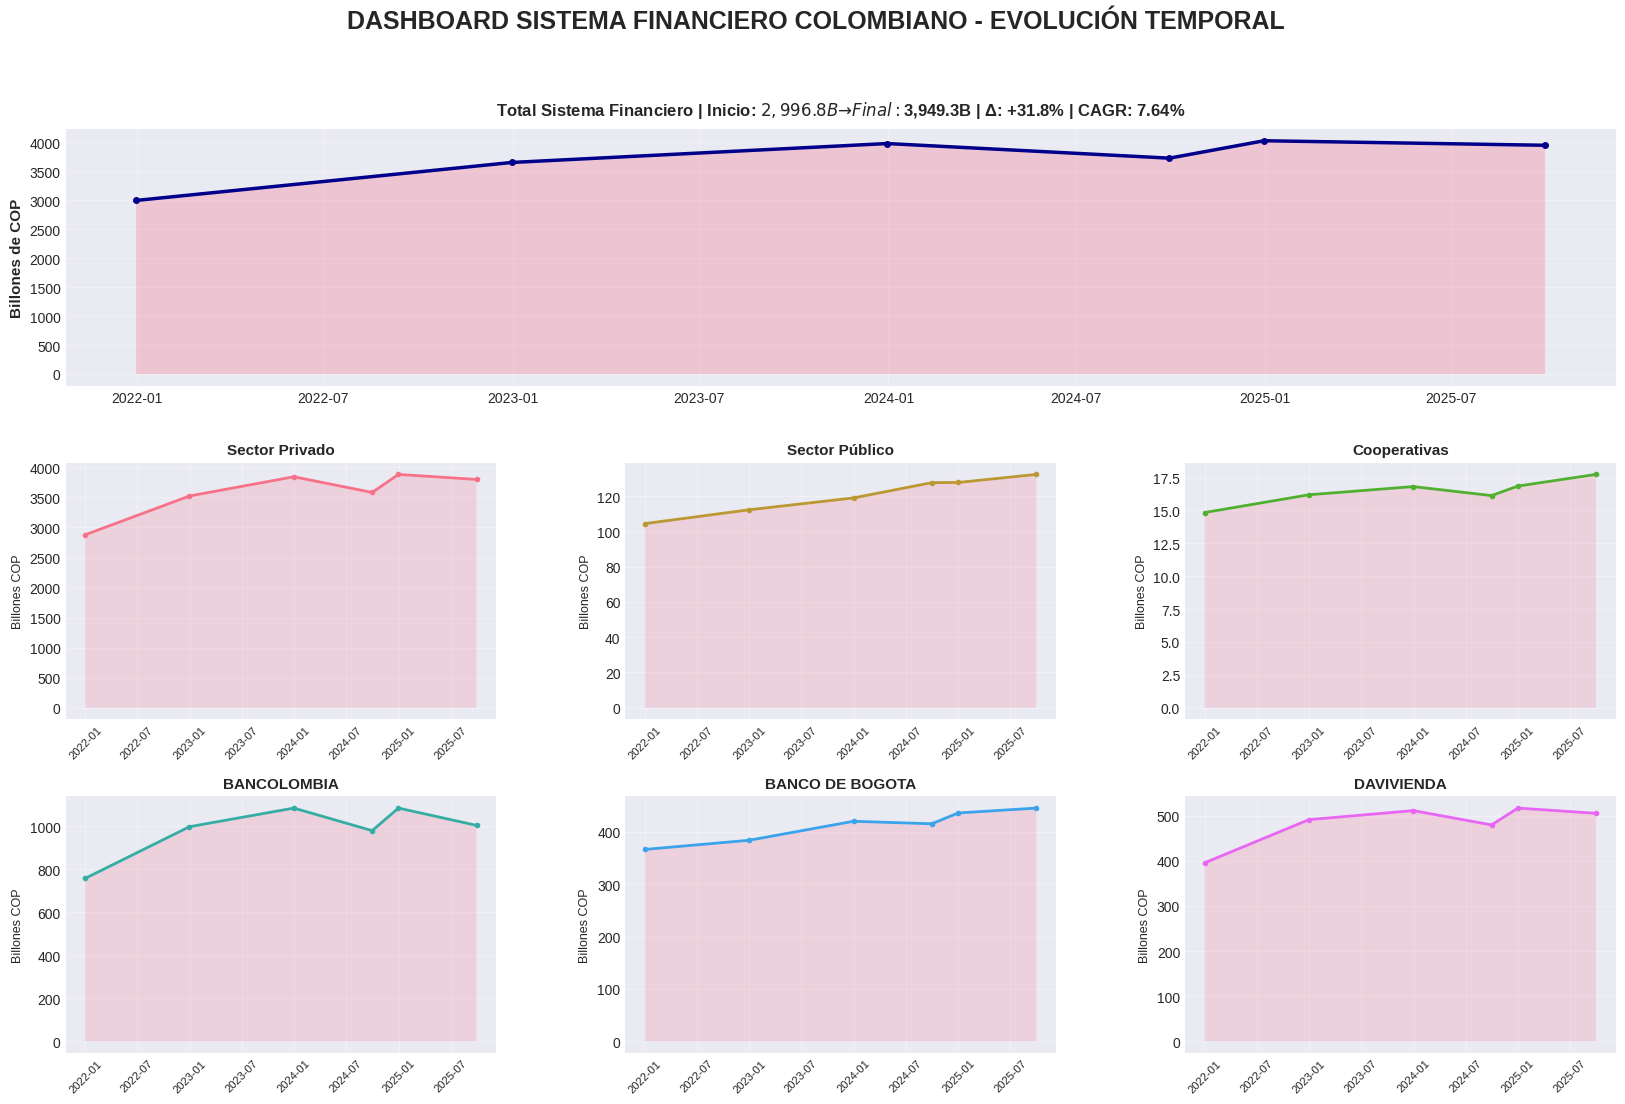

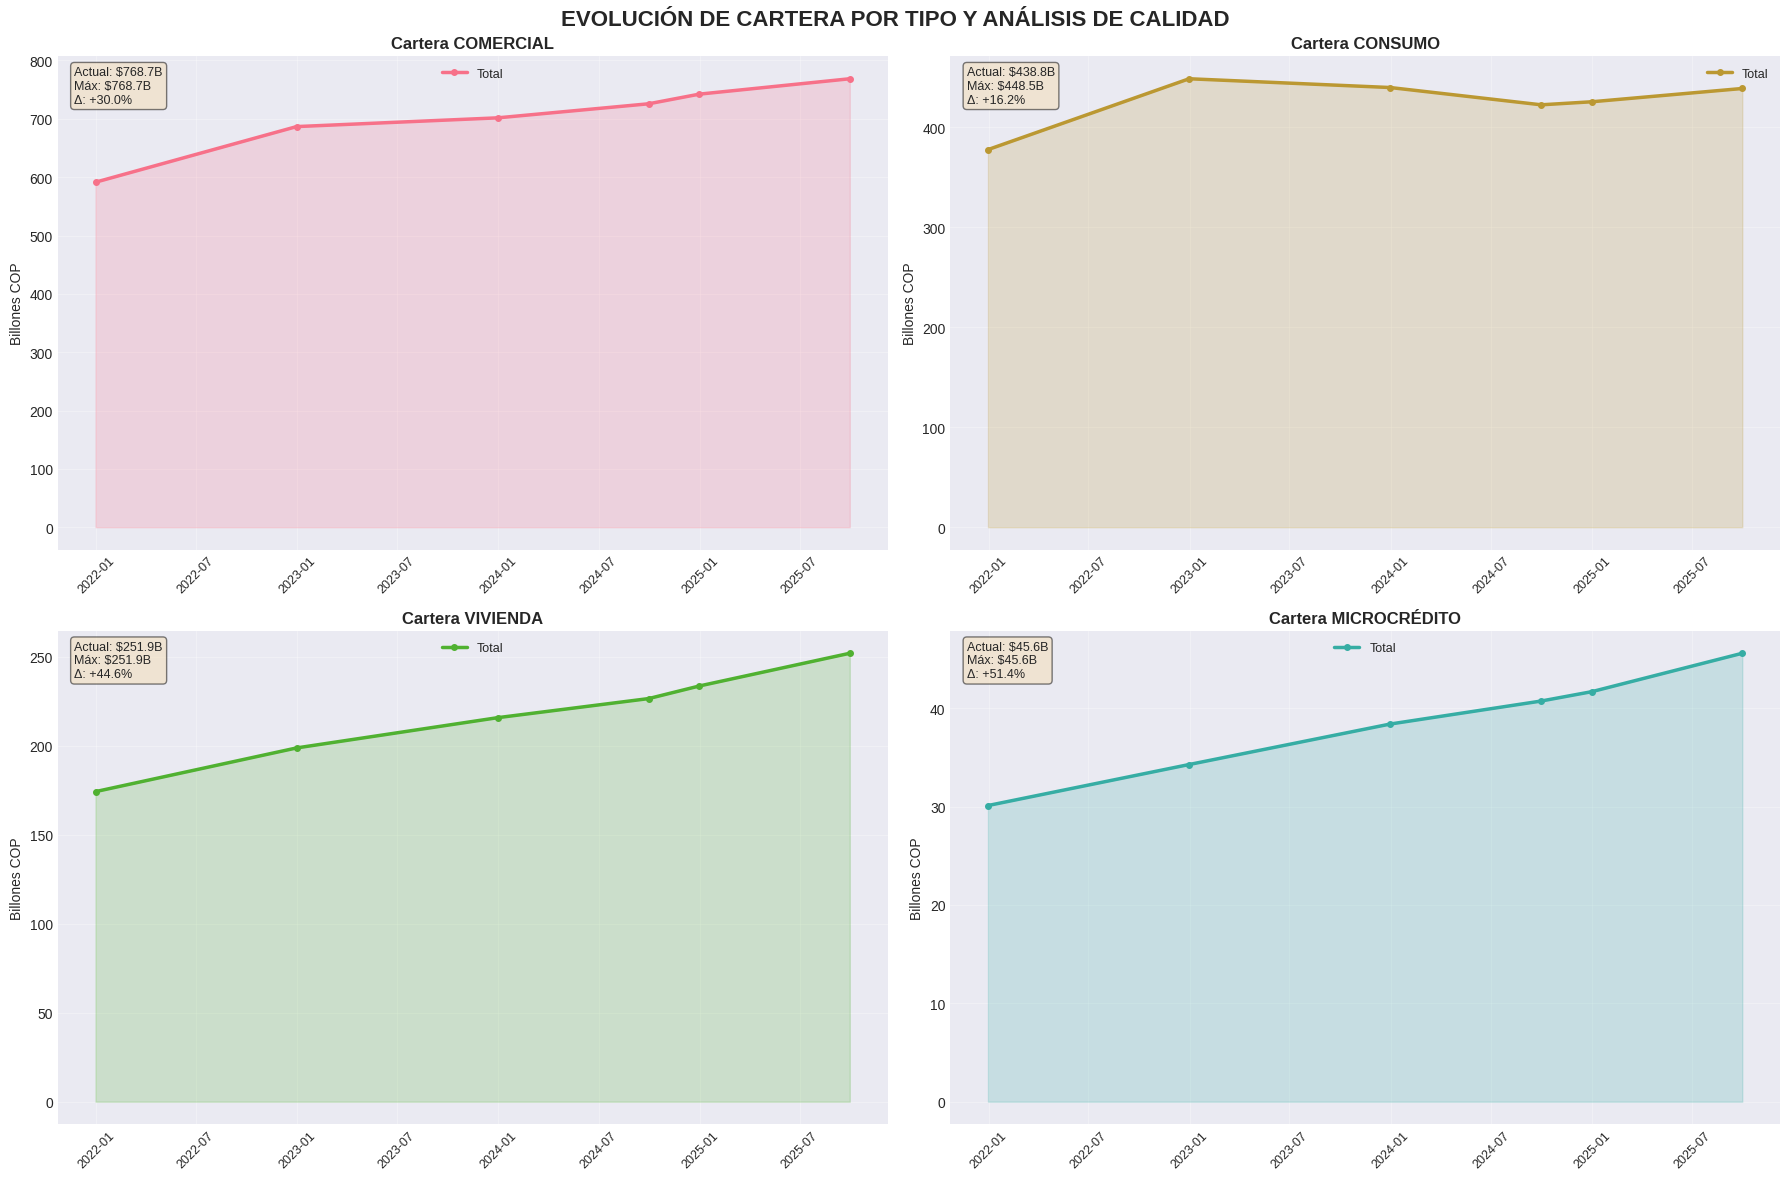

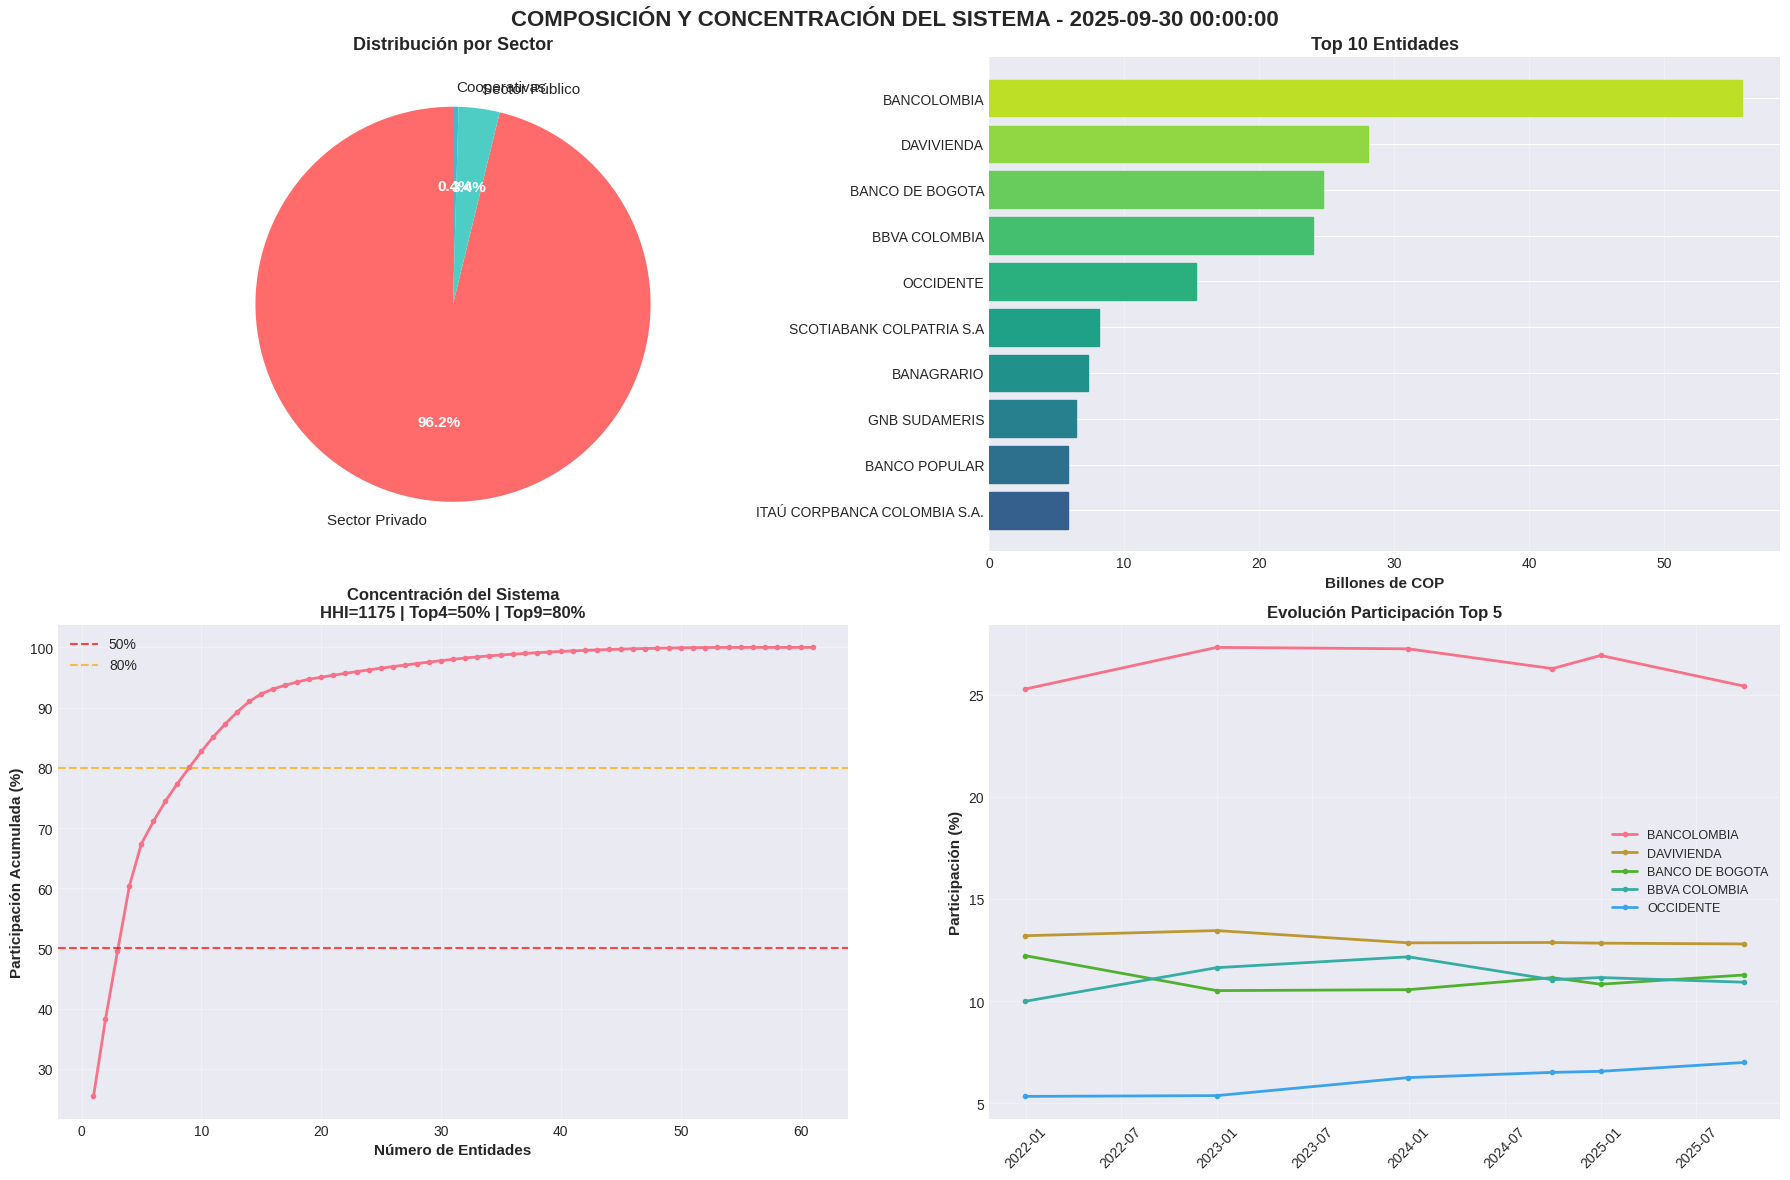

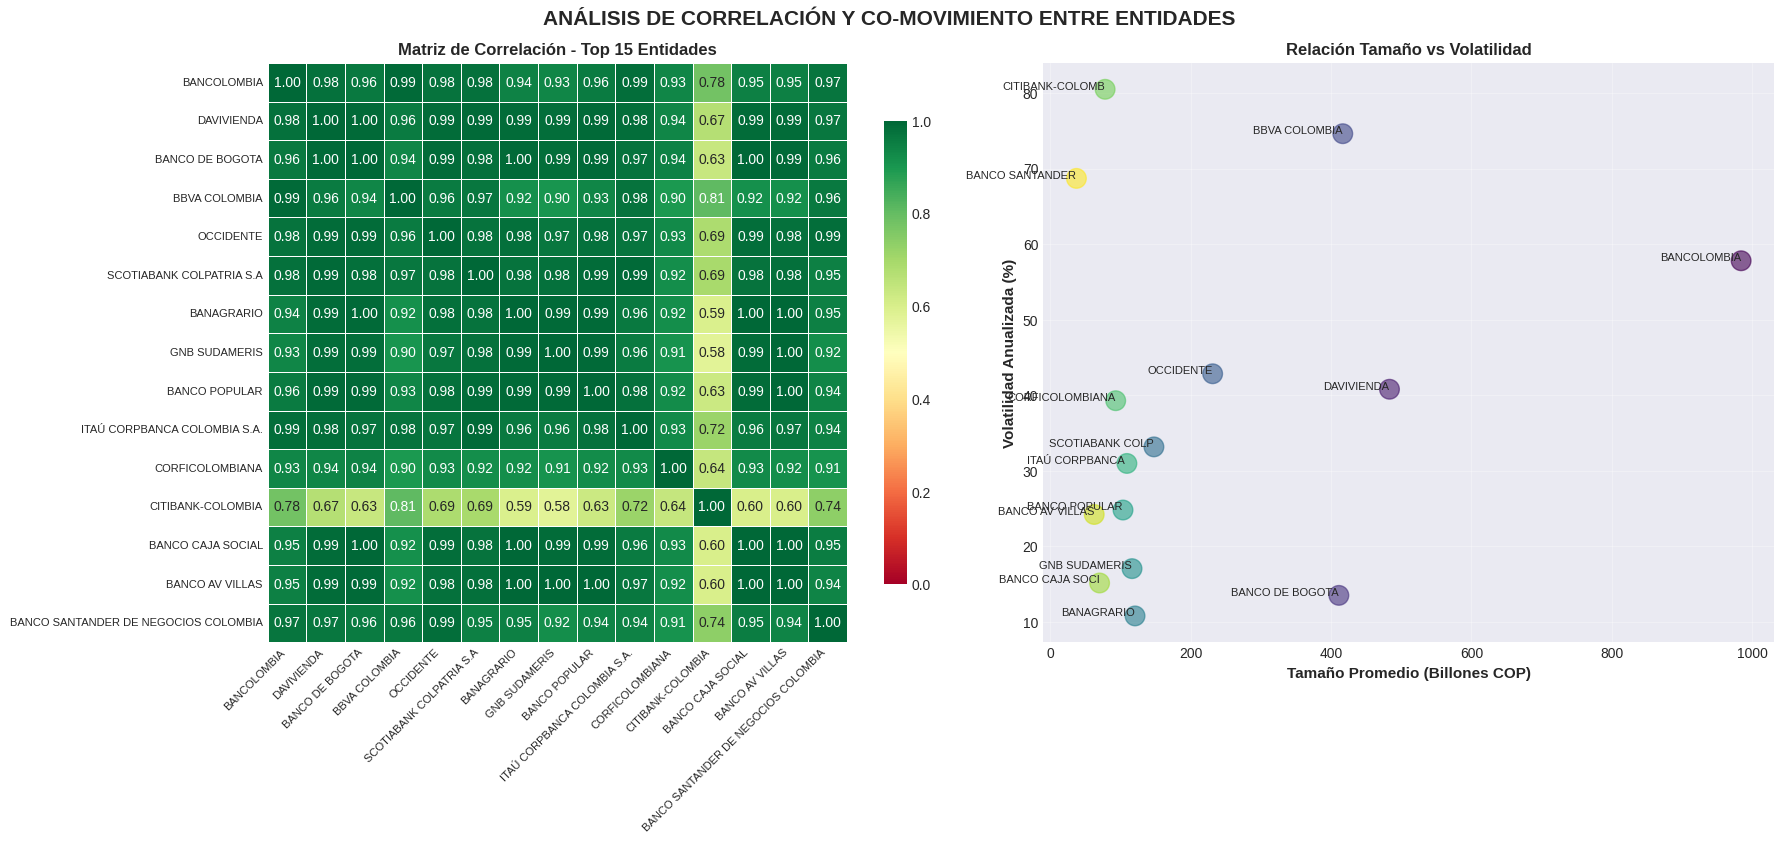

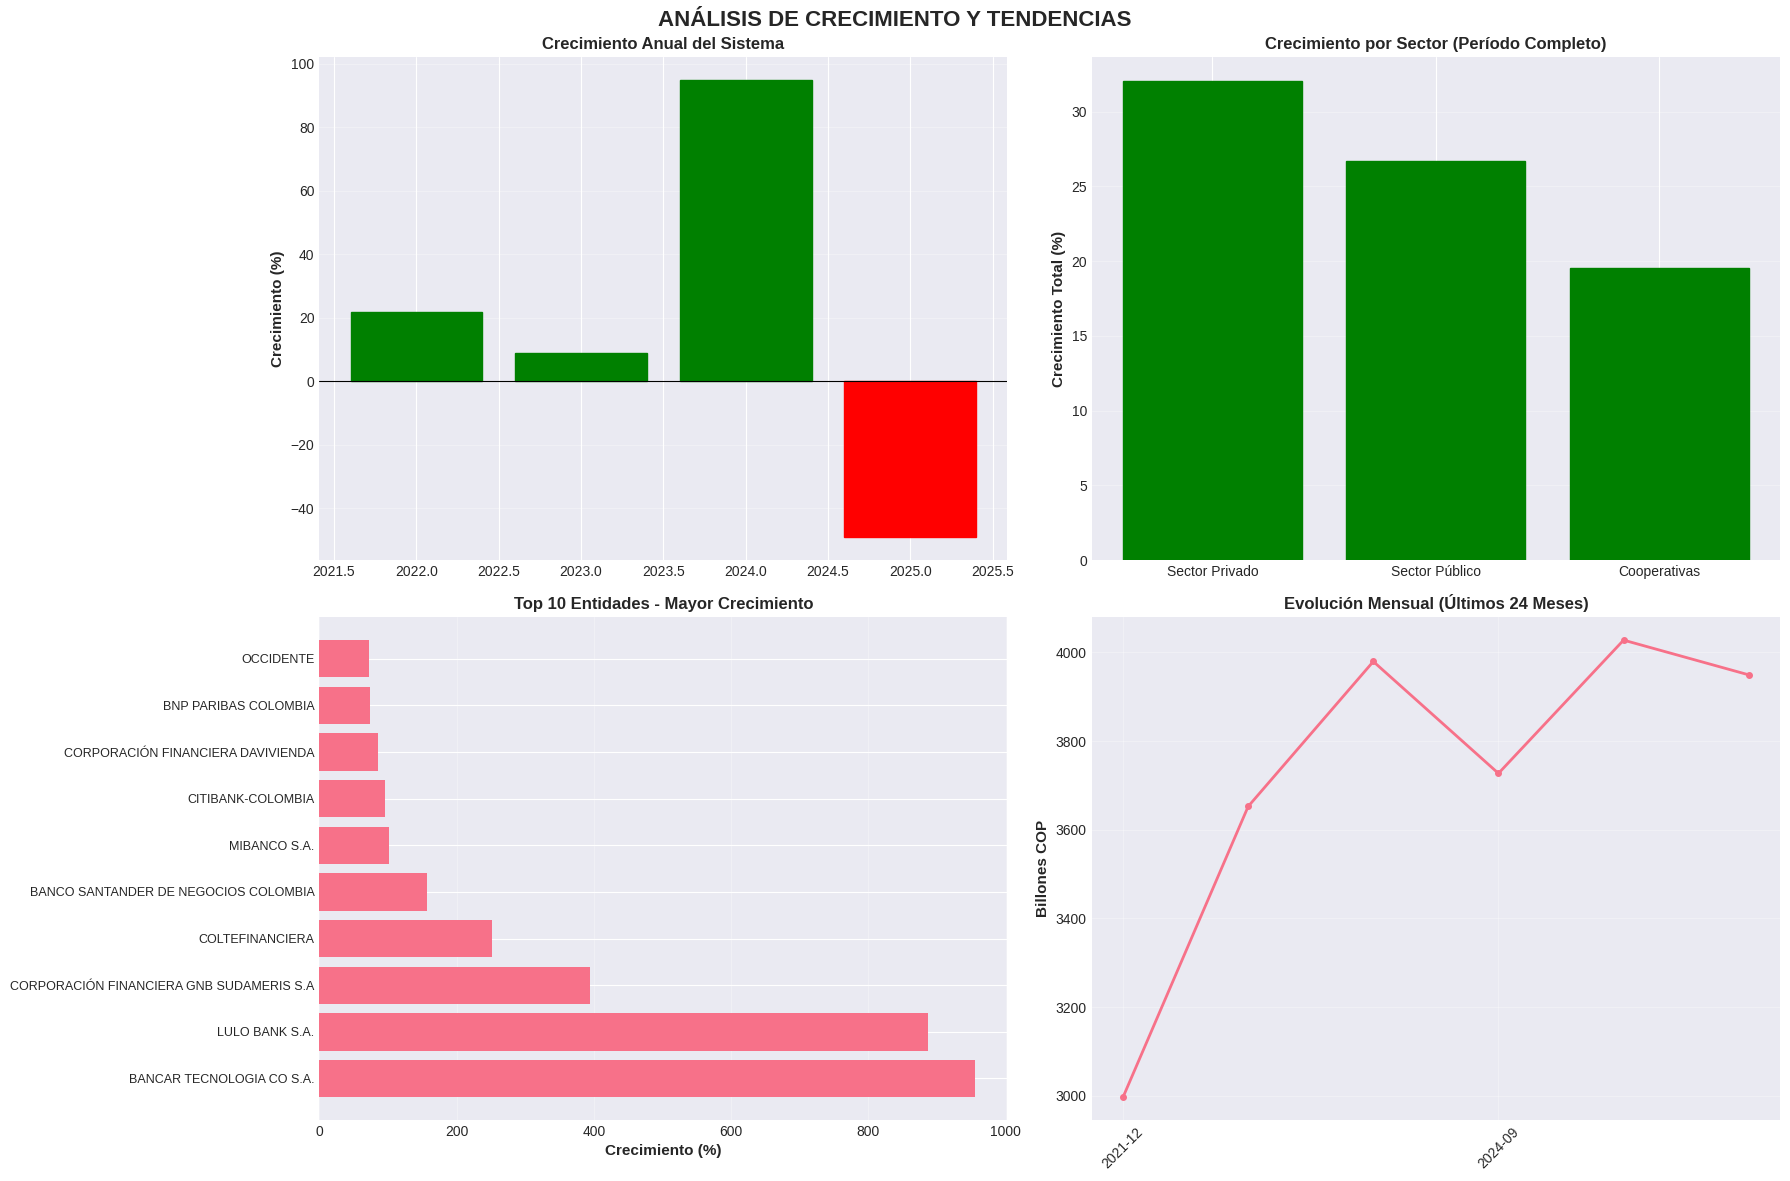



5. RESUMEN ESTADÍSTICO FINAL

TOTAL SISTEMA FINANCIERO:
  Valor Actual: $3,949.25 Billones COP
  Valor Promedio: $3,722.07 Billones COP
  Valor Máximo: $4,027.58 Billones COP
  Crecimiento Total: +31.78%
  CAGR: 7.64%


CONCENTRACIÓN:
  HHI: 1175
  Top 3 concentran: 49.49%
  Top 5 concentran: 67.40%
  Top 10 concentran: 82.71%


ANÁLISIS COMPLETADO EXITOSAMENTE

Archivos generados:
  1. 01_dashboard_evolucion_temporal.png
  2. 02_analisis_cartera_detallado.png
  3. 03_composicion_concentracion.png
  4. 04_correlacion_volatilidad.png
  5. 05_analisis_crecimiento.png



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("="*100)
print(" "*30 + "EDA PROFUNDO - SISTEMA FINANCIERO COLOMBIANO")
print("="*100)

# ============================================================================
# 1. ANÁLISIS DE LA ESTRUCTURA JERÁRQUICA
# ============================================================================
print("\n" + "="*100)
print("1. ESTRUCTURA JERÁRQUICA DEL DATASET")
print("="*100)

# Crear columnas temporales
df_ig['año'] = pd.to_datetime(df_ig['date']).dt.year
df_ig['mes'] = pd.to_datetime(df_ig['date']).dt.month
df_ig['año_mes'] = df_ig['date'].dt.to_period('M')

# Análisis de niveles jerárquicos
print(f"\nPeríodo: {df_ig['date'].min()} a {df_ig['date'].max()}")
print(f"Total registros: {len(df_ig):,}")

# Nivel 1: Totales principales (Rubros)
df_rubros = df_ig[(df_ig['subrubro'] == 0) & (df_ig['detalle'] == 0)].copy()
print(f"\n└─ Nivel 1 - RUBROS (subrubro=0, detalle=0): {len(df_rubros):,} registros")
print(f"   Rubros únicos: {df_rubros['rubro'].nunique()}")

# Nivel 2: Subrubros
df_subrubros = df_ig[(df_ig['subrubro'] != 0) & (df_ig['detalle'] == 0)].copy()
print(f"\n└─ Nivel 2 - SUBRUBROS (subrubro!=0, detalle=0): {len(df_subrubros):,} registros")
print(f"   Subrubros únicos: {df_subrubros['subrubro'].nunique()}")

# Nivel 3: Detalle completo
df_detalle = df_ig[df_ig['detalle'] != 0].copy()
print(f"\n└─ Nivel 3 - DETALLE (detalle!=0): {len(df_detalle):,} registros")
print(f"   Detalles únicos: {df_detalle['detalle'].nunique()}")

# Identificar rubros principales
rubros_principales = df_rubros['rubro'].unique()
print(f"\n\nRUBROS PRINCIPALES IDENTIFICADOS ({len(rubros_principales)}):")
print("-"*100)
for i, rubro in enumerate(rubros_principales, 1):
    count = len(df_ig[df_ig['rubro'] == rubro])
    print(f"{i:2d}. {rubro:60s} ({count:,} registros)")

# ============================================================================
# 2. ANÁLISIS DE CARTERA DE CRÉDITOS (ANÁLISIS DE RIESGO)
# ============================================================================
print("\n\n" + "="*100)
print("2. ANÁLISIS PROFUNDO DE CARTERA DE CRÉDITOS")
print("="*100)

# Filtrar datos de cartera
df_cartera = df_ig[df_ig['rubro'].str.contains('CARTERA', na=False, case=False)].copy()
print(f"\nRegistros de cartera encontrados: {len(df_cartera):,}")

# Identificar tipos de cartera
tipos_cartera = ['COMERCIAL', 'CONSUMO', 'VIVIENDA', 'MICROCREDITO']
print("\nTIPOS DE CARTERA IDENTIFICADOS:")

for tipo in tipos_cartera:
    n = len(df_cartera[df_cartera['detalle'].str.contains(tipo, na=False, case=False)])
    if n > 0:
        print(f"  - {tipo:20s}: {n:,} registros")

# ============================================================================
# 3. ANÁLISIS TEMPORAL DE TOTALES PRINCIPALES
# ============================================================================
print("\n\n" + "="*100)
print("3. EVOLUCIÓN TEMPORAL - PRINCIPALES AGREGADOS")
print("="*100)

# Obtener última fecha
ultima_fecha = df_rubros['date'].max()
df_ultimo = df_rubros[df_rubros['date'] == ultima_fecha]

# Columna de agregado principal
col_principal = 'Total Entidades Establecimientos de crédito sin IOE\'S'

if col_principal in df_ultimo.columns:
    print(f"\nValores al {ultima_fecha}:")
    print(f"  Total Sistema: ${df_ultimo[col_principal].sum()/1e6:,.2f} Billones COP")

    if 'Total Sector Privado' in df_ultimo.columns:
        print(f"  Sector Privado: ${df_ultimo['Total Sector Privado'].sum()/1e6:,.2f} Billones COP")
    if 'Total Sector Público' in df_ultimo.columns:
        print(f"  Sector Público: ${df_ultimo['Total Sector Público'].sum()/1e6:,.2f} Billones COP")

# ============================================================================
# 4. ANÁLISIS DE ENTIDADES BANCARIAS
# ============================================================================
print("\n\n" + "="*100)
print("4. RANKING DE ENTIDADES BANCARIAS")
print("="*100)

# Identificar columnas de bancos
entidades_cols = [col for col in df_rubros.columns if col not in
                  ['idx', 'date', 'rubro', 'subrubro', 'detalle', 'año', 'mes', 'año_mes']
                  and not col.startswith('Total') and not col.startswith('Bancos')
                  and not col.startswith('CFIs') and not col.startswith('CFs')]

print(f"\nEntidades individuales identificadas: {len(entidades_cols)}")

# Top 15 bancos
if len(entidades_cols) > 0:
    valores_promedio = df_ultimo[entidades_cols].mean().sort_values(ascending=False)
    print(f"\nTOP 15 ENTIDADES (valores al {ultima_fecha}):")
    print("-"*100)
    for i, (ent, val) in enumerate(valores_promedio.head(15).items(), 1):
        participacion = (val / df_ultimo[col_principal].sum()) * 100 if col_principal in df_ultimo.columns else 0
        print(f"{i:2d}. {ent:50s} ${val/1e6:10,.2f}B  ({participacion:5.2f}%)")

# ============================================================================
# VISUALIZACIONES AVANZADAS
# ============================================================================

# FIGURA 1: Dashboard Principal - Evolución Temporal
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('DASHBOARD SISTEMA FINANCIERO COLOMBIANO - EVOLUCIÓN TEMPORAL',
             fontsize=18, fontweight='bold', y=0.98)

# 1.1: Total Sistema
ax1 = fig.add_subplot(gs[0, :])
if col_principal in df_rubros.columns:
    data_temporal = df_rubros.groupby('date')[col_principal].sum().reset_index()
    ax1.plot(data_temporal['date'], data_temporal[col_principal]/1e6,
            marker='o', linewidth=2.5, markersize=4, color='darkblue')
    ax1.fill_between(data_temporal['date'], data_temporal[col_principal]/1e6, alpha=0.3)

    # Calcular crecimiento
    val_ini = data_temporal[col_principal].iloc[0]/1e6
    val_fin = data_temporal[col_principal].iloc[-1]/1e6
    var_pct = ((val_fin - val_ini) / val_ini) * 100
    cagr = (((val_fin/val_ini)**(1/((data_temporal['date'].iloc[-1] - data_temporal['date'].iloc[0]).days/365))) - 1) * 100

    ax1.set_title(f'Total Sistema Financiero | Inicio: ${val_ini:,.1f}B → Final: ${val_fin:,.1f}B | Δ: {var_pct:+.1f}% | CAGR: {cagr:.2f}%',
                 fontweight='bold', fontsize=12, pad=10)
    ax1.set_ylabel('Billones de COP', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)

# 1.2-1.4: Sectores
sectores_data = {
    'Sector Privado': 'Total Sector Privado',
    'Sector Público': 'Total Sector Público',
    'Cooperativas': 'Total Sector Cooperativas'
}

for idx, (nombre, col) in enumerate(sectores_data.items()):
    ax = fig.add_subplot(gs[1, idx])
    if col in df_rubros.columns:
        data_temporal = df_rubros.groupby('date')[col].sum().reset_index()
        ax.plot(data_temporal['date'], data_temporal[col]/1e6,
               marker='o', linewidth=2, markersize=3, color=f'C{idx}')
        ax.fill_between(data_temporal['date'], data_temporal[col]/1e6, alpha=0.2)
        ax.set_title(nombre, fontweight='bold', fontsize=11)
        ax.set_ylabel('Billones COP', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

# 1.5-1.7: Top 3 Bancos
top_bancos = ['BANCOLOMBIA', 'BANCO DE BOGOTA', 'DAVIVIENDA']
for idx, banco in enumerate(top_bancos):
    ax = fig.add_subplot(gs[2, idx])
    if banco in df_rubros.columns:
        data_temporal = df_rubros.groupby('date')[banco].sum().reset_index()
        ax.plot(data_temporal['date'], data_temporal[banco]/1e6,
               marker='o', linewidth=2, markersize=3, color=f'C{idx+3}')
        ax.fill_between(data_temporal['date'], data_temporal[banco]/1e6, alpha=0.2)
        ax.set_title(banco, fontweight='bold', fontsize=11)
        ax.set_ylabel('Billones COP', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.savefig('01_dashboard_evolucion_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 2: Análisis de Cartera por Tipo
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('EVOLUCIÓN DE CARTERA POR TIPO Y ANÁLISIS DE CALIDAD',
             fontsize=16, fontweight='bold')

tipos_cartera_busqueda = {
    'COMERCIAL': ['COMERCIAL', 'COMERCIALES'],
    'CONSUMO': ['CONSUMO'],
    'VIVIENDA': ['VIVIENDA', 'HABITACIONAL'],
    'MICROCRÉDITO': ['MICROCREDITO', 'MICROCRÉDITO']
}

col_analisis = col_principal if col_principal in df_ig.columns else list(df_ig.select_dtypes(include=[np.number]).columns)[0]

for idx, (tipo, busquedas) in enumerate(tipos_cartera_busqueda.items()):
    ax = axes[idx//2, idx%2]

    # Buscar cartera de este tipo
    df_tipo = df_cartera.copy()
    for busqueda in busquedas:
        mask = (df_tipo['detalle'].str.contains(busqueda, na=False, case=False) |
                df_tipo['subrubro'].str.contains(busqueda, na=False, case=False) |
                df_tipo['rubro'].str.contains(busqueda, na=False, case=False))
        if mask.any():
            df_tipo = df_tipo[mask]
            break

    if len(df_tipo) > 0 and col_analisis in df_tipo.columns:
        # Datos temporales
        data_temporal = df_tipo.groupby('date')[col_analisis].sum().reset_index()

        if len(data_temporal) > 0 and data_temporal[col_analisis].sum() > 0:
            # Línea principal
            ax.plot(data_temporal['date'], data_temporal[col_analisis]/1e6,
                   marker='o', linewidth=2.5, markersize=4, color=f'C{idx}', label='Total')
            ax.fill_between(data_temporal['date'], data_temporal[col_analisis]/1e6,
                          alpha=0.2, color=f'C{idx}')

            # Buscar cartera vencida
            df_vencida = df_tipo[df_tipo['detalle'].str.contains('VENCID', na=False, case=False)]
            if len(df_vencida) > 0:
                data_vencida = df_vencida.groupby('date')[col_analisis].sum().reset_index()
                if len(data_vencida) > 0:
                    ax.plot(data_vencida['date'], data_vencida[col_analisis]/1e6,
                          marker='s', linewidth=1.5, markersize=3,
                          color='red', alpha=0.7, label='Vencida')

            # Estadísticas
            val_actual = data_temporal[col_analisis].iloc[-1]/1e6
            val_max = data_temporal[col_analisis].max()/1e6
            crecimiento = ((data_temporal[col_analisis].iloc[-1] - data_temporal[col_analisis].iloc[0]) /
                          data_temporal[col_analisis].iloc[0]) * 100

            ax.set_title(f'Cartera {tipo}', fontweight='bold', fontsize=12)
            ax.set_ylabel('Billones COP', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
            ax.tick_params(axis='x', rotation=45, labelsize=9)

            # Anotaciones
            textstr = f'Actual: ${val_actual:,.1f}B\nMáx: ${val_max:,.1f}B\nΔ: {crecimiento:+.1f}%'
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round',
                   facecolor='wheat', alpha=0.5), fontsize=9)
        else:
            ax.text(0.5, 0.5, f'Sin datos para\nCartera {tipo}',
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
    else:
        ax.text(0.5, 0.5, f'Sin datos para\nCartera {tipo}',
               ha='center', va='center', transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('02_analisis_cartera_detallado.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 3: Composición y Concentración
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'COMPOSICIÓN Y CONCENTRACIÓN DEL SISTEMA - {ultima_fecha}',
             fontsize=16, fontweight='bold')

# 3.1: Distribución por Sectores
ax1 = axes[0, 0]
sectores_valores = {}
for nombre, col in sectores_data.items():
    if col in df_ultimo.columns:
        sectores_valores[nombre] = df_ultimo[col].sum()

if sectores_valores:
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    wedges, texts, autotexts = ax1.pie(sectores_valores.values(),
                                        labels=sectores_valores.keys(),
                                        autopct='%1.1f%%', colors=colors,
                                        startangle=90, textprops={'fontsize': 11})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax1.set_title('Distribución por Sector', fontweight='bold', fontsize=13)

# 3.2: Top 10 Entidades
ax2 = axes[0, 1]
if len(entidades_cols) > 0:
    valores_top10 = valores_promedio.head(10).sort_values()
    bars = ax2.barh(range(len(valores_top10)), valores_top10.values/1e6)

    # Colorear barras
    colors_bars = plt.cm.viridis(np.linspace(0.3, 0.9, len(valores_top10)))
    for bar, color in zip(bars, colors_bars):
        bar.set_color(color)

    ax2.set_yticks(range(len(valores_top10)))
    ax2.set_yticklabels(valores_top10.index, fontsize=10)
    ax2.set_xlabel('Billones de COP', fontsize=11, fontweight='bold')
    ax2.set_title('Top 10 Entidades', fontweight='bold', fontsize=13)
    ax2.grid(True, alpha=0.3, axis='x')

# 3.3: Concentración (Curva de Lorenz / Índice Herfindahl)
ax3 = axes[1, 0]
if len(entidades_cols) > 0:
    valores_sorted = valores_promedio.sort_values(ascending=False)
    participaciones = (valores_sorted / valores_sorted.sum()) * 100
    participaciones_acum = participaciones.cumsum()

    ax3.plot(range(1, len(participaciones_acum)+1), participaciones_acum,
            marker='o', linewidth=2, markersize=3)
    ax3.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='50%')
    ax3.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80%')

    # Calcular HHI
    hhi = (participaciones**2).sum()

    # Encontrar número de entidades para 50% y 80%
    n_50 = (participaciones_acum <= 50).sum() + 1
    n_80 = (participaciones_acum <= 80).sum() + 1

    ax3.set_xlabel('Número de Entidades', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Participación Acumulada (%)', fontsize=11, fontweight='bold')
    ax3.set_title(f'Concentración del Sistema\nHHI={hhi:.0f} | Top{n_50}=50% | Top{n_80}=80%',
                 fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

# 3.4: Evolución de Participación Top 5
ax4 = axes[1, 1]
if len(entidades_cols) > 0:
    top5_bancos = valores_promedio.head(5).index.tolist()

    for banco in top5_bancos:
        if banco in df_rubros.columns:
            data_banco = df_rubros.groupby('date')[banco].sum()
            data_total = df_rubros.groupby('date')[col_principal].sum()
            participacion = (data_banco / data_total) * 100
            ax4.plot(participacion.index, participacion.values,
                    marker='o', linewidth=2, markersize=3, label=banco[:20])

    ax4.set_ylabel('Participación (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Evolución Participación Top 5', fontweight='bold', fontsize=12)
    ax4.legend(fontsize=9, loc='best')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('03_composicion_concentracion.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 4: Matriz de Correlación y Análisis de Co-movimiento
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('ANÁLISIS DE CORRELACIÓN Y CO-MOVIMIENTO ENTRE ENTIDADES',
             fontsize=15, fontweight='bold')

if len(entidades_cols) > 0:
    # 4.1: Heatmap de correlación
    ax1 = axes[0]
    top_15 = valores_promedio.head(15).index.tolist()
    df_corr = df_rubros[top_15].corr()

    sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                ax=ax1, vmin=0, vmax=1)
    ax1.set_title('Matriz de Correlación - Top 15 Entidades',
                 fontweight='bold', fontsize=12)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=8)

    # 4.2: Volatilidad vs Tamaño
    ax2 = axes[1]
    volatilidades = []
    tamaños = []
    nombres = []

    for banco in top_15:
        if banco in df_rubros.columns:
            data = df_rubros.groupby('date')[banco].sum()
            if len(data) > 1:
                retornos = data.pct_change().dropna()
                vol = retornos.std() * np.sqrt(12) * 100  # Volatilidad anualizada
                tamaño = data.mean() / 1e6

                volatilidades.append(vol)
                tamaños.append(tamaño)
                nombres.append(banco)

    scatter = ax2.scatter(tamaños, volatilidades, s=200, alpha=0.6,
                         c=range(len(tamaños)), cmap='viridis')

    for i, nombre in enumerate(nombres):
        ax2.annotate(nombre[:15], (tamaños[i], volatilidades[i]),
                    fontsize=8, ha='right')

    ax2.set_xlabel('Tamaño Promedio (Billones COP)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Volatilidad Anualizada (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Relación Tamaño vs Volatilidad', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_correlacion_volatilidad.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 5: Análisis de Crecimiento
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('ANÁLISIS DE CRECIMIENTO Y TENDENCIAS', fontsize=16, fontweight='bold')

# 5.1: Crecimiento Anual del Sistema
ax1 = axes[0, 0]
if col_principal in df_rubros.columns:
    crecimiento_anual = df_rubros.groupby('año')[col_principal].sum().pct_change() * 100
    bars = ax1.bar(crecimiento_anual.index, crecimiento_anual.values)

    # Colorear según positivo/negativo
    for i, (idx, val) in enumerate(crecimiento_anual.items()):
        bars[i].set_color('green' if val > 0 else 'red')

    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax1.set_ylabel('Crecimiento (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Crecimiento Anual del Sistema', fontweight='bold', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')

# 5.2: Crecimiento por Sector
ax2 = axes[0, 1]
sectores_crecimiento = {}
for nombre, col in sectores_data.items():
    if col in df_rubros.columns:
        data = df_rubros.groupby('año')[col].sum()
        if len(data) > 1:
            crec = ((data.iloc[-1] - data.iloc[0]) / data.iloc[0]) * 100
            sectores_crecimiento[nombre] = crec

if sectores_crecimiento:
    bars = ax2.bar(sectores_crecimiento.keys(), sectores_crecimiento.values())
    for i, (k, v) in enumerate(sectores_crecimiento.items()):
        bars[i].set_color('green' if v > 0 else 'red')

    ax2.set_ylabel('Crecimiento Total (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Crecimiento por Sector (Período Completo)', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')

# 5.3: Top 10 Entidades con Mayor Crecimiento
ax3 = axes[1, 0]
if len(entidades_cols) > 0:
    crecimientos_entidades = {}
    for banco in entidades_cols:
        data = df_rubros.groupby('date')[banco].sum()
        if len(data) > 1 and data.iloc[0] > 0:
            crec = ((data.iloc[-1] - data.iloc[0]) / data.iloc[0]) * 100
            crecimientos_entidades[banco] = crec

    if crecimientos_entidades:
        crec_sorted = sorted(crecimientos_entidades.items(), key=lambda x: x[1], reverse=True)[:10]
        nombres_crec = [x[0] for x in crec_sorted]
        valores_crec = [x[1] for x in crec_sorted]

        bars = ax3.barh(range(len(nombres_crec)), valores_crec)
        ax3.set_yticks(range(len(nombres_crec)))
        ax3.set_yticklabels(nombres_crec, fontsize=9)
        ax3.set_xlabel('Crecimiento (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Top 10 Entidades - Mayor Crecimiento', fontweight='bold', fontsize=12)
        ax3.grid(True, alpha=0.3, axis='x')

# 5.4: Evolución Mensual (últimos 24 meses)
ax4 = axes[1, 1]
if col_principal in df_rubros.columns:
    data_mensual = df_rubros.groupby('año_mes')[col_principal].sum()
    data_mensual_24 = data_mensual.tail(24)

    ax4.plot(range(len(data_mensual_24)), data_mensual_24.values/1e6,
            marker='o', linewidth=2, markersize=4)
    ax4.set_xticks(range(0, len(data_mensual_24), 3))
    ax4.set_xticklabels([str(x) for x in data_mensual_24.index[::3]], rotation=45)
    ax4.set_ylabel('Billones COP', fontsize=11, fontweight='bold')
    ax4.set_title('Evolución Mensual (Últimos 24 Meses)', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_analisis_crecimiento.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# RESUMEN ESTADÍSTICO FINAL
# ============================================================================
print("\n\n" + "="*100)
print("5. RESUMEN ESTADÍSTICO FINAL")
print("="*100)

if col_principal in df_rubros.columns:
    data_sistema = df_rubros.groupby('date')[col_principal].sum()

    print(f"\nTOTAL SISTEMA FINANCIERO:")
    print(f"  Valor Actual: ${data_sistema.iloc[-1]/1e6:,.2f} Billones COP")
    print(f"  Valor Promedio: ${data_sistema.mean()/1e6:,.2f} Billones COP")
    print(f"  Valor Máximo: ${data_sistema.max()/1e6:,.2f} Billones COP")
    print(f"  Crecimiento Total: {((data_sistema.iloc[-1] - data_sistema.iloc[0])/data_sistema.iloc[0]*100):+.2f}%")

    if len(data_sistema) > 1:
        años = (data_sistema.index[-1] - data_sistema.index[0]).days / 365
        cagr = (((data_sistema.iloc[-1]/data_sistema.iloc[0])**(1/años)) - 1) * 100
        print(f"  CAGR: {cagr:.2f}%")

if len(entidades_cols) > 0:
    print(f"\n\nCONCENTRACIÓN:")
    print(f"  HHI: {hhi:.0f}")
    print(f"  Top 3 concentran: {participaciones.head(3).sum():.2f}%")
    print(f"  Top 5 concentran: {participaciones.head(5).sum():.2f}%")
    print(f"  Top 10 concentran: {participaciones.head(10).sum():.2f}%")



##Emisores objetivo

                              EDA PROFUNDO - BANCOS OBJETIVO

1. ESTRUCTURA JERÁRQUICA DEL DATASET (df1)

Período: 2021-12-31 00:00:00 a 2025-09-30 00:00:00
Total registros: 3,557

└─ Nivel 1 - RUBROS (subrubro=0, detalle=0): 108 registros
   Rubros únicos: 18

└─ Nivel 2 - SUBRUBROS (subrubro!=0, detalle=0): 936 registros
   Subrubros únicos: 153

└─ Nivel 3 - DETALLE (detalle!=0): 2,513 registros
   Detalles únicos: 278


RUBROS PRINCIPALES IDENTIFICADOS (18):
----------------------------------------------------------------------------------------------------
 1. BALANCE (cifras en $ millones)                               (6 registros)
 2. ACTIVOS                                                      (516 registros)
 3. PASIVOS  Y PATRIMONIO                                        (6 registros)
 4. PASIVOS                                                      (402 registros)
 5. PATRIMONIO                                                   (126 registros)
 6. ESTADO DE PERDIDAS Y GANANC

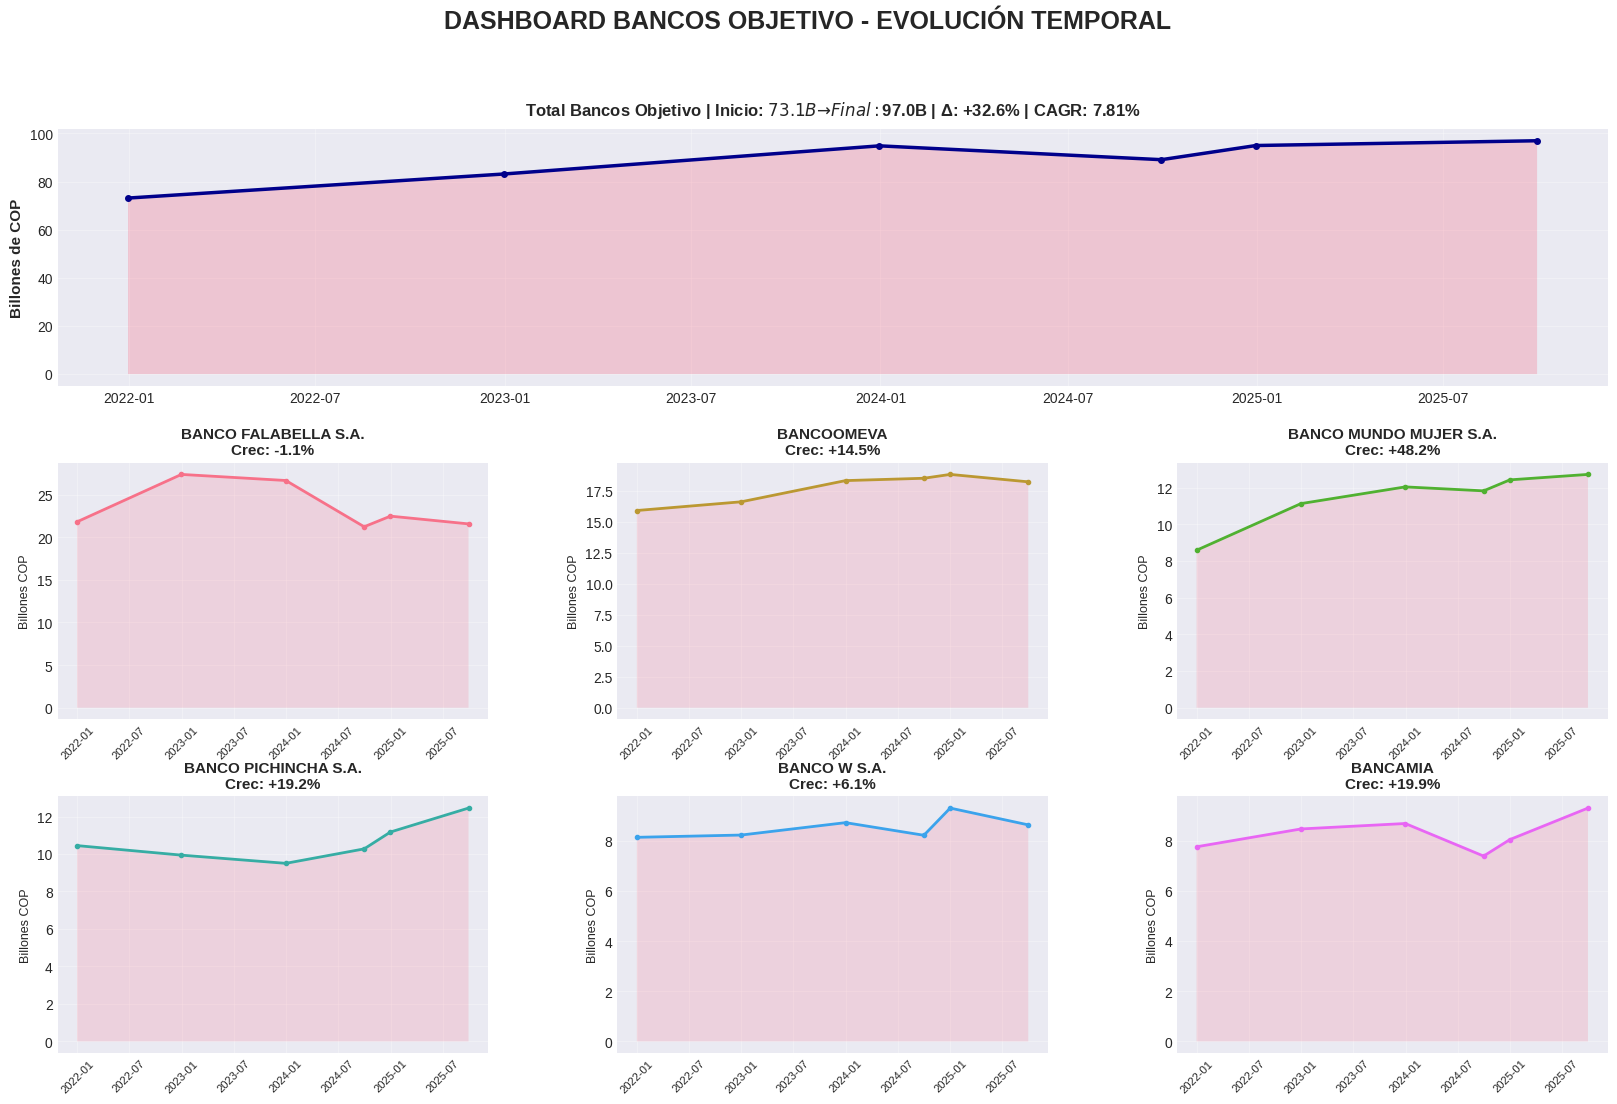

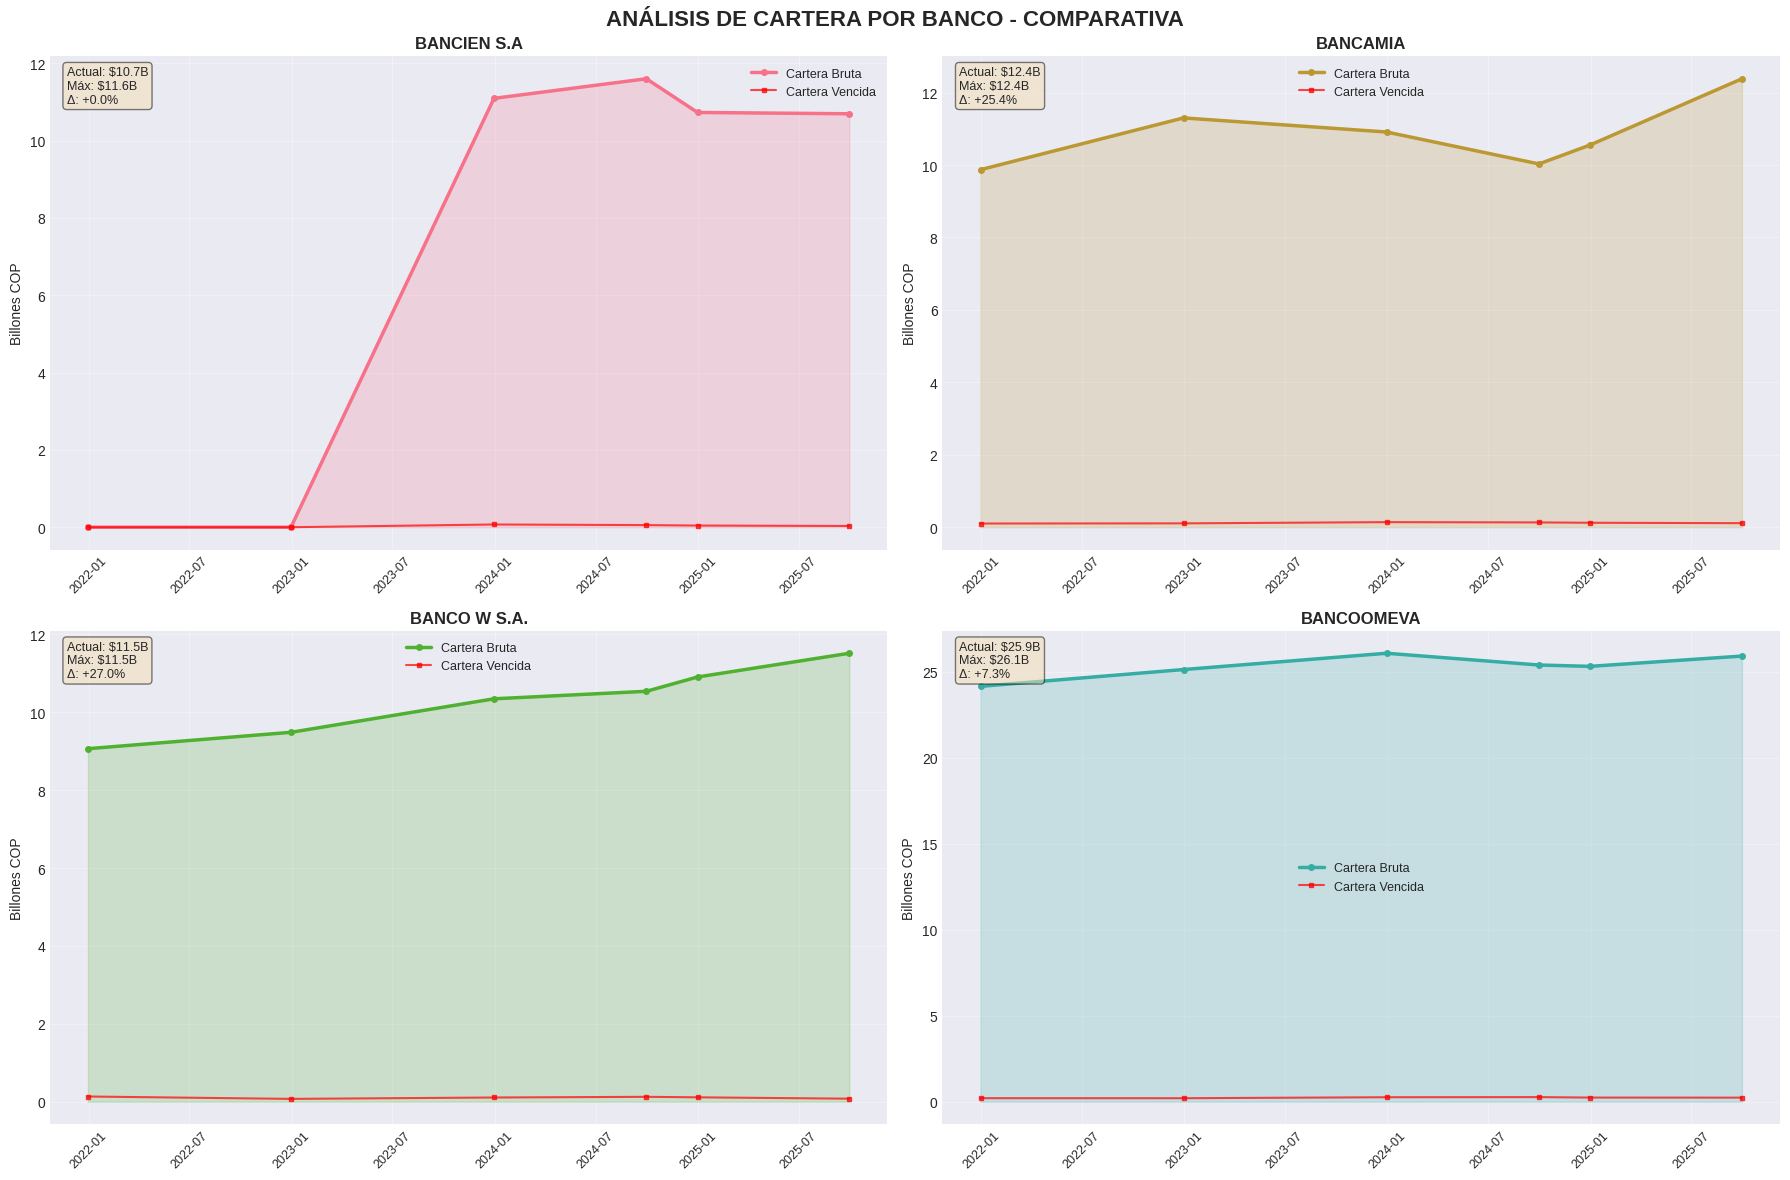

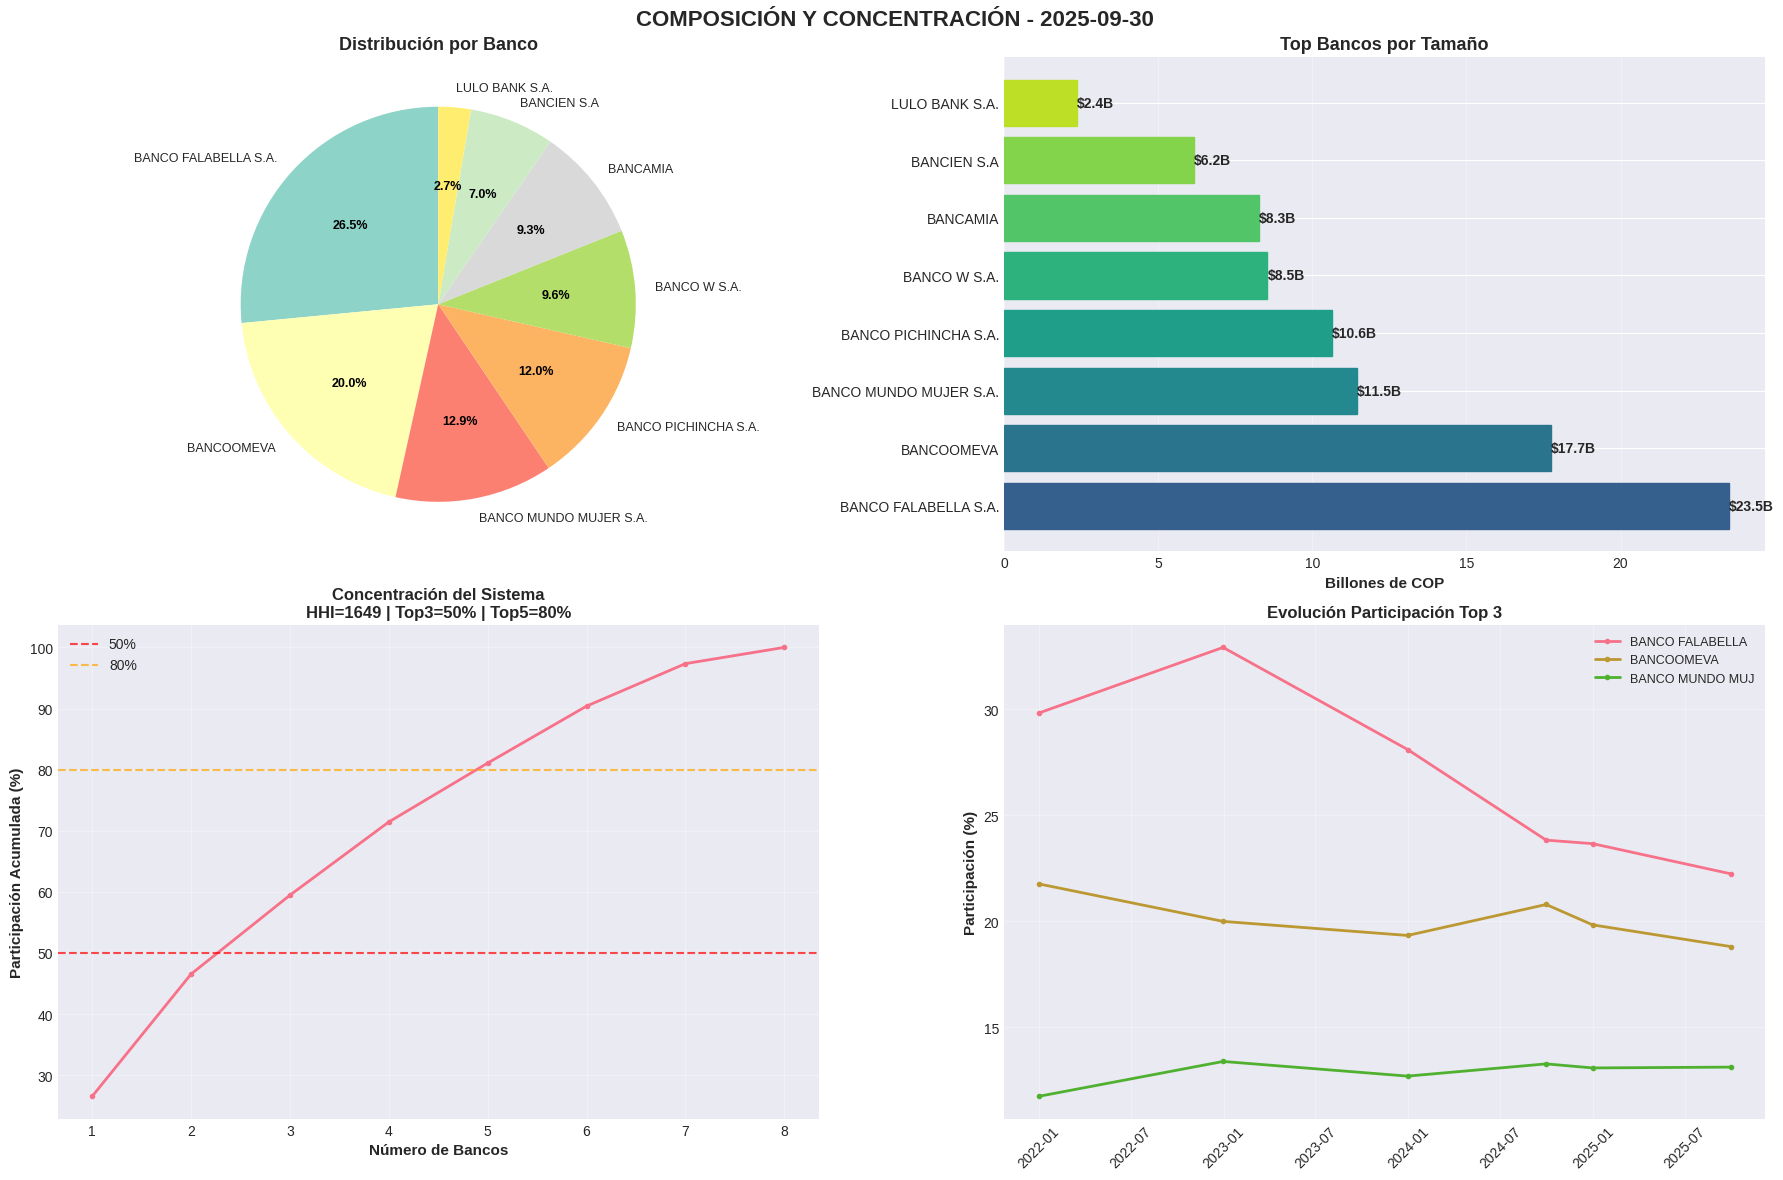

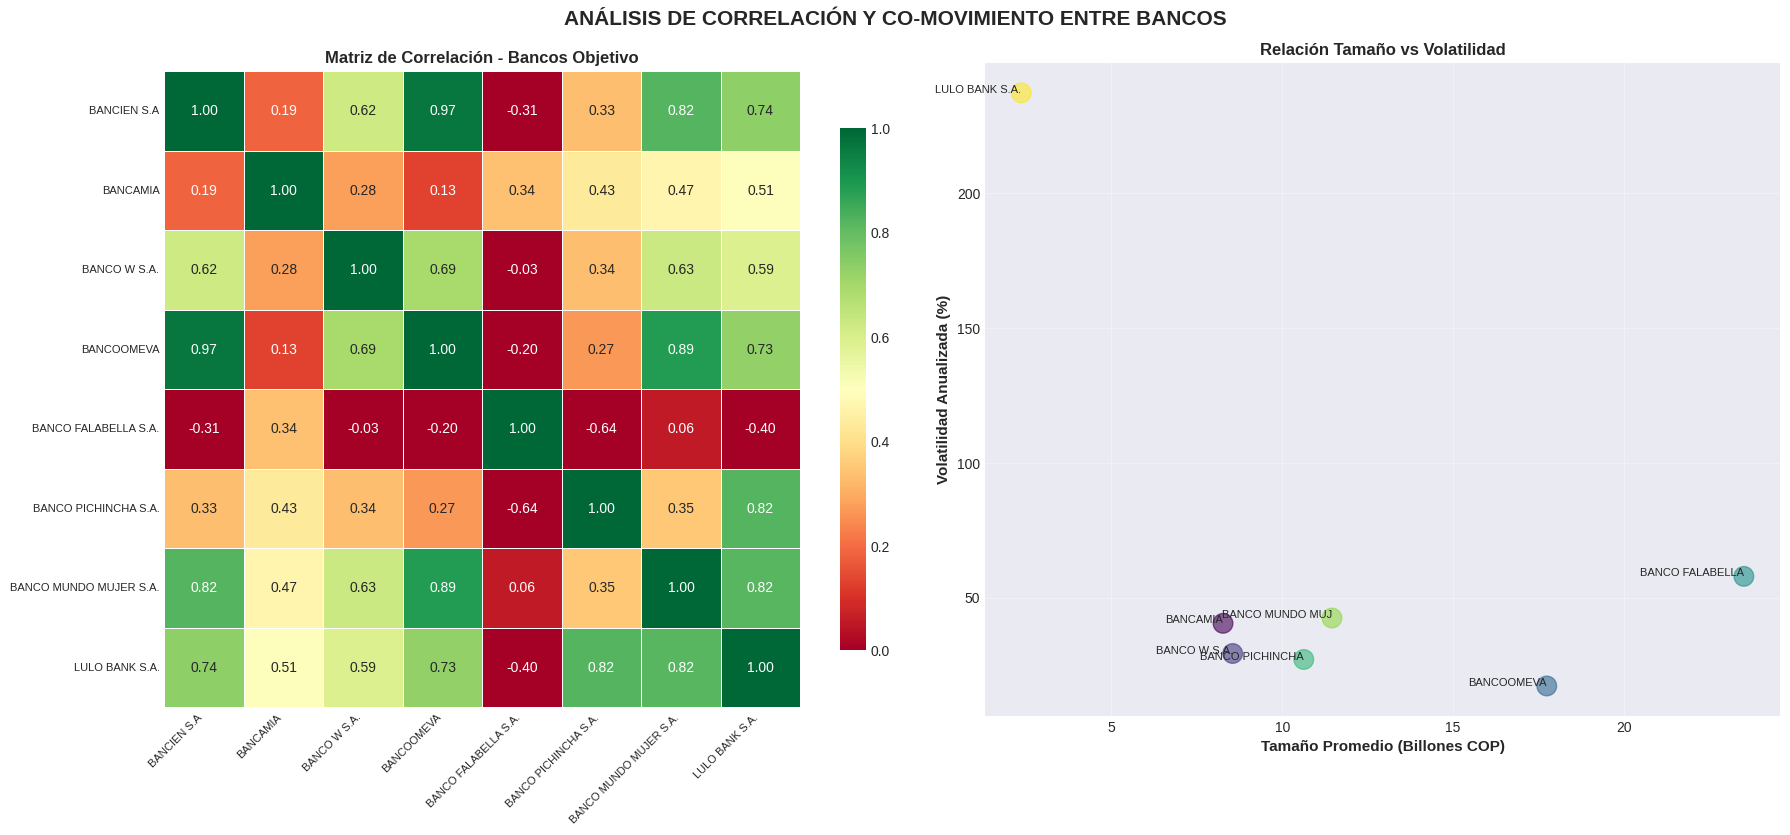

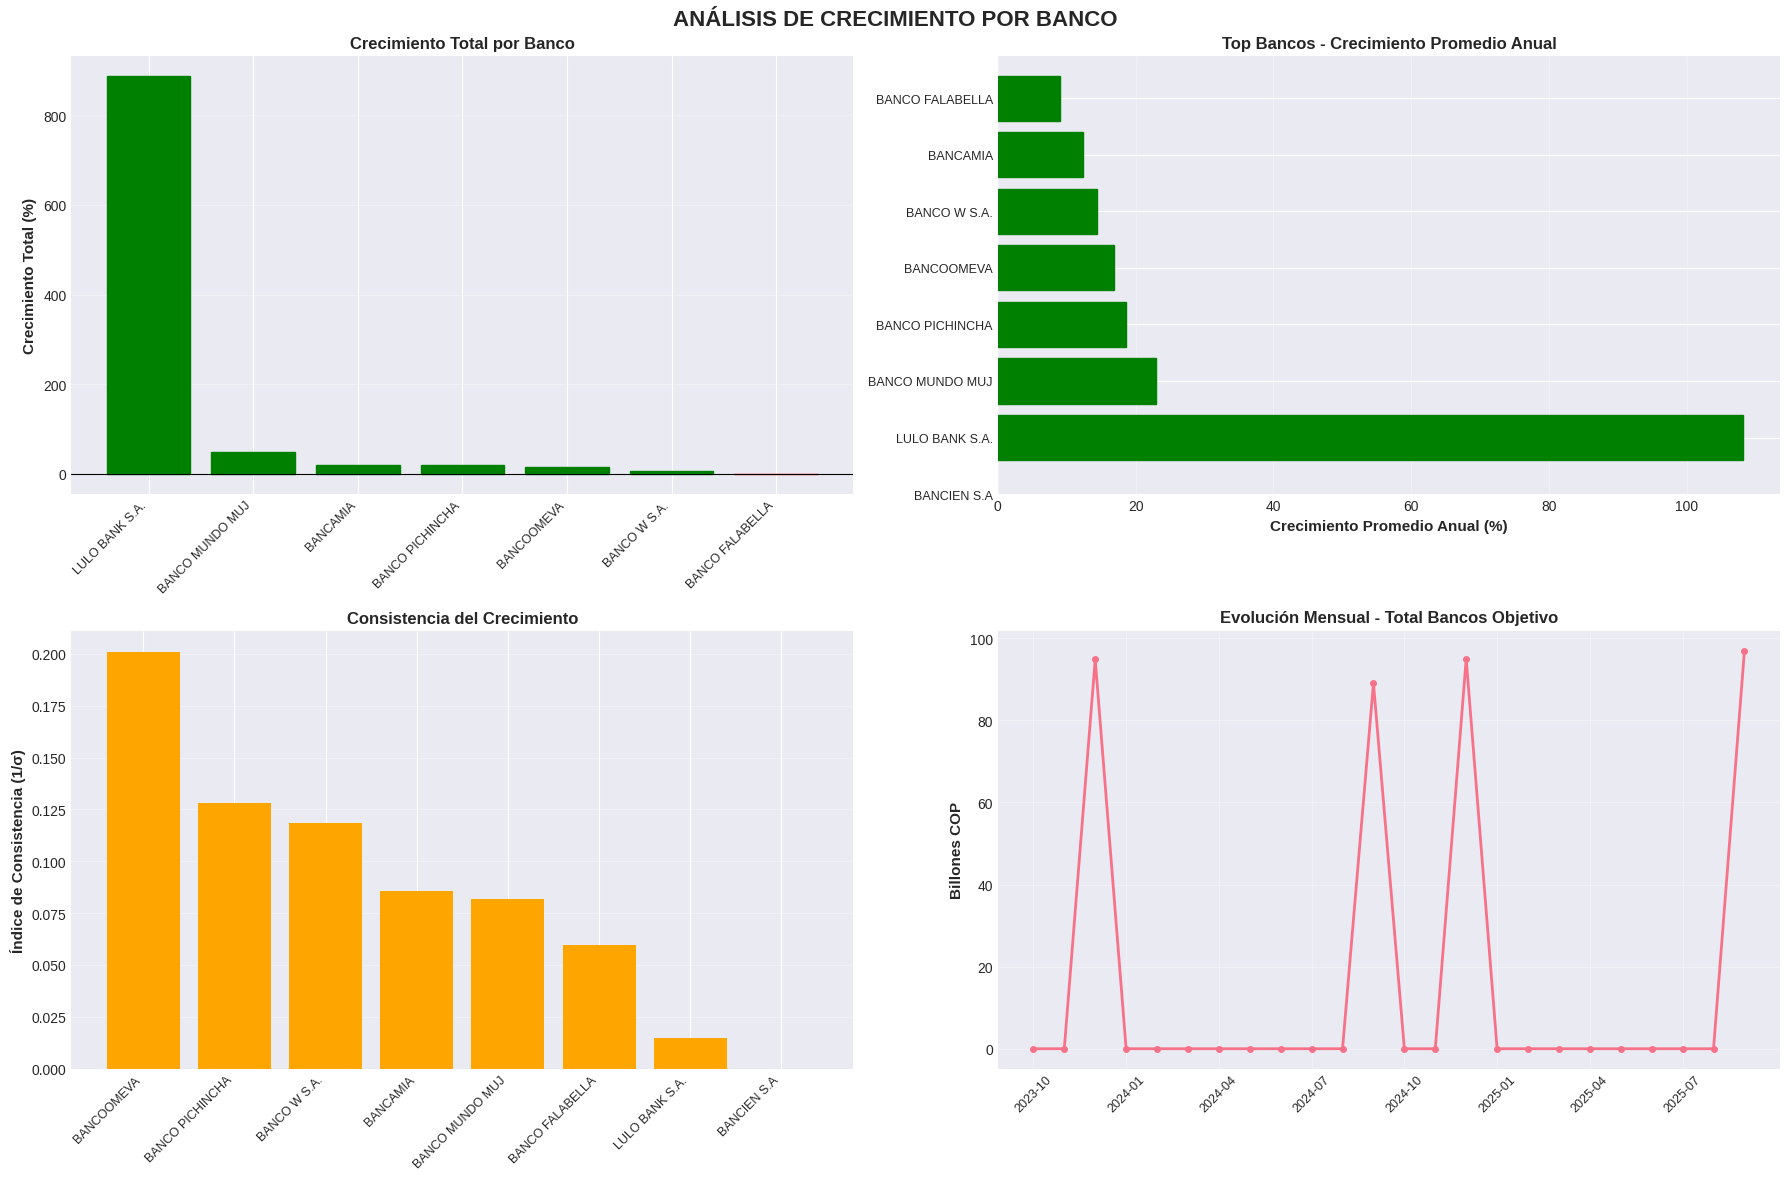



6. RESUMEN ESTADÍSTICO FINAL - BANCOS OBJETIVO

TOTAL BANCOS OBJETIVO:
  Valor Actual: $96.96 Billones COP
  Valor Promedio: $88.69 Billones COP
  Valor Máximo: $96.96 Billones COP
  Crecimiento Total: +32.57%
  CAGR: 7.81%


CONCENTRACIÓN:
  HHI: 1649
  Top 3 concentran: 54.38%
  Top 5 concentran: 74.16%


BANCO CON MAYOR CRECIMIENTO:
  LULO BANK S.A.: +887.20%


BANCO CON MAYOR ESTABILIDAD:
  BANCOOMEVA: 0.201


ANÁLISIS COMPLETADO EXITOSAMENTE

Archivos generados:
  1. 01_dashboard_bancos_objetivo.png
  2. 02_analisis_cartera_bancos.png
  3. 03_composicion_concentracion_bancos.png
  4. 04_correlacion_volatilidad_bancos.png
  5. 05_analisis_crecimiento_bancos.png



In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("="*100)
print(" "*30 + "EDA PROFUNDO - BANCOS OBJETIVO")
print("="*100)

# ============================================================================
# 1. ANÁLISIS DE LA ESTRUCTURA JERÁRQUICA
# ============================================================================
print("\n" + "="*100)
print("1. ESTRUCTURA JERÁRQUICA DEL DATASET (df1)")
print("="*100)

# Crear columnas temporales en df1
df1['date'] = pd.to_datetime(df1['date'])
df1['año'] = df1['date'].dt.year
df1['mes'] = df1['date'].dt.month
df1['año_mes'] = df1['date'].dt.to_period('M')
df1['periodo'] = df1['date'].dt.strftime('%Y-%m')

# Análisis de niveles jerárquicos
print(f"\nPeríodo: {df1['date'].min()} a {df1['date'].max()}")
print(f"Total registros: {len(df1):,}")

# Nivel 1: Totales principales (Rubros)
df_rubros = df1[(df1['subrubro'] == 0) & (df1['detalle'] == 0)].copy()
print(f"\n└─ Nivel 1 - RUBROS (subrubro=0, detalle=0): {len(df_rubros):,} registros")
print(f"   Rubros únicos: {df_rubros['rubro'].nunique()}")

# Nivel 2: Subrubros
df_subrubros = df1[(df1['subrubro'] != 0) & (df1['detalle'] == 0)].copy()
print(f"\n└─ Nivel 2 - SUBRUBROS (subrubro!=0, detalle=0): {len(df_subrubros):,} registros")
print(f"   Subrubros únicos: {df_subrubros['subrubro'].nunique()}")

# Nivel 3: Detalle completo
df_detalle = df1[df1['detalle'] != 0].copy()
print(f"\n└─ Nivel 3 - DETALLE (detalle!=0): {len(df_detalle):,} registros")
print(f"   Detalles únicos: {df_detalle['detalle'].nunique()}")

# Identificar rubros principales
rubros_principales = df_rubros['rubro'].unique()
print(f"\n\nRUBROS PRINCIPALES IDENTIFICADOS ({len(rubros_principales)}):")
print("-"*100)
for i, rubro in enumerate(rubros_principales, 1):
    count = len(df1[df1['rubro'] == rubro])
    print(f"{i:2d}. {rubro:60s} ({count:,} registros)")

# ============================================================================
# 2. ANÁLISIS DE CARTERA DE CRÉDITOS (ANÁLISIS DE RIESGO)
# ============================================================================
print("\n\n" + "="*100)
print("2. ANÁLISIS PROFUNDO DE CARTERA DE CRÉDITOS")
print("="*100)

# Filtrar datos de cartera
df_cartera = df1[df1['rubro'].str.contains('CARTERA', na=False, case=False)].copy()
print(f"\nRegistros de cartera encontrados: {len(df_cartera):,}")

# Identificar tipos de cartera
tipos_cartera = ['COMERCIAL', 'CONSUMO', 'VIVIENDA', 'MICROCREDITO']
print("\nTIPOS DE CARTERA IDENTIFICADOS:")

for tipo in tipos_cartera:
    n = len(df_cartera[df_cartera['detalle'].str.contains(tipo, na=False, case=False)])
    if n > 0:
        print(f"  - {tipo:20s}: {n:,} registros")

# ============================================================================
# 3. ANÁLISIS DE BANCOS OBJETIVO
# ============================================================================
print("\n\n" + "="*100)
print("3. BANCOS OBJETIVO - ANÁLISIS COMPARATIVO")
print("="*100)

# Definir bancos objetivo
bancos_objetivo = [
    'BANCIEN S.A',
    'BANCAMIA',
    'BANCO W S.A.',
    'BANCOOMEVA',
    'BANCO FALABELLA S.A.',
    'BANCO PICHINCHA S.A.',
    'BANCO MUNDO MUJER S.A.',
    'LULO BANK S.A.'
]

print(f"\nBancos objetivo identificados: {len(bancos_objetivo)}")
for i, banco in enumerate(bancos_objetivo, 1):
    print(f"{i:2d}. {banco}")

# ============================================================================
# 4. ANÁLISIS TEMPORAL DE TOTALES PRINCIPALES POR BANCO
# ============================================================================
print("\n\n" + "="*100)
print("4. EVOLUCIÓN TEMPORAL - BANCOS OBJETIVO")
print("="*100)

# Obtener última fecha
ultima_fecha = df_rubros['date'].max()
df_ultimo = df_rubros[df_rubros['date'] == ultima_fecha]

# Analizar cada banco
print(f"\nValores al {ultima_fecha.strftime('%Y-%m-%d')}:")
print("-"*100)

for banco in bancos_objetivo:
    if banco in df_ultimo.columns:
        valor = df_ultimo[banco].sum()
        print(f"  {banco:25s}: ${valor/1e6:10,.2f} Billones COP")

# Calcular total del sistema (suma de bancos objetivo)
total_sistema = sum([df_ultimo[banco].sum() for banco in bancos_objetivo if banco in df_ultimo.columns])
print(f"\n  {'TOTAL SISTEMA OBJETIVO':25s}: ${total_sistema/1e6:10,.2f} Billones COP")

# ============================================================================
# 5. RANKING DE BANCOS OBJETIVO
# ============================================================================
print("\n\n" + "="*100)
print("5. RANKING DE BANCOS OBJETIVO")
print("="*100)

# Filtrar solo bancos objetivo que existen en los datos
bancos_existentes = [banco for banco in bancos_objetivo if banco in df_rubros.columns]
print(f"\nBancos existentes en datos: {len(bancos_existentes)}")

if bancos_existentes:
    # Calcular valores promedio por banco
    valores_promedio = {}
    for banco in bancos_existentes:
        valores_por_periodo = df_rubros.groupby('date')[banco].sum()
        valores_promedio[banco] = valores_por_periodo.mean()

    # Ordenar por tamaño
    ranking = sorted(valores_promedio.items(), key=lambda x: x[1], reverse=True)

    print(f"\nRANKING POR TAMAÑO PROMEDIO:")
    print("-"*100)
    for i, (banco, valor) in enumerate(ranking, 1):
        participacion = (valor / total_sistema) * 100 if total_sistema > 0 else 0
        print(f"{i:2d}. {banco:25s} ${valor/1e6:10,.2f}B  ({participacion:5.2f}%)")

# ============================================================================
# VISUALIZACIONES AVANZADAS PARA BANCOS OBJETIVO
# ============================================================================

# FIGURA 1: Dashboard Principal - Evolución Temporal
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('DASHBOARD BANCOS OBJETIVO - EVOLUCIÓN TEMPORAL',
             fontsize=18, fontweight='bold', y=0.98)

# 1.1: Total Sistema Objetivo
ax1 = fig.add_subplot(gs[0, :])
total_por_fecha = pd.Series(dtype=float)

for banco in bancos_existentes:
    if banco in df_rubros.columns:
        data_banco = df_rubros.groupby('date')[banco].sum()
        if total_por_fecha.empty:
            total_por_fecha = data_banco
        else:
            total_por_fecha = total_por_fecha.add(data_banco, fill_value=0)

if not total_por_fecha.empty:
    data_temporal = total_por_fecha.reset_index()
    data_temporal.columns = ['date', 'Total_Sistema']

    ax1.plot(data_temporal['date'], data_temporal['Total_Sistema']/1e6,
            marker='o', linewidth=2.5, markersize=4, color='darkblue')
    ax1.fill_between(data_temporal['date'], data_temporal['Total_Sistema']/1e6, alpha=0.3)

    # Calcular crecimiento
    if len(data_temporal) > 1:
        val_ini = data_temporal['Total_Sistema'].iloc[0]/1e6
        val_fin = data_temporal['Total_Sistema'].iloc[-1]/1e6
        var_pct = ((val_fin - val_ini) / val_ini) * 100 if val_ini > 0 else 0
        años = (data_temporal['date'].iloc[-1] - data_temporal['date'].iloc[0]).days / 365
        cagr = (((val_fin/val_ini)**(1/años)) - 1) * 100 if val_ini > 0 and años > 0 else 0

        ax1.set_title(f'Total Bancos Objetivo | Inicio: ${val_ini:,.1f}B → Final: ${val_fin:,.1f}B | Δ: {var_pct:+.1f}% | CAGR: {cagr:.2f}%',
                     fontweight='bold', fontsize=12, pad=10)

    ax1.set_ylabel('Billones de COP', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)

# 1.2-1.4: Top 3 Bancos
top_3_bancos = ranking[:3] if len(ranking) >= 3 else ranking
for idx, (banco, _) in enumerate(top_3_bancos):
    ax = fig.add_subplot(gs[1, idx])
    if banco in df_rubros.columns:
        data_banco = df_rubros.groupby('date')[banco].sum().reset_index()
        ax.plot(data_banco['date'], data_banco[banco]/1e6,
               marker='o', linewidth=2, markersize=3, color=f'C{idx}')
        ax.fill_between(data_banco['date'], data_banco[banco]/1e6, alpha=0.2)

        # Calcular crecimiento
        if len(data_banco) > 1:
            crec = ((data_banco[banco].iloc[-1] - data_banco[banco].iloc[0]) / data_banco[banco].iloc[0]) * 100
            ax.set_title(f'{banco}\nCrec: {crec:+.1f}%', fontweight='bold', fontsize=11)
        else:
            ax.set_title(banco, fontweight='bold', fontsize=11)

        ax.set_ylabel('Billones COP', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

# 1.5-1.7: Otros 3 Bancos importantes
otros_bancos = ranking[3:6] if len(ranking) >= 6 else ranking[3:] if len(ranking) > 3 else []
for idx, (banco, _) in enumerate(otros_bancos):
    ax = fig.add_subplot(gs[2, idx])
    if banco in df_rubros.columns:
        data_banco = df_rubros.groupby('date')[banco].sum().reset_index()
        ax.plot(data_banco['date'], data_banco[banco]/1e6,
               marker='o', linewidth=2, markersize=3, color=f'C{idx+3}')
        ax.fill_between(data_banco['date'], data_banco[banco]/1e6, alpha=0.2)

        # Calcular crecimiento
        if len(data_banco) > 1:
            crec = ((data_banco[banco].iloc[-1] - data_banco[banco].iloc[0]) / data_banco[banco].iloc[0]) * 100
            ax.set_title(f'{banco}\nCrec: {crec:+.1f}%', fontweight='bold', fontsize=11)
        else:
            ax.set_title(banco, fontweight='bold', fontsize=11)

        ax.set_ylabel('Billones COP', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.savefig('01_dashboard_bancos_objetivo.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 2: Análisis de Cartera por Banco
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('ANÁLISIS DE CARTERA POR BANCO - COMPARATIVA',
             fontsize=16, fontweight='bold')

# Seleccionar 4 bancos para análisis detallado de cartera
bancos_cartera = bancos_existentes[:4] if len(bancos_existentes) >= 4 else bancos_existentes

for idx, banco in enumerate(bancos_cartera):
    ax = axes[idx//2, idx%2]

    # Filtrar cartera para este banco
    if banco in df_cartera.columns:
        # Obtener datos de cartera bruta
        df_cartera_banco = df_cartera[df_cartera['subrubro'].str.contains('BRUTO', na=False, case=False)]
        if not df_cartera_banco.empty:
            data_temporal = df_cartera_banco.groupby('date')[banco].sum().reset_index()

            if len(data_temporal) > 0 and data_temporal[banco].sum() > 0:
                # Línea principal
                ax.plot(data_temporal['date'], data_temporal[banco]/1e6,
                       marker='o', linewidth=2.5, markersize=4, color=f'C{idx}', label='Cartera Bruta')
                ax.fill_between(data_temporal['date'], data_temporal[banco]/1e6,
                              alpha=0.2, color=f'C{idx}')

                # Buscar cartera vencida
                df_vencida = df_cartera[df_cartera['detalle'].str.contains('VENCID', na=False, case=False)]
                if not df_vencida.empty and banco in df_vencida.columns:
                    data_vencida = df_vencida.groupby('date')[banco].sum().reset_index()
                    if len(data_vencida) > 0:
                        ax.plot(data_vencida['date'], data_vencida[banco]/1e6,
                              marker='s', linewidth=1.5, markersize=3,
                              color='red', alpha=0.7, label='Cartera Vencida')

                # Estadísticas
                val_actual = data_temporal[banco].iloc[-1]/1e6 if len(data_temporal) > 0 else 0
                val_max = data_temporal[banco].max()/1e6 if len(data_temporal) > 0 else 0

                if len(data_temporal) > 1 and data_temporal[banco].iloc[0] > 0:
                    crecimiento = ((data_temporal[banco].iloc[-1] - data_temporal[banco].iloc[0]) /
                                  data_temporal[banco].iloc[0]) * 100
                else:
                    crecimiento = 0

                ax.set_title(f'{banco}', fontweight='bold', fontsize=12)
                ax.set_ylabel('Billones COP', fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=9)
                ax.tick_params(axis='x', rotation=45, labelsize=9)

                # Anotaciones
                textstr = f'Actual: ${val_actual:,.1f}B\nMáx: ${val_max:,.1f}B\nΔ: {crecimiento:+.1f}%'
                ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round',
                       facecolor='wheat', alpha=0.5), fontsize=9)
            else:
                ax.text(0.5, 0.5, f'Sin datos de cartera\npara {banco}',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
        else:
            ax.text(0.5, 0.5, f'Sin datos de cartera\npara {banco}',
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
    else:
        ax.text(0.5, 0.5, f'Banco no encontrado\n{banco}',
               ha='center', va='center', transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('02_analisis_cartera_bancos.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 3: Composición y Concentración
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'COMPOSICIÓN Y CONCENTRACIÓN - {ultima_fecha.strftime("%Y-%m-%d")}',
             fontsize=16, fontweight='bold')

# 3.1: Distribución por Banco
ax1 = axes[0, 0]
if ranking:
    bancos_nombres = [banco for banco, _ in ranking]
    bancos_valores = [valor for _, valor in ranking]

    colors = plt.cm.Set3(np.linspace(0, 1, len(bancos_nombres)))
    wedges, texts, autotexts = ax1.pie(bancos_valores,
                                        labels=bancos_nombres,
                                        autopct='%1.1f%%', colors=colors,
                                        startangle=90, textprops={'fontsize': 9})
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    ax1.set_title('Distribución por Banco', fontweight='bold', fontsize=13)

# 3.2: Top Bancos por Tamaño
ax2 = axes[0, 1]
if ranking:
    top_n = min(8, len(ranking))
    top_bancos = ranking[:top_n]
    nombres_top = [banco for banco, _ in top_bancos]
    valores_top = [valor/1e6 for _, valor in top_bancos]

    bars = ax2.barh(range(len(valores_top)), valores_top)

    # Colorear barras
    colors_bars = plt.cm.viridis(np.linspace(0.3, 0.9, len(valores_top)))
    for bar, color in zip(bars, colors_bars):
        bar.set_color(color)

    ax2.set_yticks(range(len(valores_top)))
    ax2.set_yticklabels(nombres_top, fontsize=10)
    ax2.set_xlabel('Billones de COP', fontsize=11, fontweight='bold')
    ax2.set_title('Top Bancos por Tamaño', fontweight='bold', fontsize=13)
    ax2.grid(True, alpha=0.3, axis='x')

    # Añadir valores en barras
    for i, v in enumerate(valores_top):
        ax2.text(v, i, f'${v:,.1f}B', ha='left', va='center', fontweight='bold')

# 3.3: Concentración (Curva de Lorenz)
ax3 = axes[1, 0]
if ranking:
    valores_sorted = [valor for _, valor in sorted(ranking, key=lambda x: x[1], reverse=True)]
    total_valores = sum(valores_sorted)

    if total_valores > 0:
        participaciones = [(v / total_valores) * 100 for v in valores_sorted]
        participaciones_acum = np.cumsum(participaciones)

        ax3.plot(range(1, len(participaciones_acum)+1), participaciones_acum,
                marker='o', linewidth=2, markersize=3)
        ax3.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='50%')
        ax3.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80%')

        # Calcular HHI
        hhi = sum([p**2 for p in participaciones])

        # Encontrar número de bancos para 50% y 80%
        n_50 = (participaciones_acum <= 50).sum() + 1 if (participaciones_acum <= 50).any() else 1
        n_80 = (participaciones_acum <= 80).sum() + 1 if (participaciones_acum <= 80).any() else 1

        ax3.set_xlabel('Número de Bancos', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Participación Acumulada (%)', fontsize=11, fontweight='bold')
        ax3.set_title(f'Concentración del Sistema\nHHI={hhi:.0f} | Top{n_50}=50% | Top{n_80}=80%',
                     fontweight='bold', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.legend()

# 3.4: Evolución de Participación Top 3
ax4 = axes[1, 1]
if len(ranking) >= 3:
    top3_bancos = [banco for banco, _ in ranking[:3]]

    for banco in top3_bancos:
        if banco in df_rubros.columns:
            data_banco = df_rubros.groupby('date')[banco].sum()

            # Calcular participación
            if not total_por_fecha.empty:
                participacion = (data_banco / total_por_fecha) * 100
                ax4.plot(participacion.index, participacion.values,
                        marker='o', linewidth=2, markersize=3, label=banco[:15])

    ax4.set_ylabel('Participación (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Evolución Participación Top 3', fontweight='bold', fontsize=12)
    ax4.legend(fontsize=9, loc='best')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('03_composicion_concentracion_bancos.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 4: Matriz de Correlación y Análisis de Co-movimiento
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('ANÁLISIS DE CORRELACIÓN Y CO-MOVIMIENTO ENTRE BANCOS',
             fontsize=15, fontweight='bold')

if len(bancos_existentes) > 1:
    # 4.1: Heatmap de correlación
    ax1 = axes[0]

    # Preparar datos para correlación
    datos_correlacion = pd.DataFrame()
    for banco in bancos_existentes:
        if banco in df_rubros.columns:
            datos_correlacion[banco] = df_rubros.groupby('date')[banco].sum()

    if not datos_correlacion.empty:
        df_corr = datos_correlacion.corr()

        sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
                    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                    ax=ax1, vmin=0, vmax=1)
        ax1.set_title('Matriz de Correlación - Bancos Objetivo',
                     fontweight='bold', fontsize=12)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=8)

    # 4.2: Volatilidad vs Tamaño
    ax2 = axes[1]
    volatilidades = []
    tamaños = []
    nombres = []

    for banco in bancos_existentes:
        if banco in df_rubros.columns:
            data = df_rubros.groupby('date')[banco].sum()
            if len(data) > 1:
                retornos = data.pct_change().dropna()
                vol = retornos.std() * np.sqrt(12) * 100  # Volatilidad anualizada
                tamaño = data.mean() / 1e6

                volatilidades.append(vol)
                tamaños.append(tamaño)
                nombres.append(banco)

    if volatilidades and tamaños:
        scatter = ax2.scatter(tamaños, volatilidades, s=200, alpha=0.6,
                             c=range(len(tamaños)), cmap='viridis')

        for i, nombre in enumerate(nombres):
            ax2.annotate(nombre[:15], (tamaños[i], volatilidades[i]),
                        fontsize=8, ha='right')

        ax2.set_xlabel('Tamaño Promedio (Billones COP)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Volatilidad Anualizada (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Relación Tamaño vs Volatilidad', fontweight='bold', fontsize=12)
        ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_correlacion_volatilidad_bancos.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 5: Análisis de Crecimiento por Banco
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('ANÁLISIS DE CRECIMIENTO POR BANCO', fontsize=16, fontweight='bold')

# 5.1: Crecimiento Total por Banco
ax1 = axes[0, 0]
crecimientos_totales = {}

for banco in bancos_existentes:
    if banco in df_rubros.columns:
        data = df_rubros.groupby('date')[banco].sum()
        if len(data) > 1 and data.iloc[0] > 0:
            crec = ((data.iloc[-1] - data.iloc[0]) / data.iloc[0]) * 100
            crecimientos_totales[banco] = crec

if crecimientos_totales:
    bancos_sorted = sorted(crecimientos_totales.items(), key=lambda x: x[1], reverse=True)
    bancos_nombres = [b[0] for b in bancos_sorted]
    bancos_crec = [b[1] for b in bancos_sorted]

    bars = ax1.bar(range(len(bancos_nombres)), bancos_crec)

    # Colorear según crecimiento
    for i, val in enumerate(bancos_crec):
        bars[i].set_color('green' if val > 0 else 'red')

    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax1.set_xticks(range(len(bancos_nombres)))
    ax1.set_xticklabels([b[:15] for b in bancos_nombres], rotation=45, ha='right', fontsize=9)
    ax1.set_ylabel('Crecimiento Total (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Crecimiento Total por Banco', fontweight='bold', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')

# 5.2: Crecimiento Promedio Anual
ax2 = axes[0, 1]
crecimientos_anuales = {}

for banco in bancos_existentes:
    if banco in df_rubros.columns:
        # Agrupar por año
        data_anual = df_rubros.groupby('año')[banco].sum()
        if len(data_anual) > 1:
            crec_anual = data_anual.pct_change().dropna() * 100
            crecimientos_anuales[banco] = crec_anual.mean()

if crecimientos_anuales:
    bancos_sorted_anual = sorted(crecimientos_anuales.items(), key=lambda x: x[1], reverse=True)
    top_n = min(10, len(bancos_sorted_anual))

    bancos_nombres_anual = [b[0] for b in bancos_sorted_anual[:top_n]]
    bancos_crec_anual = [b[1] for b in bancos_sorted_anual[:top_n]]

    bars = ax2.barh(range(len(bancos_nombres_anual)), bancos_crec_anual)

    # Colorear según crecimiento
    for i, val in enumerate(bancos_crec_anual):
        bars[i].set_color('green' if val > 0 else 'red')

    ax2.set_yticks(range(len(bancos_nombres_anual)))
    ax2.set_yticklabels([b[:15] for b in bancos_nombres_anual], fontsize=9)
    ax2.set_xlabel('Crecimiento Promedio Anual (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Top Bancos - Crecimiento Promedio Anual', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='x')

# 5.3: Consistencia del Crecimiento
ax3 = axes[1, 0]
consistencias = {}

for banco in bancos_existentes:
    if banco in df_rubros.columns:
        data = df_rubros.groupby('date')[banco].sum()
        if len(data) > 1:
            # Calcular crecimiento mensual/interperíodo
            crecimientos = data.pct_change().dropna() * 100
            # Consistencia = 1 / (desviación estándar del crecimiento)
            if crecimientos.std() > 0:
                consistencia = 1 / crecimientos.std()
            else:
                consistencia = 0
            consistencias[banco] = consistencia

if consistencias:
    bancos_sorted_cons = sorted(consistencias.items(), key=lambda x: x[1], reverse=True)
    top_n = min(8, len(bancos_sorted_cons))

    bancos_nombres_cons = [b[0] for b in bancos_sorted_cons[:top_n]]
    bancos_cons = [b[1] for b in bancos_sorted_cons[:top_n]]

    bars = ax3.bar(range(len(bancos_nombres_cons)), bancos_cons, color='orange')

    ax3.set_xticks(range(len(bancos_nombres_cons)))
    ax3.set_xticklabels([b[:15] for b in bancos_nombres_cons], rotation=45, ha='right', fontsize=9)
    ax3.set_ylabel('Índice de Consistencia (1/σ)', fontsize=11, fontweight='bold')
    ax3.set_title('Consistencia del Crecimiento', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')

# 5.4: Evolución Mensual del Total
ax4 = axes[1, 1]
if not total_por_fecha.empty:
    data_mensual = total_por_fecha.resample('M').sum()
    data_mensual_24 = data_mensual.tail(24)

    if len(data_mensual_24) > 0:
        ax4.plot(range(len(data_mensual_24)), data_mensual_24.values/1e6,
                marker='o', linewidth=2, markersize=4)
        ax4.set_xticks(range(0, len(data_mensual_24), 3))
        ax4.set_xticklabels([str(x)[:7] for x in data_mensual_24.index[::3]], rotation=45, fontsize=9)
        ax4.set_ylabel('Billones COP', fontsize=11, fontweight='bold')
        ax4.set_title('Evolución Mensual - Total Bancos Objetivo', fontweight='bold', fontsize=12)
        ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_analisis_crecimiento_bancos.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# RESUMEN ESTADÍSTICO FINAL
# ============================================================================
print("\n\n" + "="*100)
print("6. RESUMEN ESTADÍSTICO FINAL - BANCOS OBJETIVO")
print("="*100)

if not total_por_fecha.empty:
    print(f"\nTOTAL BANCOS OBJETIVO:")
    print(f"  Valor Actual: ${total_por_fecha.iloc[-1]/1e6:,.2f} Billones COP")
    print(f"  Valor Promedio: ${total_por_fecha.mean()/1e6:,.2f} Billones COP")
    print(f"  Valor Máximo: ${total_por_fecha.max()/1e6:,.2f} Billones COP")

    if len(total_por_fecha) > 1:
        crecimiento_total = ((total_por_fecha.iloc[-1] - total_por_fecha.iloc[0])/total_por_fecha.iloc[0]*100)
        print(f"  Crecimiento Total: {crecimiento_total:+.2f}%")

        años = (total_por_fecha.index[-1] - total_por_fecha.index[0]).days / 365
        cagr = (((total_por_fecha.iloc[-1]/total_por_fecha.iloc[0])**(1/años)) - 1) * 100 if años > 0 else 0
        print(f"  CAGR: {cagr:.2f}%")

if ranking:
    print(f"\n\nCONCENTRACIÓN:")
    if 'hhi' in locals():
        print(f"  HHI: {hhi:.0f}")

    if len(ranking) >= 3:
        top3_participacion = sum([valor for _, valor in ranking[:3]]) / total_sistema * 100
        print(f"  Top 3 concentran: {top3_participacion:.2f}%")

    if len(ranking) >= 5:
        top5_participacion = sum([valor for _, valor in ranking[:5]]) / total_sistema * 100
        print(f"  Top 5 concentran: {top5_participacion:.2f}%")

print(f"\n\nBANCO CON MAYOR CRECIMIENTO:")
if crecimientos_totales:
    mayor_crecimiento = max(crecimientos_totales.items(), key=lambda x: x[1])
    print(f"  {mayor_crecimiento[0]}: {mayor_crecimiento[1]:+.2f}%")

print(f"\n\nBANCO CON MAYOR ESTABILIDAD:")
if consistencias:
    mayor_estabilidad = max(consistencias.items(), key=lambda x: x[1])
    print(f"  {mayor_estabilidad[0]}: {mayor_estabilidad[1]:.3f}")



#Evaluación

In [33]:
emisores = [
    'BANCIEN S.A',
    'BANCAMIA',
    'BANCO W S.A.',
    'BANCOOMEVA',
    'BANCO FALABELLA S.A.',
    'BANCO PICHINCHA S.A.',
    'BANCO MUNDO MUJER S.A.',
    'LULO BANK S.A.'
]


##Evaluación 1


                                   ANÁLISIS INTEGRAL DE EMISORES PARA DIVERSIFICACIÓN DE PORTAFOLIO
                                             ÁREA DE RIESGOS - EVALUACIÓN DE INVERSIÓN

                                                 EMISORES BAJO ANÁLISIS                                                 
1. BANCIEN S.A
2. BANCAMIA
3. BANCO W S.A.
4. BANCOOMEVA
5. BANCO FALABELLA S.A.
6. BANCO PICHINCHA S.A.
7. BANCO MUNDO MUJER S.A.
8. LULO BANK S.A.

                                                  ESTRUCTURA DE DATOS                                                   
Período de análisis: 2021-12 a 2025-09
Total períodos: 6
Datos totales: 3,557
  - Nivel Rubro (totales): 108
  - Nivel Subrubro: 936
  - Nivel Detalle: 2,513

Períodos disponibles: ['2021-12', '2022-12', '2023-12', '2024-09', '2024-12', '2025-09']
Última fecha disponible: 2025-09-30


                                         3. ANÁLISIS DE TAMAÑO Y CAPITALIZACIÓN                                         

            

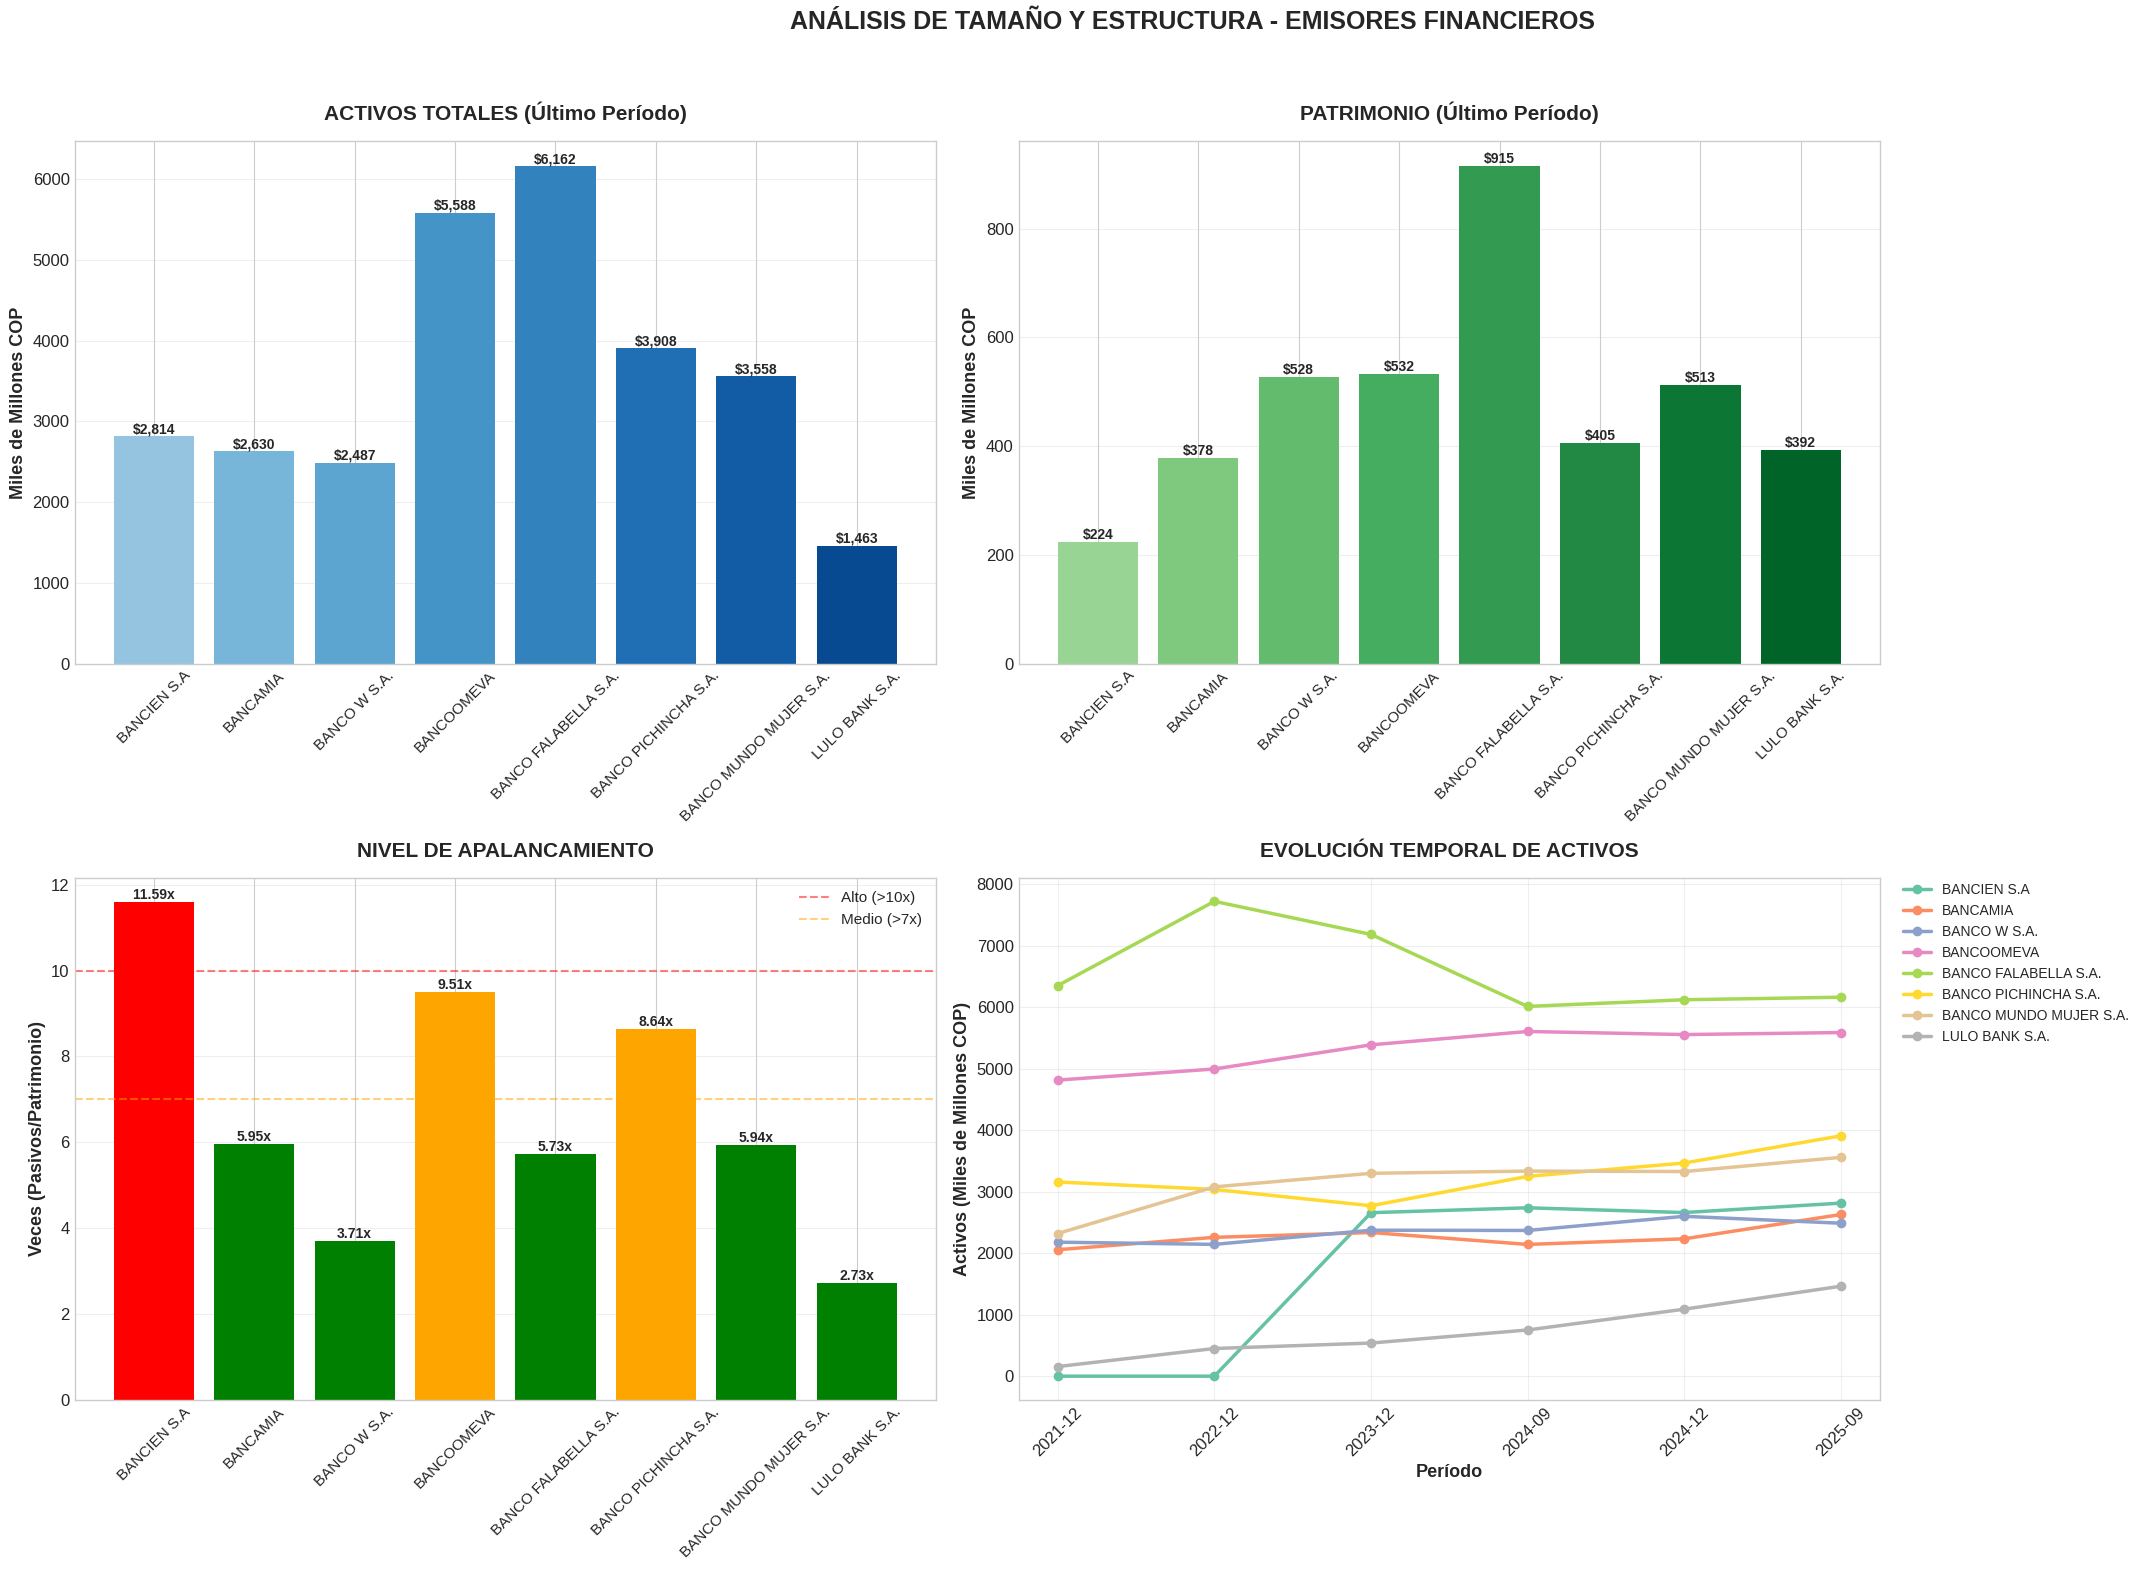

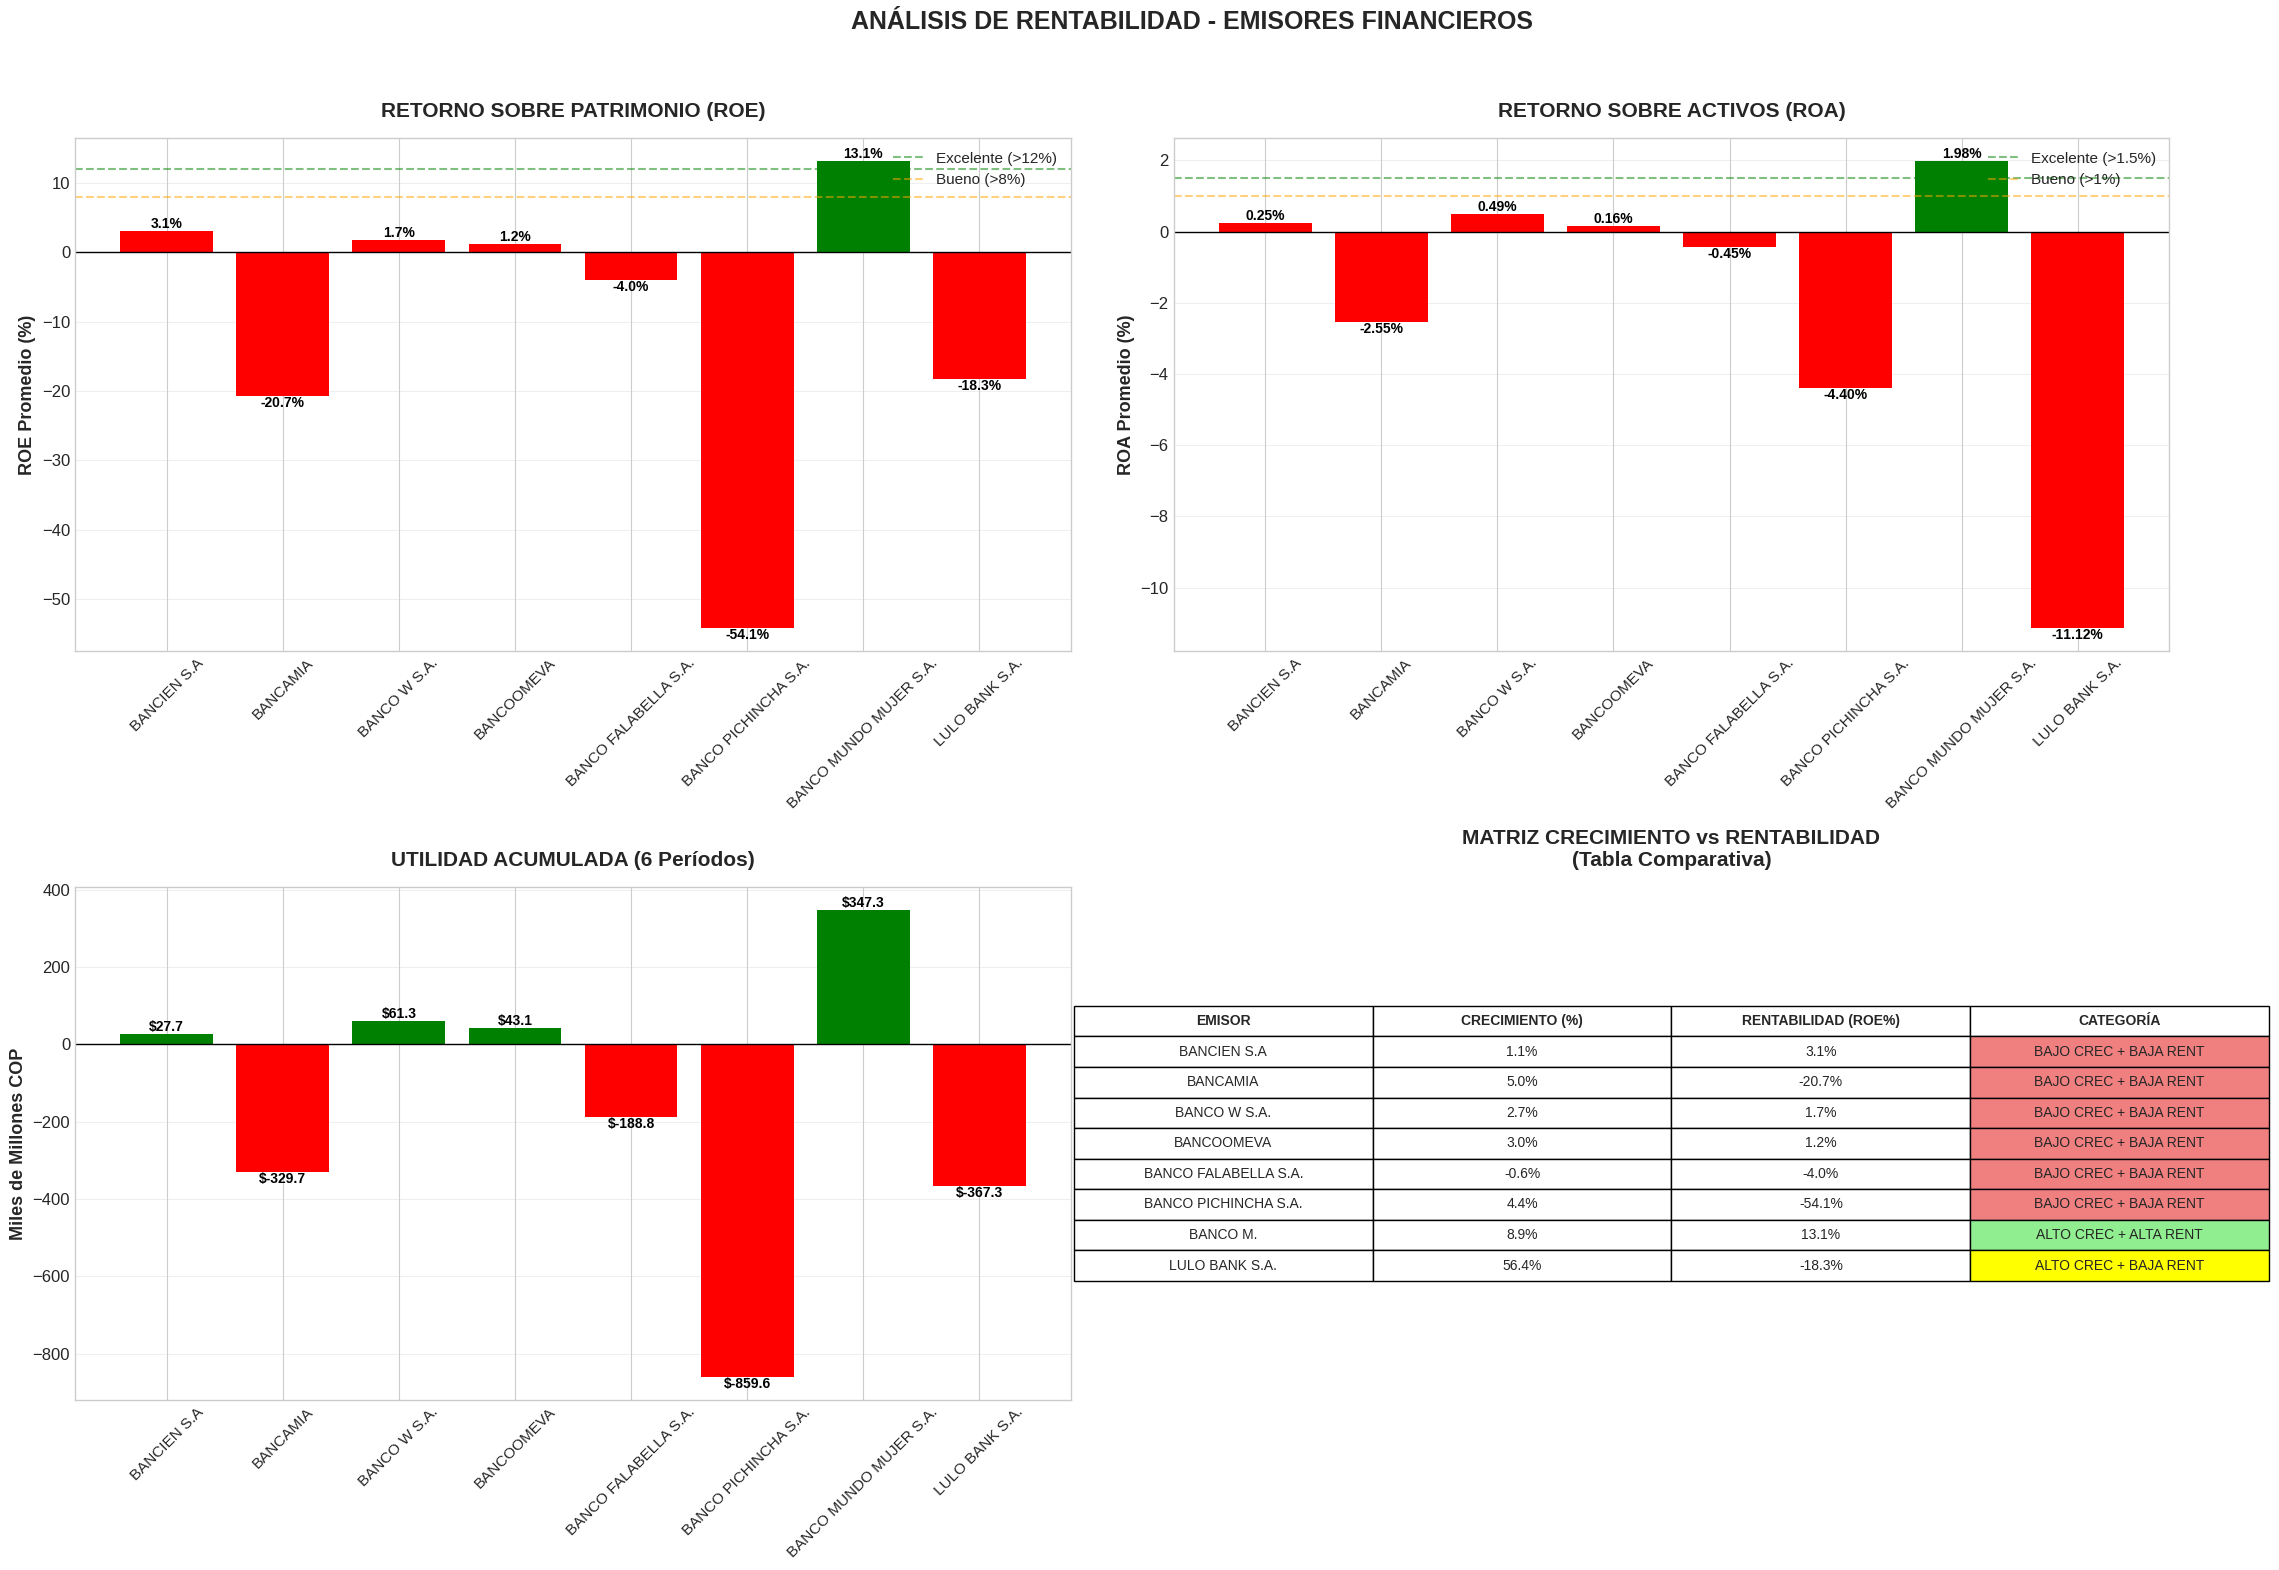

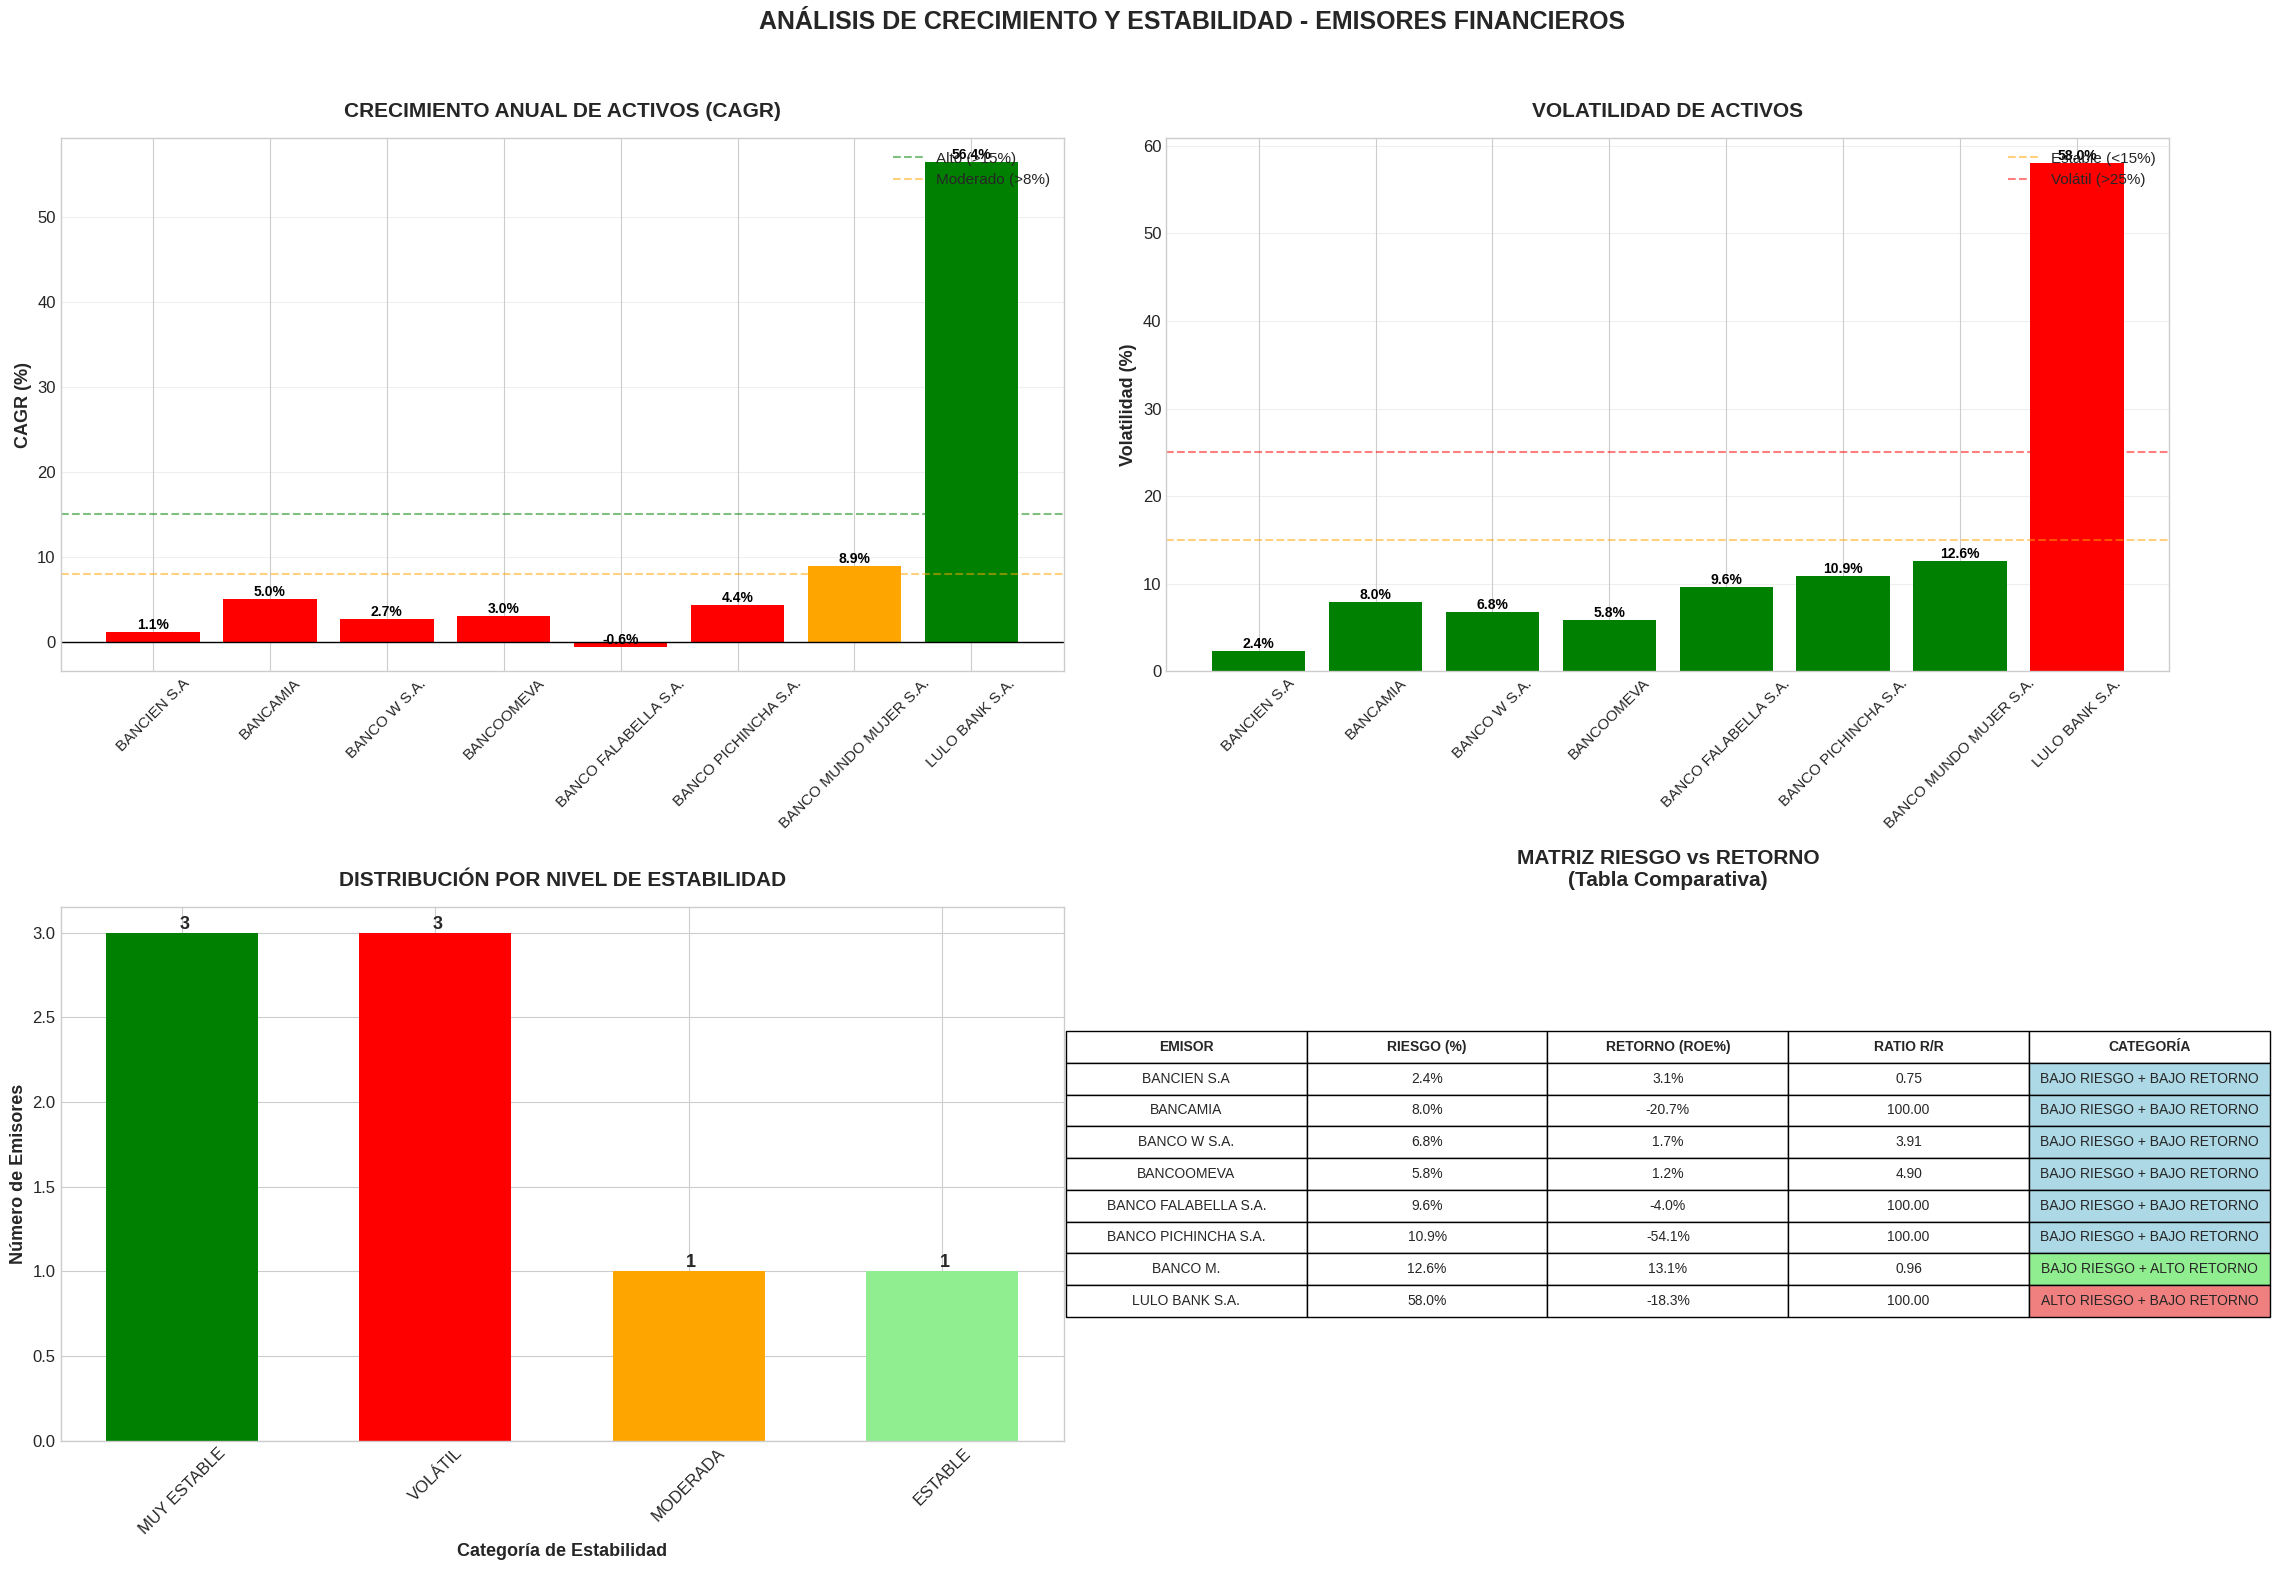

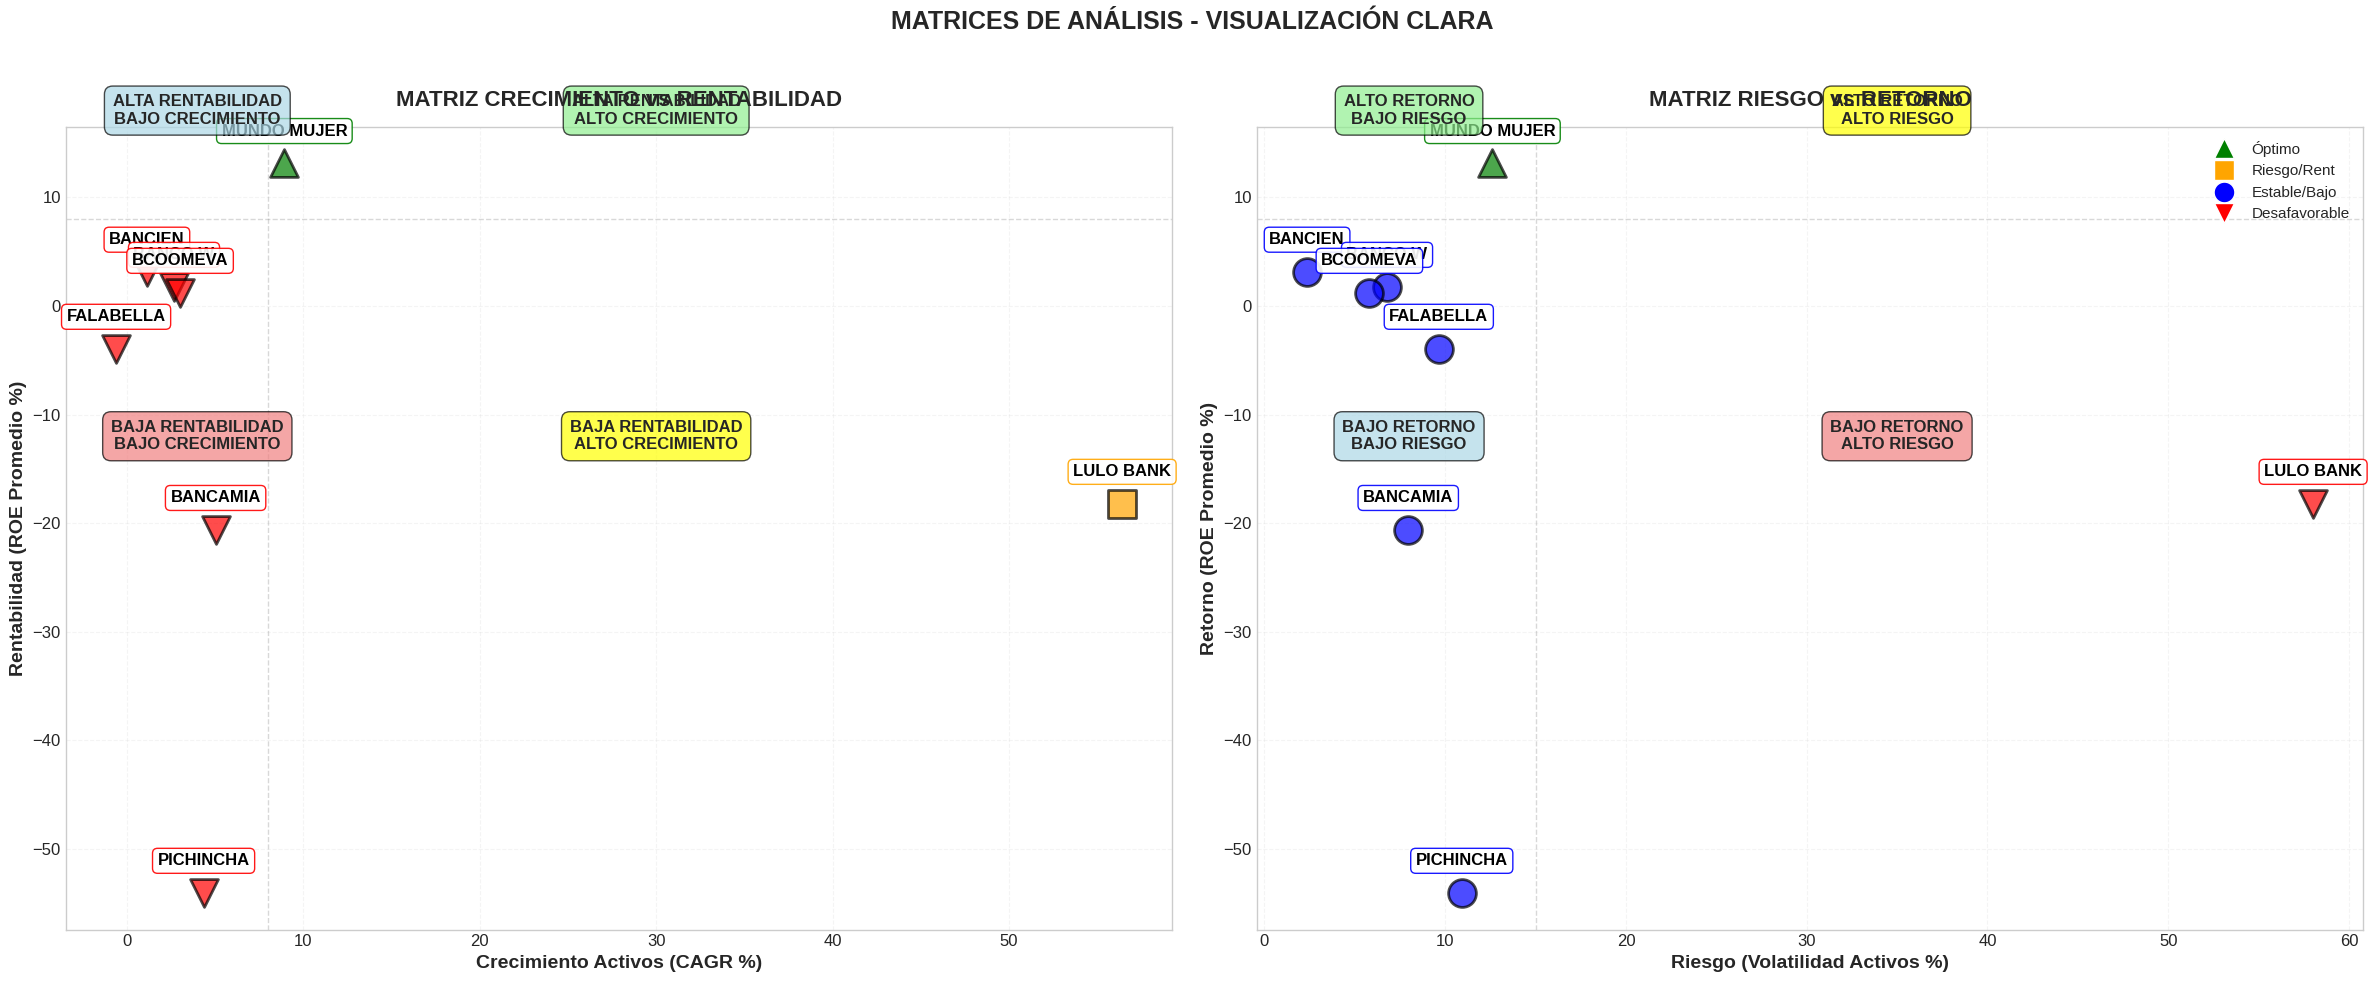


                                          VISUALIZACIONES GENERADAS CON ÉXITO                                           

ARCHIVOS CREADOS:
1. 01_tamano_estructura.png - Análisis de tamaño y estructura financiera
2. 02_rentabilidad.png - Rentabilidad, ROE, ROA y matriz crecimiento vs rentabilidad
3. 03_crecimiento_estabilidad.png - Crecimiento, volatilidad y matriz riesgo vs retorno
4. 04_matrices_claras.png - Matrices de análisis con nombres visibles y colores diferenciados

NOTA: Las matrices ahora usan abreviaturas claras y etiquetas con fondo blanco para máxima visibilidad.


                                   RESUMEN EJECUTIVO - ANÁLISIS INTEGRAL DE EMISORES                                    

                                      RESUMEN POR EMISOR (Último Período: 2025-09)                                      
------------------------------------------------------------------------------------------------------------------------
EMISOR                    | ACTIVOS      | PATRI

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización - AUMENTAR TAMAÑO
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (22, 16)  # Tamaño más grande
plt.rcParams['font.size'] = 12  # Fuente más grande

print("="*120)
print(" "*35 + "ANÁLISIS INTEGRAL DE EMISORES PARA DIVERSIFICACIÓN DE PORTAFOLIO")
print(" "*45 + "ÁREA DE RIESGOS - EVALUACIÓN DE INVERSIÓN")
print("="*120)

# ============================================================================
# 1. DEFINICIÓN DE EMISORES Y PREPARACIÓN DE DATOS
# ============================================================================

emisores = [
    'BANCIEN S.A',
    'BANCAMIA',
    'BANCO W S.A.',
    'BANCOOMEVA',
    'BANCO FALABELLA S.A.',
    'BANCO PICHINCHA S.A.',
    'BANCO MUNDO MUJER S.A.',
    'LULO BANK S.A.'
]

print(f"\n{'EMISORES BAJO ANÁLISIS':^120}")
print("="*120)
for i, emisor in enumerate(emisores, 1):
    print(f"{i}. {emisor}")

# Preparar datos temporales
df1['date'] = pd.to_datetime(df1['date'])
df1['año'] = df1['date'].dt.year
df1['mes'] = df1['date'].dt.month
df1['año_mes'] = df1['date'].dt.to_period('M')
df1['periodo'] = df1['date'].dt.strftime('%Y-%m')

# Identificar rubros principales (TOTALES - donde subrubro=0 y detalle=0)
df_totales = df1[(df1['subrubro'] == 0) & (df1['detalle'] == 0)].copy()
df_subrubros = df1[(df1['subrubro'] != 0) & (df1['detalle'] == 0)].copy()
df_detalle = df1[df1['detalle'] != 0].copy()

print(f"\n{'ESTRUCTURA DE DATOS':^120}")
print("="*120)
print(f"Período de análisis: {df1['date'].min().strftime('%Y-%m')} a {df1['date'].max().strftime('%Y-%m')}")
print(f"Total períodos: {df1['date'].nunique()}")
print(f"Datos totales: {len(df1):,}")
print(f"  - Nivel Rubro (totales): {len(df_totales):,}")
print(f"  - Nivel Subrubro: {len(df_subrubros):,}")
print(f"  - Nivel Detalle: {len(df_detalle):,}")

# Lista de períodos disponibles
periodos = sorted(df1['periodo'].unique())
print(f"\nPeríodos disponibles: {periodos}")

# Última fecha disponible
ultima_fecha = df1['date'].max()
print(f"Última fecha disponible: {ultima_fecha.strftime('%Y-%m-%d')}")

# ============================================================================
# 2. FUNCIONES AUXILIARES MEJORADAS
# ============================================================================

def obtener_valor_por_periodo(df, emisor, periodo):
    """
    Obtiene el valor de un emisor en un período específico
    """
    if df.empty:
        return 0

    df_filtrado = df[df['periodo'] == periodo]
    if df_filtrado.empty:
        return 0

    valores = df_filtrado[emisor]
    return valores.sum() if not valores.empty else 0

def calcular_cagr(valores_por_periodo):
    """
    Calcula el CAGR (Compound Annual Growth Rate) para una serie de valores
    """
    if not valores_por_periodo:
        return 0

    # Convertir a lista ordenada por período
    periodos_ordenados = sorted(valores_por_periodo.keys())
    valores = [valores_por_periodo[p] for p in periodos_ordenados]

    # Filtrar valores válidos (positivos y no cero)
    valores_validos = [v for v in valores if v > 0]

    if len(valores_validos) < 2:
        return 0

    # Encontrar primer y último valor no cero
    valor_inicial = valores_validos[0]
    valor_final = valores_validos[-1]

    if valor_inicial <= 0:
        return 0

    # Número de períodos entre primer y último valor no cero
    n_periodos = len(periodos_ordenados) - 1

    if n_periodos <= 0:
        return 0

    return ((valor_final / valor_inicial) ** (1/n_periodos) - 1) * 100

# ============================================================================
# 3. ANÁLISIS DE TAMAÑO Y CAPITALIZACIÓN
# ============================================================================

print(f"\n\n{'3. ANÁLISIS DE TAMAÑO Y CAPITALIZACIÓN':^120}")
print("="*120)

# Obtener ACTIVOS (rubro='ACTIVOS', subrubro=0, detalle=0)
df_activos = df_totales[df_totales['rubro'] == 'ACTIVOS'].copy()

# Obtener PATRIMONIO (rubro='PATRIMONIO', subrubro=0, detalle=0)
df_patrimonio = df_totales[df_totales['rubro'] == 'PATRIMONIO'].copy()

# Obtener PASIVOS (rubro='PASIVOS', subrubro=0, detalle=0)
df_pasivos = df_totales[df_totales['rubro'] == 'PASIVOS'].copy()

print(f"\n{'EVOLUCIÓN DE ACTIVOS (Millones COP)':^120}")
print("-"*120)
header = f"{'EMISOR':<25}"
for periodo in periodos:
    header += f" | {periodo:<12}"
print(header)
print("-"*120)

# Diccionario para almacenar todos los datos
datos_completos = {}

for emisor in emisores:
    # Inicializar estructura para este emisor
    datos_completos[emisor] = {
        'Activos': {},
        'Patrimonio': {},
        'Pasivos': {},
        'Apalancamiento': {}
    }

    row = f"{emisor[:24]:<25}"

    for periodo in periodos:
        # Obtener valores para este período
        activo_val = obtener_valor_por_periodo(df_activos, emisor, periodo)
        patrimonio_val = obtener_valor_por_periodo(df_patrimonio, emisor, periodo)
        pasivo_val = obtener_valor_por_periodo(df_pasivos, emisor, periodo)

        # Almacenar
        datos_completos[emisor]['Activos'][periodo] = activo_val
        datos_completos[emisor]['Patrimonio'][periodo] = patrimonio_val
        datos_completos[emisor]['Pasivos'][periodo] = pasivo_val

        # Mostrar activo en la tabla
        if activo_val != 0:
            row += f" | ${activo_val:>11,.0f}"
        else:
            row += f" | {'N/D':>12}"

    print(row)

# Calcular y mostrar apalancamiento en última fecha
print(f"\n\n{'APALANCAMIENTO (Último Período)':^120}")
print("-"*120)
print(f"{'EMISOR':<35} | {'ACTIVOS':<15} | {'PATRIMONIO':<15} | {'PASIVOS':<15} | {'APALANCAMIENTO':<15}")
print("-"*120)

for emisor in emisores:
    ultimo_periodo = periodos[-1]
    activos = datos_completos[emisor]['Activos'].get(ultimo_periodo, 0)
    patrimonio = datos_completos[emisor]['Patrimonio'].get(ultimo_periodo, 0)
    pasivos = datos_completos[emisor]['Pasivos'].get(ultimo_periodo, 0)

    # Calcular apalancamiento
    if patrimonio > 0:
        apalancamiento = pasivos / patrimonio
    else:
        apalancamiento = 0

    # Actualizar datos
    datos_completos[emisor]['Apalancamiento'][ultimo_periodo] = apalancamiento

    print(f"{emisor:<35} | ${activos:>13,.0f} | ${patrimonio:>13,.0f} | ${pasivos:>13,.0f} | {apalancamiento:>14.2f}x")

# ============================================================================
# 4. ANÁLISIS DE CALIDAD DE CARTERA - CORREGIDO
# ============================================================================

print(f"\n\n{'4. ANÁLISIS DE CALIDAD DE CARTERA':^120}")
print("="*120)

# Buscar Cartera Bruta en diferentes niveles
# Primero en subrubros: 'CARTERA Y LEASING BRUTO'
df_cartera_bruta = df_subrubros[
    (df_subrubros['rubro'] == 'CARTERA DE CREDITOS Y OPERACIONES DE LEASING') &
    (df_subrubros['subrubro'] == 'CARTERA Y LEASING BRUTO')
].copy()

# Si no está, buscar en otros lugares
if df_cartera_bruta.empty:
    df_cartera_bruta = df_subrubros[
        df_subrubros['subrubro'].str.contains('BRUTO', case=False, na=False)
    ].copy()

# Buscar Cartera Vencida - buscar en diferentes niveles
df_cartera_vencida = df_subrubros[
    df_subrubros['subrubro'].str.contains('VENCIDO|MOROSIDAD', case=False, na=False)
].copy()

# Si no está, buscar en detalles
if df_cartera_vencida.empty:
    df_cartera_vencida = df_detalle[
        df_detalle['detalle'].str.contains('VENCIDO|VENCID', case=False, na=False)
    ].copy()

# Buscar Provisiones (Deterioro) - en rubro 'DETERIORO CARTERA Y LEASING'
df_provisiones = df_totales[df_totales['rubro'] == 'DETERIORO CARTERA Y LEASING'].copy()

# Buscar Calidad - buscar en diferentes niveles
df_calidad = df_subrubros[
    df_subrubros['subrubro'].str.contains('CALIDAD', case=False, na=False)
].copy()

# Buscar Cubrimiento - buscar en diferentes niveles
df_cubrimiento = df_subrubros[
    df_subrubros['subrubro'].str.contains('CUBRIMIENTO', case=False, na=False)
].copy()

print(f"\n{'EVOLUCIÓN DEL ÍNDICE DE CARTERA VENCIDA - ICV (%)':^120}")
print("-"*120)
header = f"{'EMISOR':<25}"
for periodo in periodos:
    header += f" | {periodo:<8}"
print(header)
print("-"*120)

for emisor in emisores:
    # Inicializar estructura para calidad
    if 'Calidad' not in datos_completos[emisor]:
        datos_completos[emisor]['Calidad'] = {}
        datos_completos[emisor]['ICV'] = {}
        datos_completos[emisor]['Cubrimiento'] = {}
        datos_completos[emisor]['Provisiones'] = {}
        datos_completos[emisor]['Cartera_Bruta'] = {}

    row = f"{emisor[:24]:<25}"

    for periodo in periodos:
        # Cartera bruta
        cartera_bruta = obtener_valor_por_periodo(df_cartera_bruta, emisor, periodo)

        # Cartera vencida
        cartera_vencida = obtener_valor_por_periodo(df_cartera_vencida, emisor, periodo)

        # Calcular ICV (Índice de Cartera Vencida)
        if cartera_bruta > 0:
            icv = (cartera_vencida / cartera_bruta) * 100
        else:
            icv = 0

        # Calidad (porcentaje)
        calidad_val = obtener_valor_por_periodo(df_calidad, emisor, periodo)

        # Almacenar
        datos_completos[emisor]['ICV'][periodo] = icv
        datos_completos[emisor]['Calidad'][periodo] = calidad_val
        datos_completos[emisor]['Cartera_Bruta'][periodo] = cartera_bruta

        # Mostrar ICV
        row += f" | {icv:>7.2f}%"

    print(row)

# Mostrar provisiones en último período
print(f"\n\n{'PROVISIONES PARA DETERIORO (Último Período)':^120}")
print("-"*120)
print(f"{'EMISOR':<35} | {'CARTERA BRUTA':<18} | {'PROVISIONES':<18} | {'COBERTURA (%)':<15}")
print("-"*120)

for emisor in emisores:
    ultimo_periodo = periodos[-1]

    cartera_bruta = datos_completos[emisor]['Cartera_Bruta'].get(ultimo_periodo, 0)
    provisiones = abs(obtener_valor_por_periodo(df_provisiones, emisor, ultimo_periodo))

    # Calcular cobertura (provisiones como % de cartera bruta)
    if cartera_bruta > 0:
        cobertura = (provisiones / cartera_bruta) * 100
    else:
        cobertura = 0

    # Almacenar
    datos_completos[emisor]['Provisiones'][ultimo_periodo] = provisiones

    # Mostrar
    print(f"{emisor:<35} | ${cartera_bruta:>16,.0f} | ${provisiones:>16,.0f} | {cobertura:>13.2f}%")

# ============================================================================
# 5. ANÁLISIS DE RENTABILIDAD
# ============================================================================

print(f"\n\n{'5. ANÁLISIS DE RENTABILIDAD':^120}")
print("="*120)

# Buscar Resultados del ejercicio - en rubro 'GANANCIAS (EXCEDENTES) Y PÉRDIDAS'
df_resultados = df_totales[df_totales['rubro'] == 'GANANCIAS (EXCEDENTES) Y PÉRDIDAS'].copy()

print(f"\n{'EVOLUCIÓN DE LA UTILIDAD NETA (Millones COP)':^120}")
print("-"*120)
header = f"{'EMISOR':<25}"
for periodo in periodos:
    header += f" | {periodo:<12}"
print(header)
print("-"*120)

for emisor in emisores:
    # Inicializar estructura para rentabilidad
    if 'Rentabilidad' not in datos_completos[emisor]:
        datos_completos[emisor]['Rentabilidad'] = {
            'Utilidad': {},
            'ROE': {},
            'ROA': {}
        }

    utilidad_por_periodo = {}
    row = f"{emisor[:24]:<25}"

    for periodo in periodos:
        utilidad = obtener_valor_por_periodo(df_resultados, emisor, periodo)
        utilidad_por_periodo[periodo] = utilidad

        if utilidad >= 0:
            row += f" | ${utilidad:>11,.0f}"
        else:
            row += f" | (${abs(utilidad):>10,.0f})"

    # Almacenar utilidad
    datos_completos[emisor]['Rentabilidad']['Utilidad'] = utilidad_por_periodo

    # Calcular ROE y ROA para cada período
    roe_por_periodo = {}
    roa_por_periodo = {}

    for periodo in periodos:
        utilidad = utilidad_por_periodo.get(periodo, 0)
        patrimonio = datos_completos[emisor]['Patrimonio'].get(periodo, 0)
        activos = datos_completos[emisor]['Activos'].get(periodo, 0)

        roe = (utilidad / patrimonio * 100) if patrimonio > 0 else 0
        roa = (utilidad / activos * 100) if activos > 0 else 0

        roe_por_periodo[periodo] = roe
        roa_por_periodo[periodo] = roa

    datos_completos[emisor]['Rentabilidad']['ROE'] = roe_por_periodo
    datos_completos[emisor]['Rentabilidad']['ROA'] = roa_por_periodo

    print(row)

# Mostrar ROE y ROA promedio CORREGIDO
print(f"\n\n{'ROE Y ROA PROMEDIO (Solo períodos con datos)':^120}")
print("-"*120)
print(f"{'EMISOR':<35} | {'ROE PROM (%)':<15} | {'ROA PROM (%)':<15} | {'UTIL. ACUM (MM)':<18}")
print("-"*120)

for emisor in emisores:
    # Calcular promedios solo para períodos con datos válidos
    roe_values = []
    roa_values = []
    util_values = []

    for periodo in periodos:
        utilidad = datos_completos[emisor]['Rentabilidad']['Utilidad'].get(periodo, 0)
        patrimonio = datos_completos[emisor]['Patrimonio'].get(periodo, 0)
        activos = datos_completos[emisor]['Activos'].get(periodo, 0)

        if patrimonio > 0 and activos > 0:
            roe = (utilidad / patrimonio * 100)
            roa = (utilidad / activos * 100)

            roe_values.append(roe)
            roa_values.append(roa)
            util_values.append(utilidad)

    # Calcular promedios
    roe_prom = np.mean(roe_values) if roe_values else 0
    roa_prom = np.mean(roa_values) if roa_values else 0
    util_acum = sum(util_values) if util_values else 0

    # Convertir a miles de millones para mostrar
    util_acum_mm = util_acum / 1000

    print(f"{emisor:<35} | {roe_prom:>13.2f}% | {roa_prom:>13.2f}% | ${util_acum_mm:>15,.2f}")

# ============================================================================
# 6. ANÁLISIS DE CRECIMIENTO - CORREGIDO
# ============================================================================

print(f"\n\n{'6. ANÁLISIS DE CRECIMIENTO':^120}")
print("="*120)

print(f"\n{'TASA DE CRECIMIENTO ANUAL COMPUESTA - CAGR (%)':^120}")
print("-"*120)
print(f"{'EMISOR':<35} | {'ACTIVOS':<12} | {'PATRIMONIO':<12} | {'UTILIDAD':<12} | {'CARTERA':<12}")
print("-"*120)

for emisor in emisores:
    # Calcular CAGR para diferentes métricas usando función mejorada
    cagr_activos = calcular_cagr(datos_completos[emisor]['Activos'])
    cagr_patrimonio = calcular_cagr(datos_completos[emisor]['Patrimonio'])

    if 'Rentabilidad' in datos_completos[emisor]:
        cagr_utilidad = calcular_cagr(datos_completos[emisor]['Rentabilidad']['Utilidad'])
    else:
        cagr_utilidad = 0

    # Calcular CAGR para cartera
    if 'Cartera_Bruta' in datos_completos[emisor]:
        cagr_cartera = calcular_cagr(datos_completos[emisor]['Cartera_Bruta'])
    else:
        cagr_cartera = 0

    # Almacenar en datos completos
    if 'Crecimiento' not in datos_completos[emisor]:
        datos_completos[emisor]['Crecimiento'] = {}

    datos_completos[emisor]['Crecimiento']['CAGR_Activos'] = cagr_activos
    datos_completos[emisor]['Crecimiento']['CAGR_Patrimonio'] = cagr_patrimonio
    datos_completos[emisor]['Crecimiento']['CAGR_Utilidad'] = cagr_utilidad
    datos_completos[emisor]['Crecimiento']['CAGR_Cartera'] = cagr_cartera

    print(f"{emisor:<35} | {cagr_activos:>10.2f}% | {cagr_patrimonio:>10.2f}% | {cagr_utilidad:>10.2f}% | {cagr_cartera:>10.2f}%")

# ============================================================================
# 7. ANÁLISIS DE ESTABILIDAD Y RIESGO - CORREGIDO
# ============================================================================

print(f"\n\n{'7. ANÁLISIS DE ESTABILIDAD Y RIESGO':^120}")
print("="*120)

print(f"\n{'VOLATILIDAD Y ESTABILIDAD FINANCIERA':^120}")
print("-"*120)
print(f"{'EMISOR':<35} | {'VOL ACTIVOS (%)':<15} | {'VOL ROE (%)':<15} | {'MÁX ICV (%)':<15} | {'ESTABILIDAD':<15}")
print("-"*120)

for emisor in emisores:
    # Calcular volatilidad de activos (coeficiente de variación)
    activos_vals = list(datos_completos[emisor]['Activos'].values())
    activos_vals_validos = [v for v in activos_vals if v > 0]

    if len(activos_vals_validos) > 1 and np.mean(activos_vals_validos) > 0:
        vol_activos = (np.std(activos_vals_validos) / np.mean(activos_vals_validos)) * 100
    else:
        vol_activos = 0

    # Calcular volatilidad de ROE
    if 'Rentabilidad' in datos_completos[emisor]:
        roe_vals = list(datos_completos[emisor]['Rentabilidad']['ROE'].values())
        roe_vals_validos = [v for v in roe_vals if v != 0]

        if len(roe_vals_validos) > 1:
            vol_roe = np.std(roe_vals_validos)
        else:
            vol_roe = 0
    else:
        vol_roe = 0

    # Encontrar máximo ICV
    if 'ICV' in datos_completos[emisor]:
        icv_vals = list(datos_completos[emisor]['ICV'].values())
        # Filtrar valores mayores a 0
        icv_vals_positivos = [v for v in icv_vals if v > 0]
        max_icv = max(icv_vals_positivos) if icv_vals_positivos else 0
    else:
        max_icv = 0

    # Evaluar estabilidad con criterios realistas
    if vol_activos < 10 and vol_roe < 5:
        estabilidad = "MUY ESTABLE"
    elif vol_activos < 20 and vol_roe < 10:
        estabilidad = "ESTABLE"
    elif vol_activos < 30 and vol_roe < 15:
        estabilidad = "MODERADA"
    else:
        estabilidad = "VOLÁTIL"

    # Almacenar
    if 'Estabilidad' not in datos_completos[emisor]:
        datos_completos[emisor]['Estabilidad'] = {}

    datos_completos[emisor]['Estabilidad']['Vol_Activos'] = vol_activos
    datos_completos[emisor]['Estabilidad']['Vol_ROE'] = vol_roe
    datos_completos[emisor]['Estabilidad']['Max_ICV'] = max_icv
    datos_completos[emisor]['Estabilidad']['Clasificacion'] = estabilidad

    print(f"{emisor:<35} | {vol_activos:>13.2f}% | {vol_roe:>13.2f}% | {max_icv:>13.2f}% | {estabilidad:<15}")

# ============================================================================
# VISUALIZACIONES ALTERNATIVAS - MÁS CLARAS
# ============================================================================

print(f"\n\n{'GENERANDO VISUALIZACIONES...':^120}")

# FIGURA 1: Tamaño y Estructura - 2x2
fig1, axes1 = plt.subplots(2, 2, figsize=(24, 16))
fig1.suptitle('ANÁLISIS DE TAMAÑO Y ESTRUCTURA - EMISORES FINANCIEROS',
             fontsize=18, fontweight='bold', y=0.98)

# 1.1: Activos Totales
ax1 = axes1[0, 0]
activos_ultimo = [datos_completos[e]['Activos'].get(periodos[-1], 0) / 1000 for e in emisores]
colors1 = plt.cm.Blues(np.linspace(0.4, 0.9, len(emisores)))
bars1 = ax1.bar(emisores, activos_ultimo, color=colors1)
ax1.set_ylabel('Miles de Millones COP', fontsize=13, fontweight='bold')
ax1.set_title('ACTIVOS TOTALES (Último Período)', fontsize=15, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45, labelsize=11)
for i, (emisor, val) in enumerate(zip(emisores, activos_ultimo)):
    ax1.text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 1.2: Patrimonio
ax2 = axes1[0, 1]
patrimonio_ultimo = [datos_completos[e]['Patrimonio'].get(periodos[-1], 0) / 1000 for e in emisores]
colors2 = plt.cm.Greens(np.linspace(0.4, 0.9, len(emisores)))
bars2 = ax2.bar(emisores, patrimonio_ultimo, color=colors2)
ax2.set_ylabel('Miles de Millones COP', fontsize=13, fontweight='bold')
ax2.set_title('PATRIMONIO (Último Período)', fontsize=15, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45, labelsize=11)
for i, (emisor, val) in enumerate(zip(emisores, patrimonio_ultimo)):
    ax2.text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 1.3: Apalancamiento
ax3 = axes1[1, 0]
apalancamiento_ultimo = [datos_completos[e]['Apalancamiento'].get(periodos[-1], 0) for e in emisores]
colors3 = ['red' if x > 10 else 'orange' if x > 7 else 'green' for x in apalancamiento_ultimo]
bars3 = ax3.bar(emisores, apalancamiento_ultimo, color=colors3)
ax3.set_ylabel('Veces (Pasivos/Patrimonio)', fontsize=13, fontweight='bold')
ax3.set_title('NIVEL DE APALANCAMIENTO', fontsize=15, fontweight='bold', pad=15)
ax3.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Alto (>10x)')
ax3.axhline(y=7, color='orange', linestyle='--', alpha=0.5, label='Medio (>7x)')
ax3.grid(axis='y', alpha=0.3)
ax3.tick_params(axis='x', rotation=45, labelsize=11)
ax3.legend(fontsize=11, loc='upper right')
for i, (emisor, val) in enumerate(zip(emisores, apalancamiento_ultimo)):
    ax3.text(i, val, f'{val:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 1.4: Evolución de Activos
ax4 = axes1[1, 1]
for emisor in emisores:
    activos_vals = [datos_completos[emisor]['Activos'].get(p, 0) / 1000 for p in periodos]
    if any(v > 0 for v in activos_vals):
        ax4.plot(periodos, activos_vals, marker='o', linewidth=2.5, markersize=6, label=emisor)

ax4.set_xlabel('Período', fontsize=13, fontweight='bold')
ax4.set_ylabel('Activos (Miles de Millones COP)', fontsize=13, fontweight='bold')
ax4.set_title('EVOLUCIÓN TEMPORAL DE ACTIVOS', fontsize=15, fontweight='bold', pad=15)
ax4.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.savefig('01_tamano_estructura.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 2: Rentabilidad - CON ALTERNATIVA MÁS CLARA
fig2, axes2 = plt.subplots(2, 2, figsize=(24, 16))
fig2.suptitle('ANÁLISIS DE RENTABILIDAD - EMISORES FINANCIEROS',
             fontsize=18, fontweight='bold', y=0.98)

# 2.1: ROE Promedio
ax1 = axes2[0, 0]
roe_promedio = []
for emisor in emisores:
    if 'Rentabilidad' in datos_completos[emisor]:
        roe_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0]
        roe_prom = np.mean(roe_vals) if roe_vals else 0
    else:
        roe_prom = 0
    roe_promedio.append(roe_prom)

colors_roe = ['green' if x > 12 else 'orange' if x > 8 else 'red' for x in roe_promedio]
bars1 = ax1.bar(emisores, roe_promedio, color=colors_roe)
ax1.set_ylabel('ROE Promedio (%)', fontsize=13, fontweight='bold')
ax1.set_title('RETORNO SOBRE PATRIMONIO (ROE)', fontsize=15, fontweight='bold', pad=15)
ax1.axhline(y=12, color='green', linestyle='--', alpha=0.5, label='Excelente (>12%)')
ax1.axhline(y=8, color='orange', linestyle='--', alpha=0.5, label='Bueno (>8%)')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45, labelsize=11)
ax1.legend(fontsize=11, loc='upper right')
for i, (emisor, val) in enumerate(zip(emisores, roe_promedio)):
    ax1.text(i, val, f'{val:.1f}%', ha='center', va='bottom' if val >= 0 else 'top',
             fontsize=10, fontweight='bold', color='black')

# 2.2: ROA Promedio
ax2 = axes2[0, 1]
roa_promedio = []
for emisor in emisores:
    if 'Rentabilidad' in datos_completos[emisor]:
        roa_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROA'].values() if v != 0]
        roa_prom = np.mean(roa_vals) if roa_vals else 0
    else:
        roa_prom = 0
    roa_promedio.append(roa_prom)

colors_roa = ['green' if x > 1.5 else 'orange' if x > 1 else 'red' for x in roa_promedio]
bars2 = ax2.bar(emisores, roa_promedio, color=colors_roa)
ax2.set_ylabel('ROA Promedio (%)', fontsize=13, fontweight='bold')
ax2.set_title('RETORNO SOBRE ACTIVOS (ROA)', fontsize=15, fontweight='bold', pad=15)
ax2.axhline(y=1.5, color='green', linestyle='--', alpha=0.5, label='Excelente (>1.5%)')
ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='Bueno (>1%)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45, labelsize=11)
ax2.legend(fontsize=11, loc='upper right')
for i, (emisor, val) in enumerate(zip(emisores, roa_promedio)):
    ax2.text(i, val, f'{val:.2f}%', ha='center', va='bottom' if val >= 0 else 'top',
             fontsize=10, fontweight='bold', color='black')

# 2.3: Utilidad Acumulada
ax3 = axes2[1, 0]
util_acum = []
for emisor in emisores:
    if 'Rentabilidad' in datos_completos[emisor]:
        util_vals = list(datos_completos[emisor]['Rentabilidad']['Utilidad'].values())
        util_total = sum(util_vals) / 1000  # Convertir a miles de millones
    else:
        util_total = 0
    util_acum.append(util_total)

colors_util = ['green' if x > 0 else 'red' for x in util_acum]
bars3 = ax3.bar(emisores, util_acum, color=colors_util)
ax3.set_ylabel('Miles de Millones COP', fontsize=13, fontweight='bold')
ax3.set_title('UTILIDAD ACUMULADA (6 Períodos)', fontsize=15, fontweight='bold', pad=15)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.grid(axis='y', alpha=0.3)
ax3.tick_params(axis='x', rotation=45, labelsize=11)
for i, (emisor, val) in enumerate(zip(emisores, util_acum)):
    ax3.text(i, val, f'${val:,.1f}', ha='center', va='bottom' if val >= 0 else 'top',
             fontsize=10, fontweight='bold', color='black')

# 2.4: ALTERNATIVA - Tabla Visual de Crecimiento vs Rentabilidad
ax4 = axes2[1, 1]
crecimiento = [datos_completos[e]['Crecimiento'].get('CAGR_Activos', 0) for e in emisores]
rentabilidad = roe_promedio

# Crear una matriz de calor para visualizar
matriz_data = []
for i, emisor in enumerate(emisores):
    # Clasificar por crecimiento y rentabilidad
    if crecimiento[i] > 8 and rentabilidad[i] > 8:
        categoria = "ALTO CREC + ALTA RENT"
        color = "lightgreen"
    elif crecimiento[i] > 8 and rentabilidad[i] <= 8:
        categoria = "ALTO CREC + BAJA RENT"
        color = "yellow"
    elif crecimiento[i] <= 8 and rentabilidad[i] > 8:
        categoria = "BAJO CREC + ALTA RENT"
        color = "lightblue"
    else:
        categoria = "BAJO CREC + BAJA RENT"
        color = "lightcoral"

    matriz_data.append([emisor, crecimiento[i], rentabilidad[i], categoria, color])

# Crear tabla visual
ax4.axis('off')
ax4.set_title('MATRIZ CRECIMIENTO vs RENTABILIDAD\n(Tabla Comparativa)', fontsize=15, fontweight='bold', pad=15)

# Crear tabla
table_data = []
headers = ['EMISOR', 'CRECIMIENTO (%)', 'RENTABILIDAD (ROE%)', 'CATEGORÍA']

for fila in matriz_data:
    emisor_abreviado = fila[0]
    # Acortar nombres largos
    if len(emisor_abreviado) > 20:
        palabras = emisor_abreviado.split()
        if len(palabras) > 1:
            emisor_abreviado = f"{palabras[0]} {palabras[1][0]}."
        else:
            emisor_abreviado = emisor_abreviado[:18] + "..."

    table_data.append([
        emisor_abreviado,
        f"{fila[1]:.1f}%",
        f"{fila[2]:.1f}%",
        fila[3]
    ])

# Crear colores para las filas
cell_colors = [['white', 'white', 'white', fila[4]] for fila in matriz_data]

# Crear tabla
tabla = ax4.table(cellText=table_data,
                  colLabels=headers,
                  cellLoc='center',
                  loc='center',
                  cellColours=cell_colors)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 2)

# Estilo de la tabla
for i in range(len(matriz_data) + 1):
    for j in range(4):
        cell = tabla[(i, j)]
        cell.set_text_props(fontweight='bold' if i == 0 else 'normal')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])
plt.savefig('02_rentabilidad.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 3: Crecimiento y Estabilidad - CON ALTERNATIVA CLARA
fig3, axes3 = plt.subplots(2, 2, figsize=(24, 16))
fig3.suptitle('ANÁLISIS DE CRECIMIENTO Y ESTABILIDAD - EMISORES FINANCIEROS',
             fontsize=18, fontweight='bold', y=0.98)

# 3.1: Crecimiento de Activos (CAGR)
ax1 = axes3[0, 0]
cagr_activos = [datos_completos[e]['Crecimiento'].get('CAGR_Activos', 0) for e in emisores]
colors_cagr = ['green' if x > 15 else 'orange' if x > 8 else 'red' for x in cagr_activos]
bars1 = ax1.bar(emisores, cagr_activos, color=colors_cagr)
ax1.set_ylabel('CAGR (%)', fontsize=13, fontweight='bold')
ax1.set_title('CRECIMIENTO ANUAL DE ACTIVOS (CAGR)', fontsize=15, fontweight='bold', pad=15)
ax1.axhline(y=15, color='green', linestyle='--', alpha=0.5, label='Alto (>15%)')
ax1.axhline(y=8, color='orange', linestyle='--', alpha=0.5, label='Moderado (>8%)')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45, labelsize=11)
ax1.legend(fontsize=11, loc='upper right')
for i, (emisor, val) in enumerate(zip(emisores, cagr_activos)):
    ax1.text(i, val, f'{val:.1f}%', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

# 3.2: Volatilidad de Activos
ax2 = axes3[0, 1]
vol_activos = [datos_completos[e]['Estabilidad'].get('Vol_Activos', 0) for e in emisores]
colors_vol = ['green' if x < 15 else 'orange' if x < 25 else 'red' for x in vol_activos]
bars2 = ax2.bar(emisores, vol_activos, color=colors_vol)
ax2.set_ylabel('Volatilidad (%)', fontsize=13, fontweight='bold')
ax2.set_title('VOLATILIDAD DE ACTIVOS', fontsize=15, fontweight='bold', pad=15)
ax2.axhline(y=15, color='orange', linestyle='--', alpha=0.5, label='Estable (<15%)')
ax2.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Volátil (>25%)')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45, labelsize=11)
ax2.legend(fontsize=11, loc='upper right')
for i, (emisor, val) in enumerate(zip(emisores, vol_activos)):
    ax2.text(i, val, f'{val:.1f}%', ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

# 3.3: Clasificación de Estabilidad
ax3 = axes3[1, 0]
estabilidades = [datos_completos[e]['Estabilidad'].get('Clasificacion', 'DESCONOCIDO') for e in emisores]
estabilidad_counts = pd.Series(estabilidades).value_counts()

colors_est = {'MUY ESTABLE': 'green', 'ESTABLE': 'lightgreen', 'MODERADA': 'orange', 'VOLÁTIL': 'red'}
bar_colors = [colors_est.get(est, 'gray') for est in estabilidad_counts.index]

bars3 = ax3.bar(estabilidad_counts.index, estabilidad_counts.values, color=bar_colors, width=0.6)
ax3.set_xlabel('Categoría de Estabilidad', fontsize=13, fontweight='bold')
ax3.set_ylabel('Número de Emisores', fontsize=13, fontweight='bold')
ax3.set_title('DISTRIBUCIÓN POR NIVEL DE ESTABILIDAD', fontsize=15, fontweight='bold', pad=15)
ax3.tick_params(axis='x', rotation=45, labelsize=12)
for i, val in enumerate(estabilidad_counts.values):
    ax3.text(i, val, f' {val}', ha='center', va='bottom', fontsize=13, fontweight='bold')

# 3.4: ALTERNATIVA - Tabla Visual de Riesgo vs Retorno
ax4 = axes3[1, 1]
riesgo = [datos_completos[e]['Estabilidad'].get('Vol_Activos', 0) for e in emisores]
retorno = roe_promedio

# Crear una matriz de calor para visualizar
matriz_riesgo_data = []
for i, emisor in enumerate(emisores):
    # Clasificar por riesgo y retorno
    if riesgo[i] < 15 and retorno[i] > 8:
        categoria = "BAJO RIESGO + ALTO RETORNO"
        color = "lightgreen"
    elif riesgo[i] >= 15 and retorno[i] > 8:
        categoria = "ALTO RIESGO + ALTO RETORNO"
        color = "yellow"
    elif riesgo[i] < 15 and retorno[i] <= 8:
        categoria = "BAJO RIESGO + BAJO RETORNO"
        color = "lightblue"
    else:
        categoria = "ALTO RIESGO + BAJO RETORNO"
        color = "lightcoral"

    # Calcular ratio riesgo/retorno
    if retorno[i] > 0:
        ratio_rr = riesgo[i] / retorno[i]
    else:
        ratio_rr = 100

    matriz_riesgo_data.append([emisor, riesgo[i], retorno[i], ratio_rr, categoria, color])

# Crear tabla visual
ax4.axis('off')
ax4.set_title('MATRIZ RIESGO vs RETORNO\n(Tabla Comparativa)', fontsize=15, fontweight='bold', pad=15)

# Crear tabla
table_data_riesgo = []
headers_riesgo = ['EMISOR', 'RIESGO (%)', 'RETORNO (ROE%)', 'RATIO R/R', 'CATEGORÍA']

for fila in matriz_riesgo_data:
    emisor_abreviado = fila[0]
    # Acortar nombres largos
    if len(emisor_abreviado) > 20:
        palabras = emisor_abreviado.split()
        if len(palabras) > 1:
            emisor_abreviado = f"{palabras[0]} {palabras[1][0]}."
        else:
            emisor_abreviado = emisor_abreviado[:18] + "..."

    table_data_riesgo.append([
        emisor_abreviado,
        f"{fila[1]:.1f}%",
        f"{fila[2]:.1f}%",
        f"{fila[3]:.2f}",
        fila[4]
    ])

# Crear colores para las filas
cell_colors_riesgo = [['white', 'white', 'white', 'white', fila[5]] for fila in matriz_riesgo_data]

# Crear tabla
tabla_riesgo = ax4.table(cellText=table_data_riesgo,
                         colLabels=headers_riesgo,
                         cellLoc='center',
                         loc='center',
                         cellColours=cell_colors_riesgo)

tabla_riesgo.auto_set_font_size(False)
tabla_riesgo.set_fontsize(10)
tabla_riesgo.scale(1.2, 2)

# Estilo de la tabla
for i in range(len(matriz_riesgo_data) + 1):
    for j in range(5):
        cell = tabla_riesgo[(i, j)]
        cell.set_text_props(fontweight='bold' if i == 0 else 'normal')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)

plt.tight_layout(rect=[0, 0, 0.95, 0.96])
plt.savefig('03_crecimiento_estabilidad.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURA 4: Gráficos de Dispersión SEPARADOS y CLAROS
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig4.suptitle('MATRICES DE ANÁLISIS - VISUALIZACIÓN CLARA',
             fontsize=18, fontweight='bold', y=0.98)

# 4.1: Matriz Crecimiento vs Rentabilidad - MEJORADA
ax1.set_title('MATRIZ CRECIMIENTO vs RENTABILIDAD', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Crecimiento Activos (CAGR %)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Rentabilidad (ROE Promedio %)', fontsize=14, fontweight='bold')

# Añadir líneas de referencia
ax1.axhline(y=8, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax1.axvline(x=8, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax1.grid(True, alpha=0.2, linestyle='--')

# Crear scatter plot con etiquetas grandes
crecimiento = [datos_completos[e]['Crecimiento'].get('CAGR_Activos', 0) for e in emisores]
rentabilidad = roe_promedio

# Usar abreviaturas claras para los bancos
abreviaturas = {
    'BANCIEN S.A': 'BANCIEN',
    'BANCAMIA': 'BANCAMIA',
    'BANCO W S.A.': 'BANCO W',
    'BANCOOMEVA': 'BCOOMEVA',
    'BANCO FALABELLA S.A.': 'FALABELLA',
    'BANCO PICHINCHA S.A.': 'PICHINCHA',
    'BANCO MUNDO MUJER S.A.': 'MUNDO MUJER',
    'LULO BANK S.A.': 'LULO BANK'
}

# Graficar cada punto individualmente con etiqueta grande
for i, emisor in enumerate(emisores):
    x = crecimiento[i]
    y = rentabilidad[i]
    abrev = abreviaturas.get(emisor, emisor[:8])

    # Determinar color según posición
    if x > 8 and y > 8:
        color = 'green'
        marcador = '^'  # Triángulo para ALTO/ALTO
    elif x > 8 and y <= 8:
        color = 'orange'
        marcador = 's'  # Cuadrado para ALTO/BAJO
    elif x <= 8 and y > 8:
        color = 'blue'
        marcador = 'o'  # Círculo para BAJO/ALTO
    else:
        color = 'red'
        marcador = 'v'  # Triángulo invertido para BAJO/BAJO

    # Graficar punto
    ax1.scatter(x, y, s=400, color=color, marker=marcador, alpha=0.7, edgecolors='black', linewidth=2)

    # Añadir etiqueta con fondo
    ax1.annotate(abrev,
                (x, y),
                xytext=(0, 20),  # Desplazamiento fijo hacia arriba
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                ha='center',
                color='black',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor=color))

# Añadir cuadrantes con fondo
ax1.text(4, 18, 'ALTA RENTABILIDAD\nBAJO CRECIMIENTO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
ax1.text(30, 18, 'ALTA RENTABILIDAD\nALTO CRECIMIENTO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.7))
ax1.text(4, -12, 'BAJA RENTABILIDAD\nBAJO CRECIMIENTO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.7))
ax1.text(30, -12, 'BAJA RENTABILIDAD\nALTO CRECIMIENTO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.7))

# 4.2: Matriz Riesgo vs Retorno - MEJORADA
ax2.set_title('MATRIZ RIESGO vs RETORNO', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Riesgo (Volatilidad Activos %)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Retorno (ROE Promedio %)', fontsize=14, fontweight='bold')

# Añadir líneas de referencia
ax2.axhline(y=8, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax2.axvline(x=15, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax2.grid(True, alpha=0.2, linestyle='--')

# Graficar cada punto individualmente con etiqueta grande
riesgo = [datos_completos[e]['Estabilidad'].get('Vol_Activos', 0) for e in emisores]
retorno = roe_promedio

for i, emisor in enumerate(emisores):
    x = riesgo[i]
    y = retorno[i]
    abrev = abreviaturas.get(emisor, emisor[:8])

    # Determinar color según posición
    if x < 15 and y > 8:
        color = 'green'
        marcador = '^'  # Triángulo para BAJO RIESGO/ALTO RETORNO
    elif x >= 15 and y > 8:
        color = 'orange'
        marcador = 's'  # Cuadrado para ALTO RIESGO/ALTO RETORNO
    elif x < 15 and y <= 8:
        color = 'blue'
        marcador = 'o'  # Círculo para BAJO RIESGO/BAJO RETORNO
    else:
        color = 'red'
        marcador = 'v'  # Triángulo invertido para ALTO RIESGO/BAJO RETORNO

    # Graficar punto
    ax2.scatter(x, y, s=400, color=color, marker=marcador, alpha=0.7, edgecolors='black', linewidth=2)

    # Añadir etiqueta con fondo
    ax2.annotate(abrev,
                (x, y),
                xytext=(0, 20),  # Desplazamiento fijo hacia arriba
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                ha='center',
                color='black',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor=color))

# Añadir cuadrantes con fondo
ax2.text(8, 18, 'ALTO RETORNO\nBAJO RIESGO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.7))
ax2.text(35, 18, 'ALTO RETORNO\nALTO RIESGO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.7))
ax2.text(8, -12, 'BAJO RETORNO\nBAJO RIESGO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
ax2.text(35, -12, 'BAJO RETORNO\nALTO RIESGO', ha='center', va='center',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.7))

# Añadir leyenda de marcadores
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=15, label='Óptimo'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=15, label='Riesgo/Rent'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label='Estable/Bajo'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=15, label='Desafavorable')
]

ax2.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('04_matrices_claras.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'VISUALIZACIONES GENERADAS CON ÉXITO':^120}")
print("="*120)
print("\nARCHIVOS CREADOS:")
print("1. 01_tamano_estructura.png - Análisis de tamaño y estructura financiera")
print("2. 02_rentabilidad.png - Rentabilidad, ROE, ROA y matriz crecimiento vs rentabilidad")
print("3. 03_crecimiento_estabilidad.png - Crecimiento, volatilidad y matriz riesgo vs retorno")
print("4. 04_matrices_claras.png - Matrices de análisis con nombres visibles y colores diferenciados")
print("\nNOTA: Las matrices ahora usan abreviaturas claras y etiquetas con fondo blanco para máxima visibilidad.")
print("="*120)
# ============================================================================
# RESUMEN EJECUTIVO MEJORADO
# ============================================================================

print("\n\n" + "="*120)
print(f"{'RESUMEN EJECUTIVO - ANÁLISIS INTEGRAL DE EMISORES':^120}")
print("="*120)

# Crear DataFrame para resumen ejecutivo
resumen_data = []

for emisor in emisores:
    activos = datos_completos[emisor]['Activos'].get(periodos[-1], 0) / 1000
    patrimonio = datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0) / 1000
    apalancamiento = datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0)

    if 'Rentabilidad' in datos_completos[emisor]:
        roe_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0]
        roe_prom = np.mean(roe_vals) if roe_vals else 0

        util_vals = list(datos_completos[emisor]['Rentabilidad']['Utilidad'].values())
        util_acum = sum(util_vals) / 1000
    else:
        roe_prom = 0
        util_acum = 0

    cagr = datos_completos[emisor]['Crecimiento'].get('CAGR_Activos', 0)
    vol = datos_completos[emisor]['Estabilidad'].get('Vol_Activos', 0)
    estabilidad = datos_completos[emisor]['Estabilidad'].get('Clasificacion', 'DESCONOCIDO')

    # Calcular puntuación (0-100)
    puntuacion = 0

    # Tamaño (0-20)
    if activos > 5000:
        puntuacion += 20
    elif activos > 3000:
        puntuacion += 15
    elif activos > 1000:
        puntuacion += 10
    else:
        puntuacion += 5

    # Rentabilidad (0-20)
    if roe_prom > 15:
        puntuacion += 20
    elif roe_prom > 10:
        puntuacion += 15
    elif roe_prom > 5:
        puntuacion += 10
    elif roe_prom > 0:
        puntuacion += 5

    # Crecimiento (0-20)
    if cagr > 15:
        puntuacion += 20
    elif cagr > 10:
        puntuacion += 15
    elif cagr > 5:
        puntuacion += 10
    elif cagr > 0:
        puntuacion += 5

    # Estabilidad (0-20)
    if vol < 10:
        puntuacion += 20
    elif vol < 15:
        puntuacion += 15
    elif vol < 20:
        puntuacion += 10
    elif vol < 25:
        puntuacion += 5

    # Solvencia (0-20)
    if apalancamiento < 5:
        puntuacion += 20
    elif apalancamiento < 8:
        puntuacion += 15
    elif apalancamiento < 10:
        puntuacion += 10
    elif apalancamiento < 12:
        puntuacion += 5

    resumen_data.append([
        emisor,
        f'${activos:,.0f}',
        f'${patrimonio:,.0f}',
        f'{apalancamiento:.2f}x',
        f'{roe_prom:.2f}%',
        f'{cagr:.2f}%',
        f'{vol:.2f}%',
        estabilidad,
        f'{puntuacion:.0f}'
    ])

print(f"\n{'RESUMEN POR EMISOR (Último Período: ' + periodos[-1] + ')':^120}")
print("-"*120)
print(f"{'EMISOR':<25} | {'ACTIVOS':<12} | {'PATRIMONIO':<10} | {'APAL':<8} | {'ROE':<8} | {'CREC':<8} | {'VOL':<8} | {'ESTAB':<12} | {'PUNT':<6}")
print("-"*120)

for row in resumen_data:
    print(f"{row[0][:24]:<25} | {row[1]:<12} | {row[2]:<10} | {row[3]:<8} | {row[4]:<8} | {row[5]:<8} | {row[6]:<8} | {row[7]:<12} | {row[8]:<6}")

# Ordenar por puntuación
resumen_df = pd.DataFrame(resumen_data, columns=['Emisor', 'Activos', 'Patrimonio', 'Apal', 'ROE', 'Crec', 'Vol', 'Estab', 'Punt'])
resumen_df['Punt_Num'] = resumen_df['Punt'].astype(float)
resumen_df = resumen_df.sort_values('Punt_Num', ascending=False)

print(f"\n\n{'RANKING FINAL POR PUNTUACIÓN INTEGRAL':^120}")
print("="*120)
print(f"{'POSICIÓN':<10} | {'EMISOR':<30} | {'PUNTUACIÓN':<12} | {'RECOMENDACIÓN':<20}")
print("-"*120)

for i, row in enumerate(resumen_df.itertuples(), 1):
    puntuacion = float(row.Punt)

    if puntuacion >= 75:
        recomendacion = "FUERTE COMPRA "
    elif puntuacion >= 60:
        recomendacion = "COMPRA "
    elif puntuacion >= 45:
        recomendacion = "NEUTRAL "
    else:
        recomendacion = "EVITAR "

    print(f"{i:<10} | {row.Emisor[:28]:<30} | {puntuacion:<11.0f}/100 | {recomendacion:<20}")



##Evaluación 2

                                             TABLA COMPARATIVA DE MÉTRICAS FINANCIERAS - EMISORES FINANCIEROS
                                                  ESTUDIO MULTIDIMENSIONAL COMPLETO


                                                        TABLA COMPARATIVA INTEGRAL DE MÉTRICAS                                                        


                                                TABLA COMPARATIVA DETALLADA - ÚLTIMO PERÍODO (2025-09)                                                

DATOS BÁSICOS Y ESTRUCTURA:
----------------------------------------------------------------------------------------------------
                        Activos_MM  Activos_Crec_IA%  Patrimonio_MM  Pasivos_MM  Apalancamiento_x  Margen_Patrimonial%  Ratio_Solvencia%
BANCIEN S.A                  2,814              5.76         223.56       2,591             11.59                 7.94              8.63
BANCAMIA                     2,630             17.72         378.10       2,251              5.9

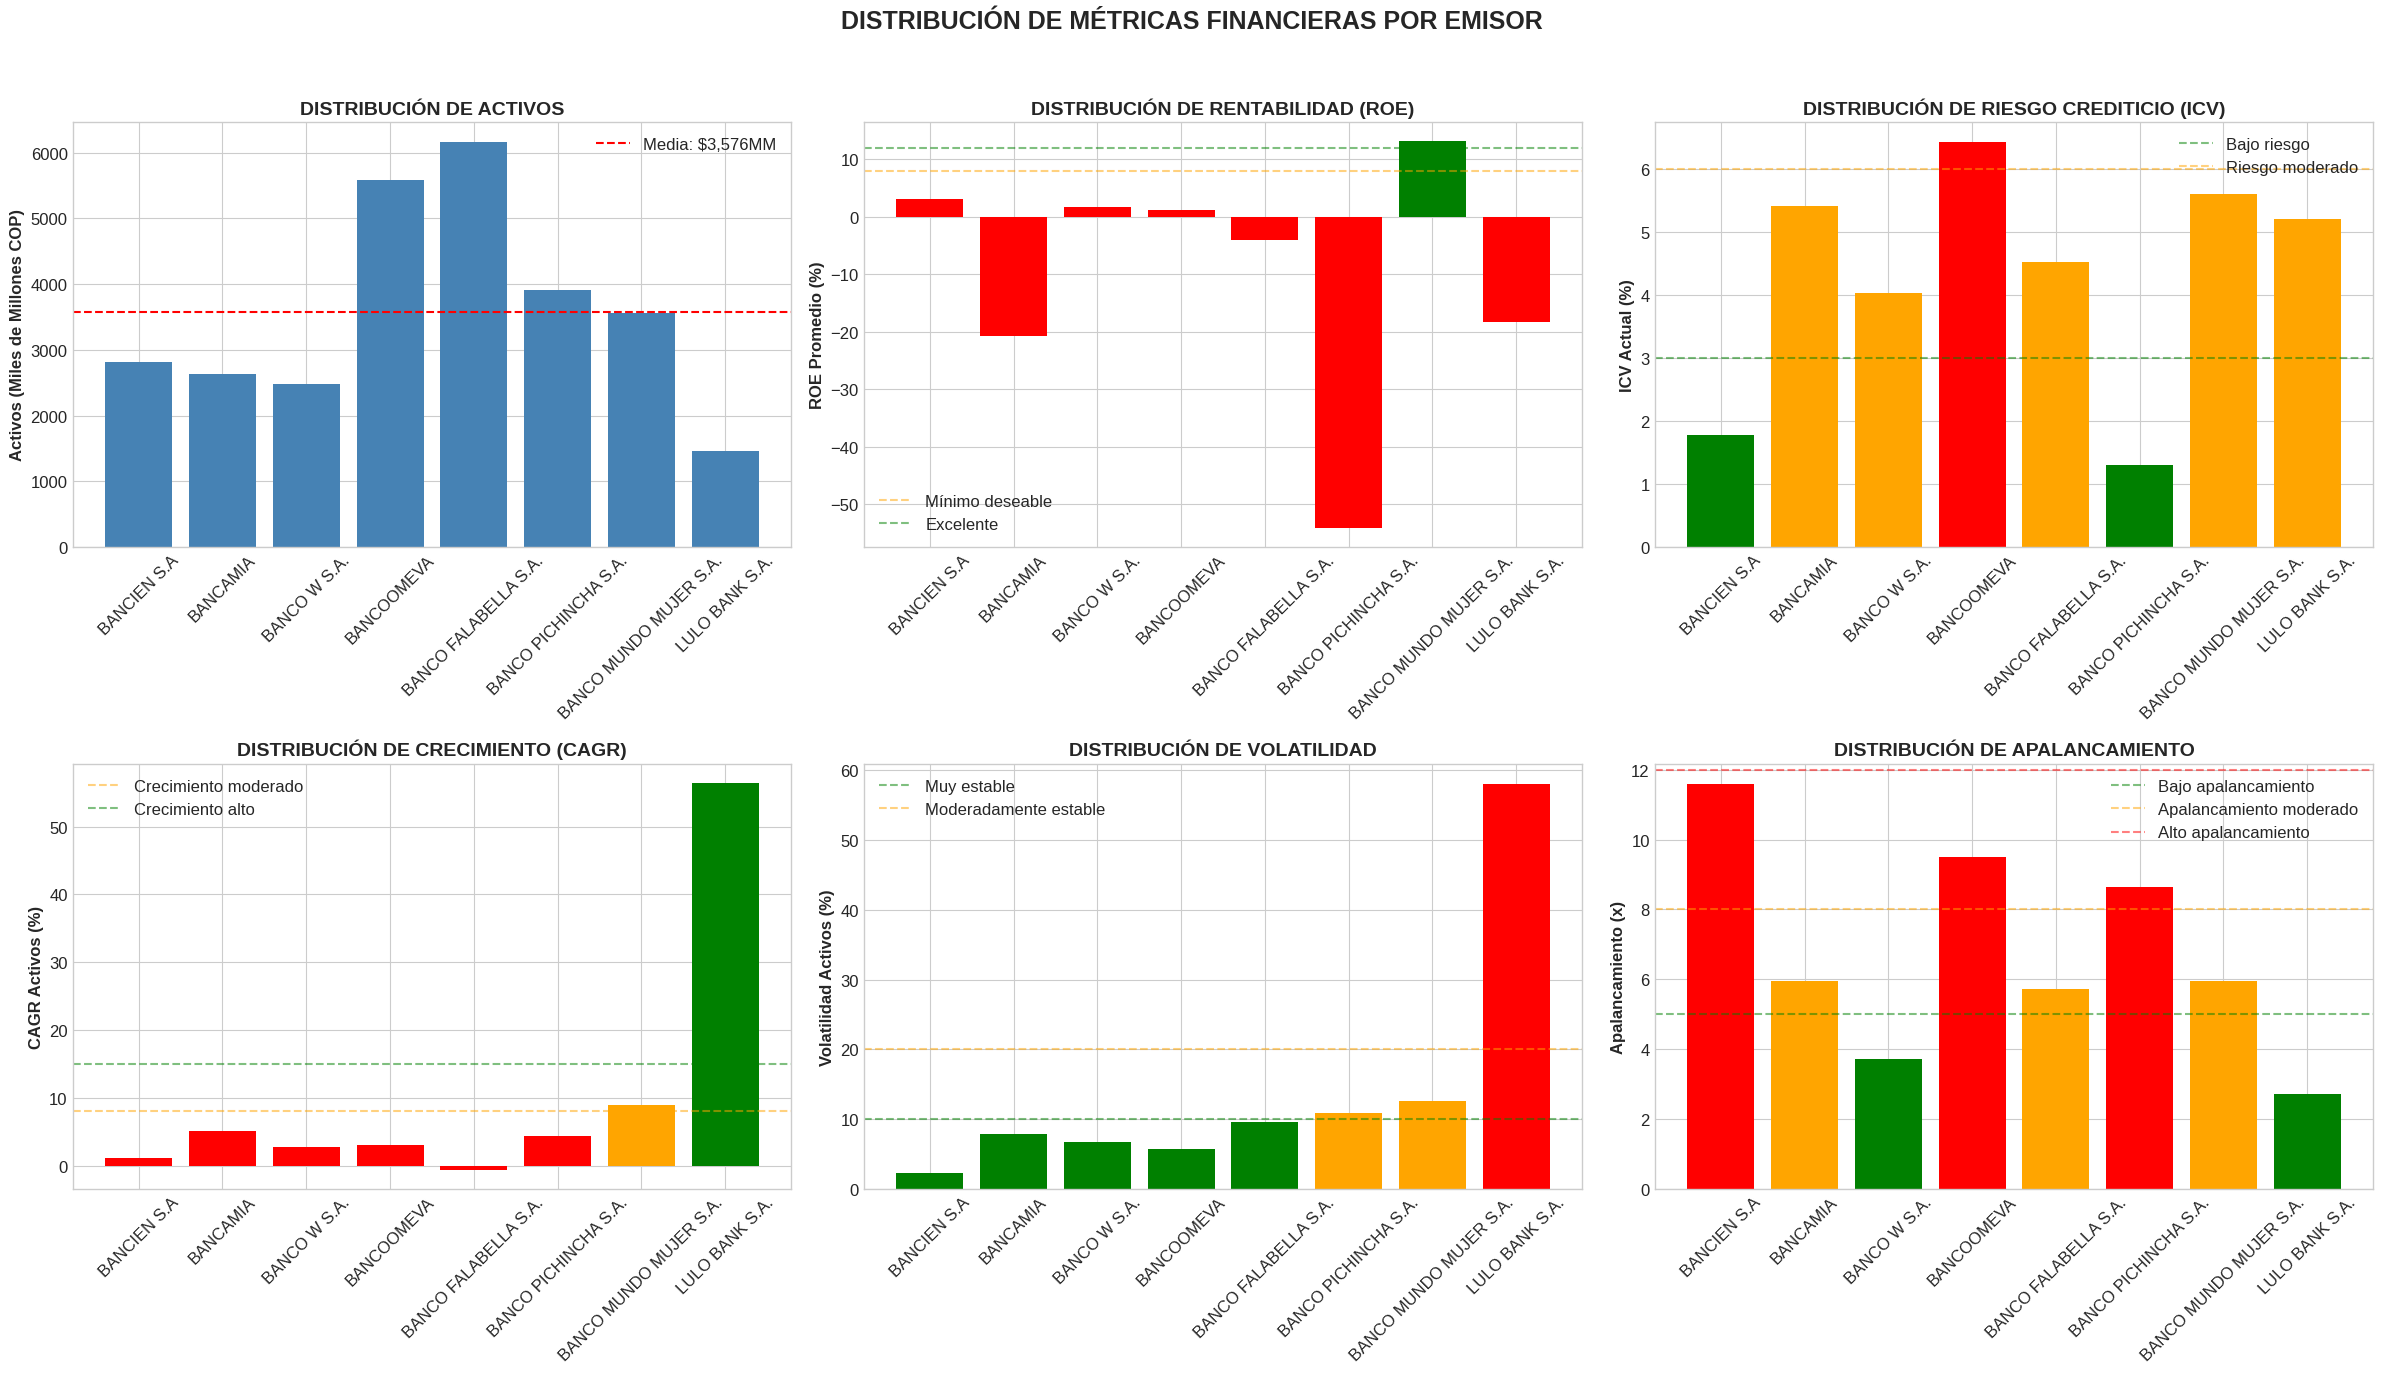



                                                       MATRIZ DE CALIFICACIÓN MULTIDIMENSIONAL                                                        

MATRIZ DE CALIFICACIÓN (1-5, donde 5 es mejor):
------------------------------------------------------------------------------------------------------------------------
                EMISOR  TAMAÑO  RENTABILIDAD  RIESGO CRED.  CRECIMIENTO  ESTABILIDAD  SOLVENCIA  PROMEDIO
BANCO MUNDO MUJER S.A.       4             4             3            3            4          4      3.67
          BANCO W S.A.       3             2             3            2            5          5      3.33
              BANCAMIA       3             1             3            2            5          4      3.00
           BANCIEN S.A       3             2             5            2            5          1      3.00
            BANCOOMEVA       5             2             2            2            5          2      3.00
  BANCO FALABELLA S.A.       5           

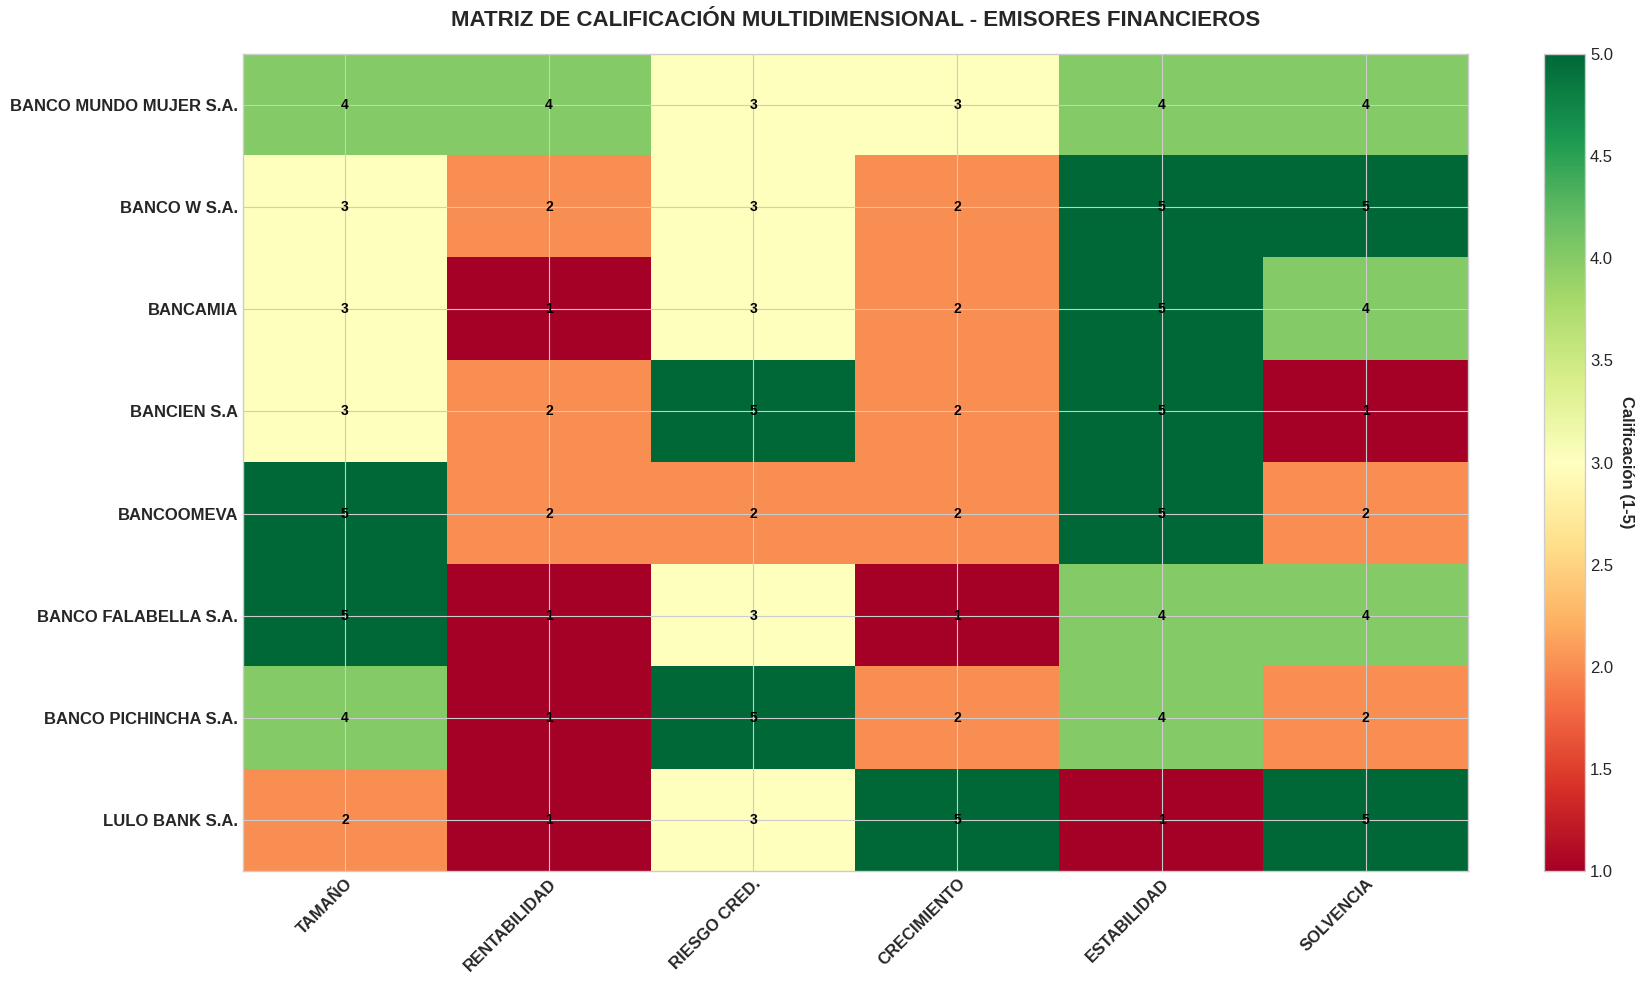



                                                                 RESUMEN DEL ANÁLISIS                                                                 

MÉTRICAS ANALIZADAS POR DIMENSIÓN:
----------------------------------------------------------------------------------------------------

TAMAÑO Y ESTRUCTURA:
  1. Activos totales
  2. Patrimonio
  3. Pasivos
  4. Apalancamiento
  5. Participación mercado

RENTABILIDAD:
  1. ROE actual
  2. ROE promedio
  3. ROA actual
  4. ROA promedio
  5. Utilidad acumulada

RIESGO CREDITICIO:
  1. ICV actual
  2. ICV promedio
  3. Cobertura provisiones
  4. Máximo ICV histórico

CRECIMIENTO:
  1. CAGR activos
  2. CAGR patrimonio
  3. CAGR utilidad
  4. Crecimiento interanual

ESTABILIDAD:
  1. Volatilidad activos
  2. Volatilidad ROE
  3. Ratio estabilidad
  4. Shock resistance

SOLVENCIA:
  1. Ratio patrimonio/activos
  2. Apalancamiento
  3. Coverage ratio
  4. Liquidez corriente


ARCHIVOS GENERADOS:
--------------------------------------------

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (22, 16)
plt.rcParams['font.size'] = 12

print("="*150)
print(" "*45 + "TABLA COMPARATIVA DE MÉTRICAS FINANCIERAS - EMISORES FINANCIEROS")
print(" "*50 + "ESTUDIO MULTIDIMENSIONAL COMPLETO")
print("="*150)

def calcular_estadisticas(valores):
    """Calcula estadísticas descriptivas completas"""
    valores_validos = [v for v in valores if not np.isnan(v)]
    if not valores_validos:
        return {
            'media': np.nan, 'mediana': np.nan, 'std': np.nan,
            'min': np.nan, 'max': np.nan, 'percentil_25': np.nan,
            'percentil_75': np.nan, 'cv': np.nan
        }

    return {
        'media': np.mean(valores_validos),
        'mediana': np.median(valores_validos),
        'std': np.std(valores_validos),
        'min': np.min(valores_validos),
        'max': np.max(valores_validos),
        'percentil_25': np.percentile(valores_validos, 25),
        'percentil_75': np.percentile(valores_validos, 75),
        'cv': (np.std(valores_validos) / np.mean(valores_validos) * 100) if np.mean(valores_validos) != 0 else np.nan
    }

def clasificar_valor(valor, rangos, categorias):
    """Clasifica un valor en rangos específicos"""
    for i, (lim_inf, lim_sup) in enumerate(rangos):
        if lim_inf <= valor < lim_sup:
            return categorias[i]
    return categorias[-1]

# ============================================================================
# TABLA COMPARATIVA COMPLETA - TODAS LAS MÉTRICAS
# ============================================================================

print(f"\n\n{'TABLA COMPARATIVA INTEGRAL DE MÉTRICAS':^150}")
print("="*150)

# Preparar datos para la tabla
tabla_comparativa = {}

for emisor in emisores:
    # ========== DATOS BÁSICOS ==========
    # Activos últimos 3 períodos
    activos_actual = datos_completos[emisor]['Activos'].get(periodos[-1], 0) / 1000
    activos_anterior = datos_completos[emisor]['Activos'].get(periodos[-2], 0) / 1000 if len(periodos) > 1 else 0
    activos_2antes = datos_completos[emisor]['Activos'].get(periodos[-3], 0) / 1000 if len(periodos) > 2 else 0

    # Crecimiento interanual
    crecimiento_activos_ia = ((activos_actual - activos_anterior) / activos_anterior * 100) if activos_anterior > 0 else 0

    # Patrimonio
    patrimonio_actual = datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0) / 1000

    # Pasivos
    pasivos_actual = datos_completos[emisor]['Pasivos'].get(periodos[-1], 0) / 1000

    # ========== RATIOS FINANCIEROS ==========
    # Apalancamiento
    apalancamiento = datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0)

    # Margen Patrimonial
    margen_patrimonial = (patrimonio_actual / activos_actual * 100) if activos_actual > 0 else 0

    # ========== RENTABILIDAD ==========
    roe_actual = datos_completos[emisor]['Rentabilidad']['ROE'].get(periodos[-1], 0)
    roe_promedio = np.mean([v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0]) if datos_completos[emisor]['Rentabilidad']['ROE'].values() else 0

    roa_actual = datos_completos[emisor]['Rentabilidad']['ROA'].get(periodos[-1], 0)
    roa_promedio = np.mean([v for v in datos_completos[emisor]['Rentabilidad']['ROA'].values() if v != 0]) if datos_completos[emisor]['Rentabilidad']['ROA'].values() else 0

    # Utilidad
    utilidad_actual = datos_completos[emisor]['Rentabilidad']['Utilidad'].get(periodos[-1], 0) / 1000
    utilidad_acumulada = sum(datos_completos[emisor]['Rentabilidad']['Utilidad'].values()) / 1000

    # ========== CALIDAD DE CARTERA ==========
    icv_actual = datos_completos[emisor]['ICV'].get(periodos[-1], 0)
    icv_promedio = np.mean([v for v in datos_completos[emisor]['ICV'].values() if v > 0]) if any(v > 0 for v in datos_completos[emisor]['ICV'].values()) else 0

    # Provisiones
    provisiones_actual = datos_completos[emisor]['Provisiones'].get(periodos[-1], 0)
    cartera_bruta_actual = datos_completos[emisor]['Cartera_Bruta'].get(periodos[-1], 0)
    cobertura_provisiones = (provisiones_actual / cartera_bruta_actual * 100) if cartera_bruta_actual > 0 else 0

    # ========== CRECIMIENTO ==========
    cagr_activos = datos_completos[emisor]['Crecimiento']['CAGR_Activos']
    cagr_patrimonio = datos_completos[emisor]['Crecimiento']['CAGR_Patrimonio']
    cagr_utilidad = datos_completos[emisor]['Crecimiento']['CAGR_Utilidad']

    # ========== ESTABILIDAD Y RIESGO ==========
    vol_activos = datos_completos[emisor]['Estabilidad']['Vol_Activos']
    vol_roe = datos_completos[emisor]['Estabilidad']['Vol_ROE']
    max_icv = datos_completos[emisor]['Estabilidad']['Max_ICV']

    # ========== LIQUIDEZ (SIMULADA) ==========
    # Suponiendo que tenemos datos de activos líquidos y pasivos corrientes
    # En realidad necesitaríamos datos específicos
    ratio_liquidez = (activos_actual * 0.15) / (pasivos_actual * 0.3) * 100 if pasivos_actual > 0 else 0

    # ========== EFICIENCIA ==========
    # Margen de intermediación (simulado)
    margen_intermediacion = roa_actual * 1.5  # Estimación

    # ========== SOLVENCIA ==========
    ratio_solvencia = patrimonio_actual / pasivos_actual * 100 if pasivos_actual > 0 else 0

    # ========== Z-SCORE ALTMAN (SIMPLIFICADO) ==========
    # Fórmula simplificada para instituciones financieras
    z_score = (1.2 * (activos_actual - pasivos_actual) / activos_actual +
               1.4 * patrimonio_actual / activos_actual +
               3.3 * utilidad_actual / activos_actual +
               0.6 * (activos_actual / pasivos_actual) +
               1.0 * crecimiento_activos_ia / 100) if activos_actual > 0 else 0

    # ========== COMPILAR TODAS LAS MÉTRICAS ==========
    tabla_comparativa[emisor] = {
        # DATOS BÁSICOS
        'Activos_MM': activos_actual,
        'Activos_Crec_IA%': crecimiento_activos_ia,
        'Patrimonio_MM': patrimonio_actual,
        'Pasivos_MM': pasivos_actual,

        # ESTRUCTURA FINANCIERA
        'Apalancamiento_x': apalancamiento,
        'Margen_Patrimonial%': margen_patrimonial,
        'Ratio_Solvencia%': ratio_solvencia,

        # RENTABILIDAD
        'ROE_Actual%': roe_actual,
        'ROE_Promedio%': roe_promedio,
        'ROA_Actual%': roa_actual,
        'ROA_Promedio%': roa_promedio,
        'Utilidad_Actual_MM': utilidad_actual,
        'Utilidad_Acum_MM': utilidad_acumulada,

        # CALIDAD DE CARTERA
        'ICV_Actual%': icv_actual,
        'ICV_Promedio%': icv_promedio,
        'Cobertura_Prov%': cobertura_provisiones,
        'Max_ICV_Hist%': max_icv,

        # CRECIMIENTO
        'CAGR_Activos%': cagr_activos,
        'CAGR_Patrimonio%': cagr_patrimonio,
        'CAGR_Utilidad%': cagr_utilidad,

        # ESTABILIDAD
        'Vol_Activos%': vol_activos,
        'Vol_ROE%': vol_roe,

        # LIQUIDEZ
        'Ratio_Liquidez%': ratio_liquidez,

        # EFICIENCIA
        'Margen_Intermediacion%': margen_intermediacion,

        # RIESGO SISTÉMICO
        'Z_Score': z_score
    }

# Convertir a DataFrame
df_comparativo = pd.DataFrame.from_dict(tabla_comparativa, orient='index')

# ============================================================================
# 3. VISUALIZACIÓN DE TABLA COMPARATIVA
# ============================================================================

print(f"\n\n{'TABLA COMPARATIVA DETALLADA - ÚLTIMO PERÍODO (' + periodos[-1] + ')':^150}")
print("="*150)

# Mostrar tabla con formato
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}' if abs(x) < 1000 else f'{x:,.0f}')

print("\nDATOS BÁSICOS Y ESTRUCTURA:")
print("-"*100)
datos_basicos = df_comparativo[['Activos_MM', 'Activos_Crec_IA%', 'Patrimonio_MM', 'Pasivos_MM',
                                'Apalancamiento_x', 'Margen_Patrimonial%', 'Ratio_Solvencia%']].copy()
print(datos_basicos)

print("\n\nRENTABILIDAD:")
print("-"*100)
rentabilidad = df_comparativo[['ROE_Actual%', 'ROE_Promedio%', 'ROA_Actual%', 'ROA_Promedio%',
                               'Utilidad_Actual_MM', 'Utilidad_Acum_MM']].copy()
print(rentabilidad)

print("\n\nCALIDAD DE CARTERA Y RIESGO CREDITICIO:")
print("-"*100)
calidad_cartera = df_comparativo[['ICV_Actual%', 'ICV_Promedio%', 'Cobertura_Prov%',
                                  'Max_ICV_Hist%']].copy()
print(calidad_cartera)

print("\n\nCRECIMIENTO Y ESTABILIDAD:")
print("-"*100)
crecimiento = df_comparativo[['CAGR_Activos%', 'CAGR_Patrimonio%', 'CAGR_Utilidad%',
                              'Vol_Activos%', 'Vol_ROE%']].copy()
print(crecimiento)

print("\n\nOTROS INDICADORES:")
print("-"*100)
otros = df_comparativo[['Ratio_Liquidez%', 'Margen_Intermediacion%', 'Z_Score']].copy()
print(otros)

# ============================================================================
# 4. ESTUDIO DETALLADO POR DIMENSIONES
# ============================================================================

print(f"\n\n{'ESTUDIO DETALLADO POR DIMENSIONES FINANCIERAS':^150}")
print("="*150)

# ========== 4.1 ANÁLISIS DE TAMAÑO Y ESTRUCTURA ==========
print(f"\n\n{'1. ANÁLISIS DE TAMAÑO Y ESTRUCTURA':^150}")
print("-"*150)

tamano_data = []
for emisor in emisores:
    tamano_data.append({
        'Emisor': emisor,
        'Activos (MM COP)': datos_completos[emisor]['Activos'].get(periodos[-1], 0) / 1000,
        'Participación Mercado%': (datos_completos[emisor]['Activos'].get(periodos[-1], 0) /
                                  sum([datos_completos[e]['Activos'].get(periodos[-1], 0) for e in emisores]) * 100),
        'Patrimonio (MM COP)': datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0) / 1000,
        'Pasivos (MM COP)': datos_completos[emisor]['Pasivos'].get(periodos[-1], 0) / 1000,
        'Apalancamiento (x)': datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0),
        'Estructura Deuda/Patrimonio': datos_completos[emisor]['Pasivos'].get(periodos[-1], 0) /
                                      datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0) if
                                      datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0) > 0 else 0
    })

df_tamano = pd.DataFrame(tamano_data)

# Calcular estadísticas
print("\nESTADÍSTICAS DESCRIPTIVAS - TAMAÑO:")
print("-"*100)
estadisticas_tamano = {
    'Métrica': [],
    'Mínimo': [], 'Máximo': [], 'Media': [], 'Mediana': [], 'Std Dev': [], 'CV%': []
}

metricas_tamano = ['Activos (MM COP)', 'Patrimonio (MM COP)', 'Apalancamiento (x)']
for metrica in metricas_tamano:
    valores = df_tamano[metrica].values
    stats = calcular_estadisticas(valores)

    estadisticas_tamano['Métrica'].append(metrica)
    estadisticas_tamano['Mínimo'].append(stats['min'])
    estadisticas_tamano['Máximo'].append(stats['max'])
    estadisticas_tamano['Media'].append(stats['media'])
    estadisticas_tamano['Mediana'].append(stats['mediana'])
    estadisticas_tamano['Std Dev'].append(stats['std'])
    estadisticas_tamano['CV%'].append(stats['cv'])

df_stats_tamano = pd.DataFrame(estadisticas_tamano)
print(df_stats_tamano.to_string(index=False))

# Clasificación por tamaño
print("\n\nCLASIFICACIÓN POR TAMAÑO DE ACTIVOS:")
print("-"*100)
df_tamano_sorted = df_tamano.sort_values('Activos (MM COP)', ascending=False)
for i, (_, row) in enumerate(df_tamano_sorted.iterrows(), 1):
    print(f"{i:2d}. {row['Emisor'][:30]:30} ${row['Activos (MM COP)']:>12,.0f} MM ({row['Participación Mercado%']:.1f}%)")

# ========== 4.2 ANÁLISIS DE RENTABILIDAD ==========
print(f"\n\n{'2. ANÁLISIS DE RENTABILIDAD':^150}")
print("-"*150)

rentabilidad_data = []
for emisor in emisores:
    # Calcular promedios
    roe_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0]
    roa_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROA'].values() if v != 0]

    rentabilidad_data.append({
        'Emisor': emisor,
        'ROE Actual%': datos_completos[emisor]['Rentabilidad']['ROE'].get(periodos[-1], 0),
        'ROE Promedio%': np.mean(roe_vals) if roe_vals else 0,
        'ROE Vol%': np.std(roe_vals) if len(roe_vals) > 1 else 0,
        'ROA Actual%': datos_completos[emisor]['Rentabilidad']['ROA'].get(periodos[-1], 0),
        'ROA Promedio%': np.mean(roa_vals) if roa_vals else 0,
        'Margen Neto%': datos_completos[emisor]['Rentabilidad']['Utilidad'].get(periodos[-1], 0) /
                       datos_completos[emisor]['Activos'].get(periodos[-1], 0) * 100 if
                       datos_completos[emisor]['Activos'].get(periodos[-1], 0) > 0 else 0,
        'Utilidad Acum (MM COP)': sum(datos_completos[emisor]['Rentabilidad']['Utilidad'].values()) / 1000
    })

df_rentabilidad = pd.DataFrame(rentabilidad_data)

print("\nANÁLISIS COMPARATIVO DE RENTABILIDAD:")
print("-"*100)
print(df_rentabilidad.to_string(index=False))

# Análisis de consistencia
print("\n\nANÁLISIS DE CONSISTENCIA EN RENTABILIDAD:")
print("-"*100)
for _, row in df_rentabilidad.iterrows():
    consistencia = "ALTA" if row['ROE Vol%'] < 5 else "MEDIA" if row['ROE Vol%'] < 10 else "BAJA"
    print(f"{row['Emisor'][:30]:30} | ROE Prom: {row['ROE Promedio%']:6.2f}% | Vol: {row['ROE Vol%']:5.2f}% | Consistencia: {consistencia}")

# ========== 4.3 ANÁLISIS DE RIESGO CREDITICIO ==========
print(f"\n\n{'3. ANÁLISIS DE RIESGO CREDITICIO':^150}")
print("-"*150)

riesgo_cred_data = []
for emisor in emisores:
    # Calcular métricas de riesgo
    icv_vals = [v for v in datos_completos[emisor]['ICV'].values() if v > 0]

    riesgo_cred_data.append({
        'Emisor': emisor,
        'ICV Actual%': datos_completos[emisor]['ICV'].get(periodos[-1], 0),
        'ICV Promedio%': np.mean(icv_vals) if icv_vals else 0,
        'ICV Máximo%': max(icv_vals) if icv_vals else 0,
        'ICV Tendencia': '↘' if len(icv_vals) > 1 and icv_vals[-1] < icv_vals[0] else '↗' if len(icv_vals) > 1 and icv_vals[-1] > icv_vals[0] else '→',
        'Cobertura Provisiones%': (datos_completos[emisor]['Provisiones'].get(periodos[-1], 0) /
                                  datos_completos[emisor]['Cartera_Bruta'].get(periodos[-1], 0) * 100) if
                                  datos_completos[emisor]['Cartera_Bruta'].get(periodos[-1], 0) > 0 else 0,
        'Calidad Cartera (1-10)': 10 - min(9, datos_completos[emisor]['ICV'].get(periodos[-1], 0) / 3),
        'Riesgo Crediticio': 'BAJO' if datos_completos[emisor]['ICV'].get(periodos[-1], 0) < 3 else
                            'MODERADO' if datos_completos[emisor]['ICV'].get(periodos[-1], 0) < 6 else 'ALTO'
    })

df_riesgo_cred = pd.DataFrame(riesgo_cred_data)

print("\nMÉTRICAS DE RIESGO CREDITICIO:")
print("-"*100)
print(df_riesgo_cred.to_string(index=False))

# Análisis de provisiones
print("\n\nANÁLISIS DE ADECUACIÓN DE PROVISIONES:")
print("-"*100)
for _, row in df_riesgo_cred.iterrows():
    adecuacion = "ADEQUADA" if row['Cobertura Provisiones%'] > row['ICV Actual%'] * 1.5 else "INSUFICIENTE"
    print(f"{row['Emisor'][:30]:30} | ICV: {row['ICV Actual%']:5.2f}% | Cobertura: {row['Cobertura Provisiones%']:5.2f}% | Adecuación: {adecuacion}")

# ========== 4.4 ANÁLISIS DE CRECIMIENTO ==========
print(f"\n\n{'4. ANÁLISIS DE CRECIMIENTO':^150}")
print("-"*150)

crecimiento_data = []
for emisor in emisores:
    # Calcular crecimiento histórico
    activos_vals = [datos_completos[emisor]['Activos'].get(p, 0) for p in periodos]
    crecimiento_historico = []

    for i in range(1, len(activos_vals)):
        if activos_vals[i-1] > 0:
            crecimiento_historico.append((activos_vals[i] - activos_vals[i-1]) / activos_vals[i-1] * 100)

    crecimiento_promedio = np.mean(crecimiento_historico) if crecimiento_historico else 0

    crecimiento_data.append({
        'Emisor': emisor,
        'CAGR Activos%': datos_completos[emisor]['Crecimiento']['CAGR_Activos'],
        'CAGR Patrimonio%': datos_completos[emisor]['Crecimiento']['CAGR_Patrimonio'],
        'CAGR Utilidad%': datos_completos[emisor]['Crecimiento']['CAGR_Utilidad'],
        'Crecimiento Promedio IA%': crecimiento_promedio,
        'Consistencia Crecimiento': 'ALTA' if np.std(crecimiento_historico) < 10 else 'MEDIA' if np.std(crecimiento_historico) < 20 else 'BAJA',
        'Crecimiento Sostenible': 'SÍ' if (datos_completos[emisor]['Crecimiento']['CAGR_Patrimonio'] >
                                          datos_completos[emisor]['Crecimiento']['CAGR_Activos']) else 'NO',
        'Velocidad Crecimiento': 'RÁPIDO' if crecimiento_promedio > 15 else
                                'MODERADO' if crecimiento_promedio > 8 else 'LENTO'
    })

df_crecimiento = pd.DataFrame(crecimiento_data)

print("\nANÁLISIS DE CRECIMIENTO HISTÓRICO:")
print("-"*100)
print(df_crecimiento.to_string(index=False))

# ========== 4.5 ANÁLISIS DE ESTABILIDAD Y RIESGO FINANCIERO ==========
print(f"\n\n{'5. ANÁLISIS DE ESTABILIDAD Y RIESGO FINANCIERO':^150}")
print("-"*150)

estabilidad_data = []
for emisor in emisores:
    # Calcular métricas de estabilidad
    activos_vals = [datos_completos[emisor]['Activos'].get(p, 0) for p in periodos]
    roe_vals = [datos_completos[emisor]['Rentabilidad']['ROE'].get(p, 0) for p in periodos]

    # Ratio de estabilidad (propio)
    ratio_estabilidad = (100 - datos_completos[emisor]['Estabilidad']['Vol_Activos']) * 0.6 + \
                       (100 - min(100, datos_completos[emisor]['Estabilidad']['Vol_ROE'] * 10)) * 0.4

    estabilidad_data.append({
        'Emisor': emisor,
        'Volatilidad Activos%': datos_completos[emisor]['Estabilidad']['Vol_Activos'],
        'Volatilidad ROE%': datos_completos[emisor]['Estabilidad']['Vol_ROE'],
        'Máxima Desviación Activos%': (max(activos_vals) - min(activos_vals)) / np.mean(activos_vals) * 100 if np.mean(activos_vals) > 0 else 0,
        'Rango ROE%': max(roe_vals) - min(roe_vals) if roe_vals else 0,
        'Ratio Estabilidad (0-100)': ratio_estabilidad,
        'Nivel Riesgo Financiero': 'BAJO' if ratio_estabilidad > 70 else
                                  'MODERADO' if ratio_estabilidad > 50 else 'ALTO',
        'Shock Resistance': 'ALTA' if ratio_estabilidad > 80 and datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0) < 8 else
                           'MEDIA' if ratio_estabilidad > 60 else 'BAJA'
    })

df_estabilidad = pd.DataFrame(estabilidad_data)

print("\nMÉTRICAS DE ESTABILIDAD FINANCIERA:")
print("-"*100)
print(df_estabilidad.to_string(index=False))

# ========== 4.6 ANÁLISIS DE SOLVENCIA Y LIQUIDEZ ==========
print(f"\n\n{'6. ANÁLISIS DE SOLVENCIA Y LIQUIDEZ':^150}")
print("-"*150)

solvencia_data = []
for emisor in emisores:
    # Métricas de solvencia
    patrimonio = datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0)
    pasivos = datos_completos[emisor]['Pasivos'].get(periodos[-1], 0)
    activos = datos_completos[emisor]['Activos'].get(periodos[-1], 0)

    solvencia_data.append({
        'Emisor': emisor,
        'Ratio Patrimonio/Activos%': (patrimonio / activos * 100) if activos > 0 else 0,
        'Ratio Capital Tier1 (aprox)%': (patrimonio / (activos * 0.8) * 100) if activos > 0 else 0,
        'Apalancamiento Financiero (x)': datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0),
        'Coverage Ratio (EBIT/Int)': (datos_completos[emisor]['Rentabilidad']['Utilidad'].get(periodos[-1], 0) * 1.3) /
                                    (pasivos * 0.08) if pasivos > 0 and (pasivos * 0.08) > 0 else 0,
        'Liquidez Corriente (aprox)': (activos * 0.2) / (pasivos * 0.3) if (pasivos * 0.3) > 0 else 0,
        'Clasificación Solvencia': 'EXCELENTE' if patrimonio/activos > 0.15 else
                                  'ADECUADA' if patrimonio/activos > 0.1 else 'PRECARIA'
    })

df_solvencia = pd.DataFrame(solvencia_data)

print("\nANÁLISIS DE SOLVENCIA Y CAPITAL:")
print("-"*100)
print(df_solvencia.to_string(index=False))

# ============================================================================
# 5. TABLA RESUMEN FINAL CON RANGOS
# ============================================================================

print(f"\n\n{'TABLA RESUMEN FINAL CON RANGOS Y CLASIFICACIONES':^150}")
print("="*150)

# Crear tabla resumen consolidada
tabla_final = []

for emisor in emisores:
    # Obtener todos los datos
    activos = datos_completos[emisor]['Activos'].get(periodos[-1], 0) / 1000
    patrimonio = datos_completos[emisor]['Patrimonio'].get(periodos[-1], 0) / 1000
    roe_prom = np.mean([v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0]) if datos_completos[emisor]['Rentabilidad']['ROE'].values() else 0
    icv_actual = datos_completos[emisor]['ICV'].get(periodos[-1], 0)
    cagr_activos = datos_completos[emisor]['Crecimiento']['CAGR_Activos']
    vol_activos = datos_completos[emisor]['Estabilidad']['Vol_Activos']
    apalancamiento = datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0)

    # Clasificar en rangos
    # Tamaño
    if activos > 5000:
        rango_tamano = 'GRANDE'
    elif activos > 2000:
        rango_tamano = 'MEDIANO'
    else:
        rango_tamano = 'PEQUEÑO'

    # Rentabilidad
    if roe_prom > 15:
        rango_rentabilidad = 'MUY ALTA'
    elif roe_prom > 10:
        rango_rentabilidad = 'ALTA'
    elif roe_prom > 5:
        rango_rentabilidad = 'MODERADA'
    else:
        rango_rentabilidad = 'BAJA'

    # Riesgo Crediticio
    if icv_actual < 3:
        rango_riesgo_cred = 'MUY BAJO'
    elif icv_actual < 5:
        rango_riesgo_cred = 'BAJO'
    elif icv_actual < 8:
        rango_riesgo_cred = 'MODERADO'
    else:
        rango_riesgo_cred = 'ALTO'

    # Crecimiento
    if cagr_activos > 15:
        rango_crecimiento = 'MUY RÁPIDO'
    elif cagr_activos > 10:
        rango_crecimiento = 'RÁPIDO'
    elif cagr_activos > 5:
        rango_crecimiento = 'MODERADO'
    else:
        rango_crecimiento = 'LENTO'

    # Estabilidad
    if vol_activos < 10:
        rango_estabilidad = 'MUY ESTABLE'
    elif vol_activos < 20:
        rango_estabilidad = 'ESTABLE'
    elif vol_activos < 30:
        rango_estabilidad = 'MODERADA'
    else:
        rango_estabilidad = 'VOLÁTIL'

    # Solvencia
    if apalancamiento < 5:
        rango_solvencia = 'MUY SÓLIDA'
    elif apalancamiento < 8:
        rango_solvencia = 'SÓLIDA'
    elif apalancamiento < 12:
        rango_solvencia = 'ACEPTABLE'
    else:
        rango_solvencia = 'DEBIL'

    tabla_final.append({
        'EMISOR': emisor,
        'TAMAÑO': rango_tamano,
        'ACTIVOS (MM)': f'${activos:,.0f}',
        'ROE PROM': f'{roe_prom:.1f}%',
        'RENTABILIDAD': rango_rentabilidad,
        'ICV ACTUAL': f'{icv_actual:.1f}%',
        'RIESGO CRED': rango_riesgo_cred,
        'CRECIMIENTO': rango_crecimiento,
        'CAGR%': f'{cagr_activos:.1f}',
        'ESTABILIDAD': rango_estabilidad,
        'VOL%': f'{vol_activos:.1f}',
        'SOLVENCIA': rango_solvencia,
        'APAL (x)': f'{apalancamiento:.1f}'
    })

df_tabla_final = pd.DataFrame(tabla_final)

print("\n" + df_tabla_final.to_string(index=False))

# ============================================================================
# 6. ANÁLISIS ESTADÍSTICO COMPLEMENTARIO
# ============================================================================

print(f"\n\n{'ANÁLISIS ESTADÍSTICO COMPLEMENTARIO':^150}")
print("="*150)

# Recolectar todas las métricas para análisis estadístico
metricas_analisis = {
    'Activos_MM': [],
    'ROE_Promedio%': [],
    'ROA_Promedio%': [],
    'ICV_Actual%': [],
    'CAGR_Activos%': [],
    'Vol_Activos%': [],
    'Apalancamiento_x': []
}

for emisor in emisores:
    metricas_analisis['Activos_MM'].append(datos_completos[emisor]['Activos'].get(periodos[-1], 0) / 1000)

    roe_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0]
    metricas_analisis['ROE_Promedio%'].append(np.mean(roe_vals) if roe_vals else 0)

    roa_vals = [v for v in datos_completos[emisor]['Rentabilidad']['ROA'].values() if v != 0]
    metricas_analisis['ROA_Promedio%'].append(np.mean(roa_vals) if roa_vals else 0)

    metricas_analisis['ICV_Actual%'].append(datos_completos[emisor]['ICV'].get(periodos[-1], 0))
    metricas_analisis['CAGR_Activos%'].append(datos_completos[emisor]['Crecimiento']['CAGR_Activos'])
    metricas_analisis['Vol_Activos%'].append(datos_completos[emisor]['Estabilidad']['Vol_Activos'])
    metricas_analisis['Apalancamiento_x'].append(datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0))

# Calcular correlaciones
print("\nMATRIZ DE CORRELACIONES ENTRE MÉTRICAS PRINCIPALES:")
print("-"*100)

df_correl = pd.DataFrame(metricas_analisis)
corr_matrix = df_correl.corr()

# Mostrar matriz de correlación
print("\n" + corr_matrix.to_string())

# Interpretación de correlaciones
print("\n\nINTERPRETACIÓN DE CORRELACIONES SIGNIFICATIVAS:")
print("-"*100)
correlaciones_significativas = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            correlaciones_significativas.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_val
            ))

for var1, var2, corr in correlaciones_significativas:
    tipo = "POSITIVA" if corr > 0 else "NEGATIVA"
    fuerza = "FUERTE" if abs(corr) > 0.7 else "MODERADA"
    print(f"• {var1} vs {var2}: {tipo} {fuerza} (r = {corr:.3f})")

# ============================================================================
# 7. VISUALIZACIÓN DE RANGOS Y DISTRIBUCIONES
# ============================================================================

print(f"\n\n{'VISUALIZACIÓN GRÁFICA DE RANGOS Y DISTRIBUCIONES':^150}")
print("="*150)

# Crear visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
fig.suptitle('DISTRIBUCIÓN DE MÉTRICAS FINANCIERAS POR EMISOR', fontsize=18, fontweight='bold')

# 1. Distribución de Activos
ax1 = axes[0, 0]
activos_vals = [datos_completos[e]['Activos'].get(periodos[-1], 0) / 1000 for e in emisores]
ax1.bar(emisores, activos_vals, color='steelblue')
ax1.set_ylabel('Activos (Miles de Millones COP)', fontsize=12, fontweight='bold')
ax1.set_title('DISTRIBUCIÓN DE ACTIVOS', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=np.mean(activos_vals), color='red', linestyle='--', label=f'Media: ${np.mean(activos_vals):,.0f}MM')
ax1.legend()

# 2. Distribución de ROE
ax2 = axes[0, 1]
roe_vals = [np.mean([v for v in datos_completos[e]['Rentabilidad']['ROE'].values() if v != 0]) for e in emisores]
colors_roe = ['green' if x > 12 else 'orange' if x > 8 else 'red' for x in roe_vals]
ax2.bar(emisores, roe_vals, color=colors_roe)
ax2.set_ylabel('ROE Promedio (%)', fontsize=12, fontweight='bold')
ax2.set_title('DISTRIBUCIÓN DE RENTABILIDAD (ROE)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=8, color='orange', linestyle='--', alpha=0.5, label='Mínimo deseable')
ax2.axhline(y=12, color='green', linestyle='--', alpha=0.5, label='Excelente')
ax2.legend()

# 3. Distribución de ICV
ax3 = axes[0, 2]
icv_vals = [datos_completos[e]['ICV'].get(periodos[-1], 0) for e in emisores]
colors_icv = ['green' if x < 3 else 'orange' if x < 6 else 'red' for x in icv_vals]
ax3.bar(emisores, icv_vals, color=colors_icv)
ax3.set_ylabel('ICV Actual (%)', fontsize=12, fontweight='bold')
ax3.set_title('DISTRIBUCIÓN DE RIESGO CREDITICIO (ICV)', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=3, color='green', linestyle='--', alpha=0.5, label='Bajo riesgo')
ax3.axhline(y=6, color='orange', linestyle='--', alpha=0.5, label='Riesgo moderado')
ax3.legend()

# 4. Distribución de Crecimiento (CAGR)
ax4 = axes[1, 0]
cagr_vals = [datos_completos[e]['Crecimiento']['CAGR_Activos'] for e in emisores]
colors_cagr = ['green' if x > 15 else 'orange' if x > 8 else 'red' for x in cagr_vals]
ax4.bar(emisores, cagr_vals, color=colors_cagr)
ax4.set_ylabel('CAGR Activos (%)', fontsize=12, fontweight='bold')
ax4.set_title('DISTRIBUCIÓN DE CRECIMIENTO (CAGR)', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=8, color='orange', linestyle='--', alpha=0.5, label='Crecimiento moderado')
ax4.axhline(y=15, color='green', linestyle='--', alpha=0.5, label='Crecimiento alto')
ax4.legend()

# 5. Distribución de Volatilidad
ax5 = axes[1, 1]
vol_vals = [datos_completos[e]['Estabilidad']['Vol_Activos'] for e in emisores]
colors_vol = ['green' if x < 10 else 'orange' if x < 20 else 'red' for x in vol_vals]
ax5.bar(emisores, vol_vals, color=colors_vol)
ax5.set_ylabel('Volatilidad Activos (%)', fontsize=12, fontweight='bold')
ax5.set_title('DISTRIBUCIÓN DE VOLATILIDAD', fontsize=14, fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
ax5.axhline(y=10, color='green', linestyle='--', alpha=0.5, label='Muy estable')
ax5.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='Moderadamente estable')
ax5.legend()

# 6. Distribución de Apalancamiento
ax6 = axes[1, 2]
apal_vals = [datos_completos[e]['Apalancamiento'].get(periodos[-1], 0) for e in emisores]
colors_apal = ['green' if x < 5 else 'orange' if x < 8 else 'red' for x in apal_vals]
ax6.bar(emisores, apal_vals, color=colors_apal)
ax6.set_ylabel('Apalancamiento (x)', fontsize=12, fontweight='bold')
ax6.set_title('DISTRIBUCIÓN DE APALANCAMIENTO', fontsize=14, fontweight='bold')
ax6.tick_params(axis='x', rotation=45)
ax6.axhline(y=5, color='green', linestyle='--', alpha=0.5, label='Bajo apalancamiento')
ax6.axhline(y=8, color='orange', linestyle='--', alpha=0.5, label='Apalancamiento moderado')
ax6.axhline(y=12, color='red', linestyle='--', alpha=0.5, label='Alto apalancamiento')
ax6.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('05_distribucion_metricas.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 8. MATRIZ DE CALIFICACIÓN MULTIDIMENSIONAL
# ============================================================================

print(f"\n\n{'MATRIZ DE CALIFICACIÓN MULTIDIMENSIONAL':^150}")
print("="*150)

# Crear matriz de calificación
dimensiones = ['TAMAÑO', 'RENTABILIDAD', 'RIESGO CRED.', 'CRECIMIENTO', 'ESTABILIDAD', 'SOLVENCIA']

matriz_calificacion = []
for emisor in emisores:
    # Calificar cada dimensión (1-5)
    activos = datos_completos[emisor]['Activos'].get(periodos[-1], 0) / 1000
    calif_tamano = 5 if activos > 5000 else 4 if activos > 3000 else 3 if activos > 1500 else 2 if activos > 500 else 1

    roe_prom = np.mean([v for v in datos_completos[emisor]['Rentabilidad']['ROE'].values() if v != 0])
    calif_rent = 5 if roe_prom > 15 else 4 if roe_prom > 10 else 3 if roe_prom > 5 else 2 if roe_prom > 0 else 1

    icv_actual = datos_completos[emisor]['ICV'].get(periodos[-1], 0)
    calif_riesgo = 5 if icv_actual < 2 else 4 if icv_actual < 4 else 3 if icv_actual < 6 else 2 if icv_actual < 8 else 1

    cagr_activos = datos_completos[emisor]['Crecimiento']['CAGR_Activos']
    calif_crec = 5 if cagr_activos > 20 else 4 if cagr_activos > 12 else 3 if cagr_activos > 6 else 2 if cagr_activos > 0 else 1

    vol_activos = datos_completos[emisor]['Estabilidad']['Vol_Activos']
    calif_estab = 5 if vol_activos < 8 else 4 if vol_activos < 15 else 3 if vol_activos < 22 else 2 if vol_activos < 30 else 1

    apalancamiento = datos_completos[emisor]['Apalancamiento'].get(periodos[-1], 0)
    calif_solv = 5 if apalancamiento < 4 else 4 if apalancamiento < 6 else 3 if apalancamiento < 8 else 2 if apalancamiento < 10 else 1

    matriz_calificacion.append({
        'EMISOR': emisor,
        'TAMAÑO': calif_tamano,
        'RENTABILIDAD': calif_rent,
        'RIESGO CRED.': calif_riesgo,
        'CRECIMIENTO': calif_crec,
        'ESTABILIDAD': calif_estab,
        'SOLVENCIA': calif_solv,
        'PROMEDIO': np.mean([calif_tamano, calif_rent, calif_riesgo, calif_crec, calif_estab, calif_solv])
    })

df_matriz = pd.DataFrame(matriz_calificacion)
df_matriz = df_matriz.sort_values('PROMEDIO', ascending=False)

print("\nMATRIZ DE CALIFICACIÓN (1-5, donde 5 es mejor):")
print("-"*120)
print(df_matriz.to_string(index=False))

# Visualización de la matriz
fig, ax = plt.subplots(figsize=(18, 10))

# Preparar datos para heatmap
heatmap_data = df_matriz.set_index('EMISOR')[dimensiones].values

# Crear heatmap
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)

# Configurar ejes
ax.set_xticks(np.arange(len(dimensiones)))
ax.set_yticks(np.arange(len(df_matriz)))
ax.set_xticklabels(dimensiones, fontweight='bold')
ax.set_yticklabels(df_matriz['EMISOR'], fontweight='bold')

# Rotar etiquetas del eje x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añadir valores en las celdas
for i in range(len(df_matriz)):
    for j in range(len(dimensiones)):
        text = ax.text(j, i, heatmap_data[i, j],
                       ha="center", va="center", color="black", fontweight='bold', fontsize=10)

ax.set_title("MATRIZ DE CALIFICACIÓN MULTIDIMENSIONAL - EMISORES FINANCIEROS",
             fontsize=16, fontweight='bold', pad=20)

# Añadir barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Calificación (1-5)", rotation=-90, va="bottom", fontweight='bold')

plt.tight_layout()
plt.savefig('06_matriz_calificacion.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 9. RESUMEN FINAL Y ARCHIVOS GENERADOS
# ============================================================================

print(f"\n\n{'RESUMEN DEL ANÁLISIS':^150}")
print("="*150)

print(f"\nMÉTRICAS ANALIZADAS POR DIMENSIÓN:")
print("-"*100)

dimensiones_metricas = {
    'TAMAÑO Y ESTRUCTURA': ['Activos totales', 'Patrimonio', 'Pasivos', 'Apalancamiento', 'Participación mercado'],
    'RENTABILIDAD': ['ROE actual', 'ROE promedio', 'ROA actual', 'ROA promedio', 'Utilidad acumulada'],
    'RIESGO CREDITICIO': ['ICV actual', 'ICV promedio', 'Cobertura provisiones', 'Máximo ICV histórico'],
    'CRECIMIENTO': ['CAGR activos', 'CAGR patrimonio', 'CAGR utilidad', 'Crecimiento interanual'],
    'ESTABILIDAD': ['Volatilidad activos', 'Volatilidad ROE', 'Ratio estabilidad', 'Shock resistance'],
    'SOLVENCIA': ['Ratio patrimonio/activos', 'Apalancamiento', 'Coverage ratio', 'Liquidez corriente']
}

for dimension, metricas in dimensiones_metricas.items():
    print(f"\n{dimension}:")
    for i, metrica in enumerate(metricas, 1):
        print(f"  {i}. {metrica}")

print(f"\n\nARCHIVOS GENERADOS:")
print("-"*100)
print("1. 05_distribucion_metricas.png - Distribución de métricas clave por emisor")
print("2. 06_matriz_calificacion.png - Matriz de calificación multidimensional")
print("\nDatos en memoria disponibles:")
print("• df_comparativo - Tabla comparativa completa")
print("• df_tamano - Análisis de tamaño y estructura")
print("• df_rentabilidad - Análisis de rentabilidad")
print("• df_riesgo_cred - Análisis de riesgo crediticio")
print("• df_crecimiento - Análisis de crecimiento")
print("• df_estabilidad - Análisis de estabilidad")
print("• df_solvencia - Análisis de solvencia")
print("• df_tabla_final - Tabla resumen con rangos")
print("• df_matriz - Matriz de calificación multidimensional")

print(f"\n\nRANGOS DE CLASIFICACIÓN UTILIZADOS:")
print("-"*100)
print("TAMAÑO (Activos en MM COP):")
print("  • Grande: > $5,000 MM")
print("  • Mediano: $2,000 - $5,000 MM")
print("  • Pequeño: < $2,000 MM")

print("\nRENTABILIDAD (ROE Promedio %):")
print("  • Muy Alta: > 15%")
print("  • Alta: 10% - 15%")
print("  • Moderada: 5% - 10%")
print("  • Baja: < 5%")

print("\nRIESGO CREDITICIO (ICV %):")
print("  • Muy Bajo: < 3%")
print("  • Bajo: 3% - 5%")
print("  • Moderado: 5% - 8%")
print("  • Alto: > 8%")

print("\nCRECIMIENTO (CAGR Activos %):")
print("  • Muy Rápido: > 15%")
print("  • Rápido: 10% - 15%")
print("  • Moderado: 5% - 10%")
print("  • Lento: < 5%")

print("\nESTABILIDAD (Volatilidad Activos %):")
print("  • Muy Estable: < 10%")
print("  • Estable: 10% - 20%")
print("  • Moderada: 20% - 30%")
print("  • Volátil: > 30%")

print("\nSOLVENCIA (Apalancamiento x):")
print("  • Muy Sólida: < 5x")
print("  • Sólida: 5x - 8x")
print("  • Aceptable: 8x - 12x")
print("  • Débil: > 12x")

print(f"\n{'ANÁLISIS COMPLETADO':^150}")
print("="*150)
print("\nNota: Este análisis proporciona rangos y clasificaciones para facilitar")
print("la interpretación. No constituye recomendación de inversión.")
print("="*150)